In [0]:
import numpy as np

from IPython.display import clear_output

%matplotlib inline

In [0]:
!pip install tensorflow-gpu
!pip install h5py

clear_output()

## Introduction
The aim of this project is to a build upon the Inception V3 image recognition model and train a custom model that correctly identifies Pneumonia on Chest X-Rays of patients.

## References
### - Project Resources

  1) This project has been based on an implementation by Github User, [anjanatiha](https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning/blob/master/code/Detection%20of%20Pneumonia%20from%20Chest%20X-Ray%20Images%201.0.0.3.ipynb)

  2) The dataset used in this project is based on: Kermany et al (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2 [URL]( https://data.mendeley.com/datasets/rscbjbr9sj/2 )

  3) Detecting pneumonia on X-ray images — ConvNets and Transfer Learning - Medium article - [URL](https://medium.com/unit8-machine-learning-publication/detecting-pneumonia-on-x-ray-images-covnets-and-transfer-learning-6d94b58c6657)

  3) The inception model - [URL](https://cloud.google.com/tpu/docs/inception-v3-advanced)

### - The Pneumonia Chest X-Ray Dataset

  1) For obtaining the original publication of the dataset, click on the accompanying link at Mendeley: [Link](https://data.mendeley.com/datasets/rscbjbr9sj/2) 

  2) To directly download the 1.2 GB dataset [click here]( https://data.mendeley.com/datasets/rscbjbr9sj/2/files/41d542e7-7f91-47f6-9ff2-dd8e5a5a7861/ChestXRay2017.zip )


  




# Data Exploration  

## Downloading the dataset

In [0]:
!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/41d542e7-7f91-47f6-9ff2-dd8e5a5a7861/ChestXRay2017.zip

clear_output()

## Unpacking ChestXRay2017.zip

In [0]:
from zipfile import ZipFile

with ZipFile("./ChestXRay2017.zip", "r") as f:
    f.extractall(path = "./")

In [0]:
!ls

chest_xray  ChestXRay2017.zip  __MACOSX  sample_data


In [0]:
!ls chest_xray

test  train


In [0]:
!ls chest_xray/train

NORMAL	PNEUMONIA


In [0]:
!ls chest_xray/test

NORMAL	PNEUMONIA


## Creating ImageGenerator instances for training, validating and testing

  Issues faced are:

- How to obtain a validation_iterator
- Image Scaling Error
- How to use flow_from_directory

In [0]:
from pathlib import Path

# https://docs.python.org/3/library/pathlib.html

train_files = "./chest_xray/train/"
test_files = "./chest_xray/test/"

positive_class_folder_name = "PNEUMONIA"
negative_class_folder_name = "NORMAL"


In [0]:
# training files

# number of X-RAYS which show Pneumonia
P = Path(train_files + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(train_files + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Normal - %i " % len(temp))

# glob function in python is a general term used to define techniques to match specific patterns
# here a specific path with wildcards which displays the path to files in the directory
# Results:
# Training - Pneumonia - 3883 
# Training - Normal - 1349 

Training-Pneumonia - 3883 
Training-Normal - 1349 


In [0]:
# testing files

# number of X-RAYS which show Pneumonia
P = Path(test_files + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(test_files + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Normal - %i " % len(temp))

# Results:
# Testing - Pneumonia - 390 
# Testing - Normal - 234 

Testing-Pneumonia - 390 
Testing-Normal - 234 


In [0]:
# creating ImageDataGenerators for training

"""
The training data generator needs to have several augmentation parameters 
This is because in real life there is a variability in the quality and nature of images which also vary between machines and hospitals. 
Reference: 
Zech et al. Variable generalization performance of a deep learning model to detect pneumonia in chest radiographs: A cross-sectional study 
(https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002683)

-   The model should be trained to learn despite possible variations it may find in new X-Ray images. Augmentation parameters like
    random zooming and flipping simulate unpredictable variations
-   Test images should be just like the real-life examples of X-RAY images: they do not have the simulated
    effects like those in the training data.
-   The images used for validation during training must also be like the test-images.
"""   

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(featurewise_center = True,
                                     shear_range = 0.2,
                                     rescale = 1.0/255,
                                     horizontal_flip = True,
                                     validation_split = 0.2)

test_generator = ImageDataGenerator(rescale = 1.0/255)

In [0]:
# create batch iterators for the train, validation and test data

train_iterator = train_generator.flow_from_directory(train_files, 
                                                     target_size = (150, 150),
                                                     classes = [positive_class_folder_name, negative_class_folder_name],
                                                     batch_size = 256, 
                                                     shuffle = True, 
                                                     class_mode = "binary",
                                                     subset = "training")
                                                    
validation_iterator = train_generator.flow_from_directory(train_files, 
                                                          target_size = (150, 150),
                                                          classes = [positive_class_folder_name, negative_class_folder_name],
                                                          batch_size = 128, 
                                                          shuffle = False, 
                                                          class_mode = "binary",
                                                          subset = "validation")

test_iterator = test_generator.flow_from_directory(test_files, 
                                                   target_size = (150, 150), 
                                                   classes = [positive_class_folder_name, negative_class_folder_name],
                                                   batch_size = 64, 
                                                   shuffle = False,
                                                   class_mode = "binary")

# Output:
# Found 4187 images belonging to 2 classes.
# Found 1045 images belonging to 2 classes.
# Found 624 images belonging to 2 classes.

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
# count for class instances in training data

class1 = sum(train_iterator.classes)
class0 = len(train_iterator.classes) - class1

print("Label 0 - %i, Label 1 - %i" % (class0, class1))

# Output: Label 0 - 3107, Label 1 - 1080

Label 0 - 3107, Label 1 - 1080


In [0]:
# count for class instances in validation data

class1 = sum(validation_iterator.classes)
class0 = len(validation_iterator.classes) - class1

print("Label 0 - %i, Label 1 - %i" % (class0, class1))
# Output: Label 0 - 776, Label 1 - 269

Label 0 - 776, Label 1 - 269


In [0]:
# count for class instances in testing data

class1 = sum(test_iterator.classes)
class0 = len(test_iterator.classes) - class1

print("Label 0 - %i, Label 1 - %i" % (class0, class1))

# Output: Label 0 - 390, Label 1 - 234

Label 0 - 390, Label 1 - 234


### Comments

From the output of the above cells, we can deduce that ImageGenerator assigns the numeric labels as:

negative_class_folder_name - label 1

positive_class_folder_name - label 0

In [0]:
# defining category label weights as per imbalance amount of the training dataset

from sklearn.utils.class_weight import compute_class_weight

y = train_iterator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight("balanced", labels, y)
train_class_weights
# Output: array([0.67380109, 1.93842593])

array([0.67380109, 1.93842593])

# Transfer Learning using the InceptionV3 pretrained Convolutional Neural Network (CNN)

In [0]:
# Runtime Colab GPU information available to tensorflow:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2607011413776921073
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 836381743940969534
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4097123261974001918
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8575299574549021703
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
from tensorflow.keras.backend import clear_session

from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, BatchNormalization, Dense

from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

## Modify Inception V3 CNN as per our output requirements

In [0]:
clear_session()

base_model = InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
clear_output()

base_model.trainable = False
myModel = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      Dense(1024, activation = "relu"),
                      Dropout(0.3),
                      Dense(512, activation = "relu"),
                      Dropout(0.3),
                      Dense(256, activation = "relu"),
                      Dropout(0.3),
                      Dense(128, activation = "relu"),
                      Dropout(0.3),
                      Dense(1, activation = "sigmoid")])

myModel.compile(RMSprop(), loss = "binary_crossentropy", metrics = ["accuracy"])
myModel.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
____________________________

Output:
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
### Model: "sequential"
_________________________________________________________________
### Layer (type)                 Output Shape              Param 
=================================================================
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129 

=================================================================
Total params: 24,590,113

Trainable params: 2,787,329

Non-trainable params: 21,802,784
_________________________________

## Train the model

In [0]:
history = myModel.fit_generator(train_iterator, 
                                steps_per_epoch = len(train_iterator),
                                epochs = 10,
                                verbose = 1,
                                workers = 20,
                                validation_data = validation_iterator, 
                                validation_steps = len(validation_iterator),
                                class_weight = train_class_weights)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
17/17 [==============================] - 102s 6s/step - loss: 0.8588 - acc: 0.7086 - val_loss: 0.5661 - val_acc: 0.7426
Epoch 2/10
17/17 [==============================] - 77s 5s/step - loss: 0.5624 - acc: 0.7948 - val_loss: 0.7675 - val_acc: 0.4344
Epoch 3/10
17/17 [==============================] - 65s 4s/step - loss: 0.3899 - acc: 0.8202 - val_loss: 0.5520 - val_acc: 0.6373
Epoch 4/10
17/17 [==============================] - 65s 4s/step - loss: 0.3209 - acc: 0.8636 - val_loss: 0.4149 - val_acc: 0.8115
Epoch 5/10
17/17 [==============================] - 63s 4s/step - loss: 0.3058 - acc: 0.8751 - val_loss: 0.9477 - val_acc: 0.6153
Epoch 6/10
17/17 [==============================] - 65s 4s/step - loss: 0.2742 - acc: 0.8844 - val_loss: 0.8146 - val_acc: 0.7435
Epoch 7/10
17/17 [==============================] - 63s 4s/step - loss: 0.2405 - acc: 0.9035 - val_loss: 0.4424 - val_acc: 0.8641
Epoch 8/10
17/17 [==============================] - 65s 4s/step - loss: 0.2410 - acc: 0.9

## Save Model

In [0]:
save_model(myModel, "./myModel_after_10_epochs", overwrite = True, include_optimizer = True)

## Compute Evaluation Metrics

In [0]:
from sklearn.metrics import classification_report


yhat = myModel.predict_generator(test_iterator,
                                 steps = len(test_iterator),
                                 verbose = 0)  
mask = yhat > 0.5
yhat[mask] = 1
yhat[~mask] = 0

y = test_iterator.classes

target_names = [positive_class_folder_name, negative_class_folder_name]
print(classification_report(y, yhat, target_names = target_names))

              precision    recall  f1-score   support

   PNEUMONIA       0.82      0.65      0.72       390
      NORMAL       0.56      0.76      0.65       234

    accuracy                           0.69       624
   macro avg       0.69      0.70      0.68       624
weighted avg       0.72      0.69      0.69       624



### Output:

              precision    recall  f1-score   support

  PNEUMONIA       0.82      0.65      0.72       390

     NORMAL       0.56      0.76      0.65       234

    accuracy                           0.69       624
   macro avg       0.69      0.70      0.68       624
   
weighted avg       0.72      0.69      0.69       624


## Test output

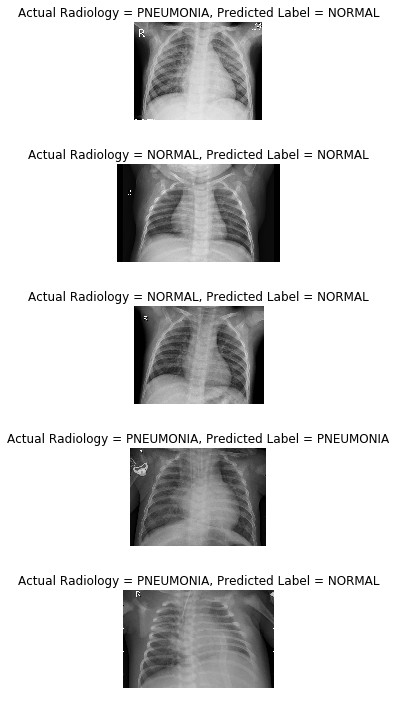

In [34]:
from random import randint
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

label_dict = {0:"PNEUMONIA", 1:"NORMAL"}

test_file_names = test_iterator.filenames
n = len(test_file_names)

plt.rcParams["figure.figsize"] = 12, 10

for i in range(5):
    index = randint(0, n - 1)
    file_name = test_files + test_file_names[index]
    
    image = cv2.imread(file_name, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ground_truth_label = label_dict[int(y[index])]
    predicted_label = label_dict[int(yhat[index])]
    
    plt.subplot(5, 1, i + 1)
    plt.axis("off")
    plt.imshow(image)
    
    title = "Actual Radiology = " + ground_truth_label + ", Predicted Label = " + predicted_label
    plt.title(title)

plt.tight_layout()
plt.show()

![Output Test Images](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYwAAALICAYAAABsGMetAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzsvXm0ZHlVJvr9Yo44MQ83btx7897M%0ArMyagGKoRwGKQrdagP3K5j0FW1cDLUvaiW6Wrc+hRUUE28dTee1TwdXKAkWw6aUgz6dPWrrKBqmy%0ACmUoqjLJ8c5D3JjHE+N5f5z4dv4iKm7WvUmBzeP3rZUrb0xnihN7//b+9v62chwHBgYGBgYGTwfP%0AP/YBGBgYGBh8fcA4DAMDAwODY8E4DAMDAwODY8E4DAMDAwODY8E4DAMDAwODY8E4DAMDAwODY+H/%0Alw5DKfVypdT213B/jlLq3OTv9yqlfv6knzMwuFUopU5P7iXf5PFfKqXe8DXY79uUUh98hrc5dS5f%0Aq88aHA9fFYehlHpIKVVVSgWP+f6v6Rc92VdbKdVSSu0opX5DKeV9JrbtOM4PO47zy8/Etv5HglJq%0AXSnVnVyzA6XU+5VS0clrDymlbKXUKe39366UWj/i8/z3W5PX5hqeGUf80OTxc2fe89HJ8y/Xnrtb%0AKfVxpVRdKdVUSj2olPom7XXeb38xs60PKqXeNvl77qJjct5DpVThmbp+zzQcx3mV4zgfOOYxfftX%0A4xi+1ou2ryYm98rjSimP9tw7lFLv1x4HlVL/QSm1OfmeLyul/jellNLew99JSylVUkr9qX4fTX4H%0AjlLqLTP7f8vk+bfNPH9GKTVWSr3niGN+xhejz7jDUEqdBvAtABwA3/VMb/8ZxHMdx4kCeBmA7wXw%0Axn/k4/l6wAOTa/YCAP8TgLdqr7UBPF1k9YDjOFHt35tPuP9LAF7PB0qpDICXADjUnrsNwN8CeBzA%0AGQBLAD4K4BNKqZfMbO9FuiN5OiilLADfDaAO4F+e8NiBm18/7kPphsngfxgsAfgXN3n9vwD4NgDf%0ACSAG4HUA/jWA/zjzvjdP7oFzAKIAfm3m9al7fII3TJ6fxesBVAF873EX518pvho35usBPALg/XBP%0AVKCUCiulfl0ptTFZ/X1aKRUG8N8nb6lNvO9LZleds1GIUuoHlFIXJivIa0qpH7qVg3Uc5wpcA/M8%0AbV833fZk5bCnlNpVSr1x5rX3K6XeoT1+k1LqilKqMln1Ls07DqVUQin1B0qpw8n1eSsNh1LKO7lu%0AJaXUdaXUm3ktlFKvUUr9/cy2/p1S6s9u5XocB47j7AD4SwDP1p7+TQDfNzHYXy38EdwfB6PB74Pr%0ADPrae94G4GHHcX7OcZyK4zhNx3F+E8AfAvjfZ7b3LgDvPMH+vxtADcDbMXNvnwSz12+y8nynUupv%0AAXQAnJ3cD78/uc92Jita7+T9XqXUr03uh2sA/pm+/cn2flB7/Cbtfn5SKfUCpdQfAlgF8H9PfnM/%0ANXnvi5VSn1FK1ZRSX1DTkdsZpdTfTLbzXwFkb+X8lVL/TCn1OaVUQym1NbtynuCNk9/XnlLqJ7XP%0AepRSP6OUuqqUKiulPqKUSt/KcZwQ7wLwS2pOFkQp9W0A7gfw3Y7jfMlxnKHjOI/AXVT82LyVvuM4%0ANQAfg2Z3JngMQEQp9azJtp8FIDR5Xt+ngmtr3wpgAOCBr/D8joWvlsP4o8m/Vyil8tprvwbgXgDf%0ABCAN4KcAjAF86+T15GTl+fAx9lME8D8DiAP4AQDvVkq94KQHq5S6E25EdOU421ZKvRLATwL4DgDn%0AARwZ0iul/imA/wDgtQAKADYA/PERb/+/ACQAnIUb9bx+sm8AeBOAV8G9uV4A4NXa5z4O4IxS6i7t%0AudcB+IMjjul3JsZg3r8vHnUuM9s4BXcl9Tnt6R0A/wnALx1nG7eIXQBPwv1xAu41mj3P74C72pvF%0ARwB882SBQvwOgNvV8dMybwDwYbjf4Z1KqXuPe+A6jrh+XJHG4N4n7wcwhLsSfT7cc6YTeBPc+/P5%0AcCOV77nJvl4D14m+Hu79/F0Ayo7jvA7AJm5Efe9SSi0D+H8AvAPu7/MnAfyJUio32dyHAPw9XEfx%0Ay7h1p9meHE8SrrP7EaXUq2fe80/g/r7uB/DT2nf0b+De/y+Du+qvAvjt4+xUKfXnN7n3//xpPv6n%0AABoA/tWc174DwN85jrOlP+k4zt8B2IYbecweSwbA/4ppu0P8IW5EGW+YPJ7FSwGswL0XP4KvYAFz%0AIjiO84z9m5zEAEB28vgigB+f/O0B0IWbCpr93Gm4KSyf9tzbAHzwZu+Z2cbHALxl8vfLAWzf5Dgd%0AuF9+e/L3hwEEb/J+fdvvA/Cr2mu3T7ZxbvL4/QDeMfn79wG8S3tvdHJ9TmvHcQ6AF+4q+W7tvT8E%0A4KHJ3/8NwA9pr327fi0AvAfAOyd/Pwvuj+jI87nF73YdQAvuCnsDrrENT157CK4xy8FN1zxrcozr%0AR3ye/94077ue+Z7OzezjX06+rzsBXJq8tg3g5ZO/hwBeOWdbd062t6zfSwB+FMAjk/d8EMDb5t1D%0AcFfjYwDPmzz+KwD/8Rm8fm/X3psH0OPrk+e+D8CD2v3ww9pr98/cDw8B+EHtON9yk2P6du3xTwP4%0Aw5n3/BVcY7Q6ubaW9tqH5n1vx/kNzrz3/wTw7pnf+Z3a6+8C8PuTvy8A+DbttQLc35QPT2MjvoJ7%0An7/T75x8dwG4TvX9k9d/D8AfH/HZRwD8nPa9dOD+RhwAnwewqr33bZN7cBWuM/dP/j+l35vaPj82%0A+fslk2uwMO+380z+e6YjjDcA+ITjOKXJ4w/hhufLwg2trj4TO1JKvUop9cgk1VOD+2WeJER+AVwD%0A/r0AXgTAOua2lwDoK4mNm+xjSX/dcZwWgDJco6UjC/fm0Le1ob1vdp9TKxkAHwDw/ZMw9XUAPuI4%0ATu8mx3WreLXjOEnHcdYcx/lRx3G6+ouO4xwC+C24KZubfZ7//tPk+SHc8xcopfh4MLONPwXwTwG8%0AGfNXXiW4RmQWBbgGvzrz/O8ByCulni6kfx2AC47jfH7y+I/gXnP/TT4zi5tdP/07XYN7Pfa4Agbw%0AuwAWJq+f5B48heP/5tYAvEZfecNdBBYm+6w6jtM+5n6PhFLqRcotRDhUStUB/DCe+tudPT+mctcA%0AfFQ7vgsARnCd7FcVjuP8BdzFyWz6+6h7DpPnS9rjf+s4TgLAPQBScKOE2f1swo08fgXAZWcmcplE%0Aya+Bew/CcTMymwC+/4SndGI8Yw5jchKvBfAypdS+UmofwI8DeK5yK1tKAGwA83Lc8yRz2wAi2uNF%0AbV9BAH8CN8WVdxwnCeAvACicAI6LjwB4GMAvHHPbe3B/hMTqTXaxC/cG53FbADJw0zc6SnAN45r2%0A3Kr2vj1M31j6/uG4+dI+3NTa92O+IeUxvFdNVyrp/564ybkcF/8H3HTCSdI1m3BXhzrOwHUkU9fK%0AcZwO3Pz/j2D+ef413B/TLF4Ll9vozGyvDzeN9su4+f3zerjcAu/t34Br5L7zJp85CfTfwBbcCCOr%0AOde44zjPmrx+kntwC/N/c7P75Hv/cMapW47j/Opkn6nJPXyc/d4MH4KbSj01MZ7vxVOv/ez57WrH%0A+KqZYww5Li90Uyi33Pioe/8vj3nsPwfg32PaNv013AKKqd+lUupFk/P4b7MbcRzncbhRym9PFnqz%0A+AMAP4H5qeX/BW568Xe0+3EZX4O01DMZYbwarqe/G26u/XkA7gLwKQCvdxxnDDed8xtKqSXlEncv%0AmRjoQ7irv7Pa9j4P4FuVUqtKqQSAn9VeCwDg54ZKqVfhRl77VvCrAN6klFo8xrY/AuBfKbd0MwLg%0AF2+y3Q8D+AGl1PMm5/krcHOd6/qbHMcZTbb7TqVUTCm1BuDfwQ1Duc+3KKWWlVJJuKmDWfwB3NX9%0AwHGcTx91QI5b9hs94t+zjvrcceG4ZN6vw+Wnjov/Fy4n8DqllH9CYv4KgD9xHGc45/3/HsDLZq/j%0ABL8E4JuUSyKnJ9fz38A1+POuG+A6nhCAV857UbnVVbcBuA837u1nwzV8r5+85+VKqWdkVoDjOHsA%0APgHg15VSceUSvbcppV42ectHAPxbpdSKUioF4GdusrnfA/CTSql7lYtzk/sLAA4w/Zv7IIAHlFKv%0AmPw+Q5PzWnEcZwPAZ+ESvwGl1EtxDKJ1sg39n4LL01Qcx7GVUvdh/sr455VSJH9/AMB/njz/Xri/%0Ak7XJ9nNKqX/+dMcBSLnxUff+q465jYcAfAmacXYc568BfBIu3/OsybV7Mdzr+R7HcS4fsbkPwI2M%0A5lWT/me4ducjc157A1xb+hzcuB+/Ge7i/Dna+wIz1/4rbx14pnJbcH/0vz7n+dcC2IebYwzDzVfu%0AwM3j/XfcyOO+Ha6RrgF48eS53548vgKX6NPztD8G94avwf3B/zFucAcvx9NzGOdmnvtLHv/Ntj15%0A/Wcm57QLtxx3LocxefzDcFMCFQB/DmBl3nHADU8/OLkGW3AjHs/kNR+Ad8NNZ12HG7kNAChtW8yx%0A/9Iz9Z3OXJ91aPnumdcewiRnPnkchVs4sD7z+S7cPD7/fVR7/ZsAfBpuymgXrqFLHbWPmf0LhzF5%0A/OzJtW5M9vMQgJdqr58GnsKZvXby3Ntm7yG4RupP5uz3PriRQBpuyupvn4nrN3kuAZeb2ob7W/kc%0AgH9xxP3wY8B8DkO7B788uRZfAvD8yfP/HG50VwPwk5PnXgTgb+Der4dwSfDVyWtn4S4AWwD+K9wF%0Ays04DGfOv3NwSfoNAM3J9yTb0b6bfz25D/YB/JS2XQ/cxdSXJ5+/CuBXjvpen6F7f8peTK6RgwmH%0AMXkuBLcKbwvufX4Frp3wPM33/NMAPjv5+203uZ4fnLy+DDfyfs6c9/wFgF/Tjnn239zfz0n+qcnG%0ADb6OMIl63us4jp7uCsM10i9wjl7RGHyVoJT6PQD/xXGcv/rHPhYDg68WTAv91wEmzuCfwE1T5OGm%0AwT4687YfAfCYcRb/OHAc5wef/l0GBl/fMBHG1wEmXMnfwC0N7cJNE7zFcZzG5PV1uKThqx3H+dxR%0A2zEwMDD4SmAchoGBgYHBsWA0awwMDAwMjgXDYRjMxY//+I87g8EASikEAgEAwHA4xGg0AgB4PB7E%0A43GMRiN4PO66IxKJoFqt4uDgAIBbgaeUwmg0wmg0QqvVQr/fx2AwwHg8hs/nw2AwwGg0QrPZBAC0%0AWi3Yto1WqyXH0ul04PV64fP5EAqFEIvF4PV6EQ6H4fP5kEgkEIlEkEgkkEgkEAgEMB6PcfbsWQQC%0AASilMBgM4PF4WE0CpRSCwaBsJ5VKwePxIBwOo9frodFooN/vo1arYTAYyOfC4TD8fj/6/T7i8ThC%0AoRACgQCSySRarRba7bYcb7fbRa/XQzgcRqfTQbvdhsfjQbfbhW3bsG0bg8EAtm2jVCqh1WrB5/Oh%0A2WyiXC6j3W6jXq+j0+nIdfZ4PFBKQSkFn8+HYDCIYDCISCSCUCgEr9eLUCgEj8eDYDAIv98vzzmO%0AA5/PB5/P/dmPx2OkUilsbW0hEomg2+0iHA5jPB7jYx/72Il6mgy+MWAchsFc3HHHHdjY2ECv5zaM%0A9/t9RCIRBAIB1Go1MYg+nw+O4yCZTAJwDbHX65Z7O46DUCiEfr+PbrcrhiwWi8Hj8aDf78NxHPR6%0APXg8HgwGA/h8PrRaLeRyrnxRqVRCKBTCcDgUg9fr9RCJRODz+eD1euH3+xEOhxGNRmX/t99+O0aj%0AEWKxmLyfjsu2bYRCITnX4XCIzc1N5HI5jEYjtNttMbbdbhfj8RjJZBKDwQDBYBChUAjj8ViOn8fk%0A8/ng9/uRy+XQarUwGAzkuEOhEJRS6PV6CIVCGAwG8Pv94gh4PrZti7Fvt9sYjUYIBoPweDywbVsc%0Ahd/vRyAQEAcaCATk+VAoBJ/PB6WUOAqPx4NAICDOlOf23ve+F9/1Xd+FT37ykxiNRqjVanjNa+b1%0APRoYGA7D4Ag88MADzqte9Srs7u6i3+/D6/Wi1+vB7/fLSte2bXi9XkSjUXi9XliWhY2NDXS7XQSD%0AQSil0Ol0MBwO4fF40Gw2MRgMxLgxWul0OkgkEuh2u7h06RLy+Tx6vZ4YT8dxJLqhcwkGg2IwI5EI%0AUqmUGM4zZ84AAGKxGHw+H7rdLjqdDhzHgd/vR7PZhMfjQTQaxWAwQCQSEacTi8XQ7/cxHA7h9/tR%0Aq9XE0ANuFBWNRjEajeDz+WTFPx6PEQgEUC6X4fP50Gg0MB6PxTnQIfI6djodHB4eQimFdruNVqsF%0Ax3FQr9fRaDTQbDaxtbUl5+v1ejEejzEajcTwW5aFYDCIaDQqTpVOnZ9RSolD6vf78Pv9GI/HUErh%0AAx/4AN7+9rcjn8/j0Ucfxfve9z5xuKPRyEQYBk+BcRgGc/GKV7zC8fl8eOlLXyppEwAYjUYYj8fo%0Adrvw+/2S1olEIkin07h8+fLUqphG0LZtjEYjUAXB6/XK6juTyaDb7aLdbuOOO+5ArVbD+vo6hsMh%0AxuOxrPCDwSCKxSIASHRx6tQp2LYtTqhQKEgKJhaLiVNiNBAKhdDpdOT46Ih8Ph8ikQgiEVfxwXEc%0ADAYD1Go1AEAgEMBgMEA6nYbf75doYzweizNwHAfNZhPj8RitVgvj8ViiHp7HxBhjMBigWq1KyonR%0AQ61WQ71ex8HBAVqtFoLBILrdrjjk4XCIfr+P22+/HUopJJNJFItFOX+m4PS0FQAEg0FJEQKA3+/H%0AysqKRGiMnKrVKrxeL37iJ37COAyDp8A4DIO5eMUrXuE4jgOv14tCoYC7775bVs2O48hql4Y/mUwi%0AnU5jY2NDnEiv10O320Wz2RTnQD5kMHA1BcfjMSzLwmAwQDweRyAQwHA4xKlTrizPcDiEUkpWxkzb%0AWJYFv98v26TRjkQisG1bjDp5Ap/Ph3g8Dtu20ev1EIvF5Jhs20Y4HIZSCpFIRPiSwWCAg4MDiagA%0AIJvNSsRAY0tHaNs22u02er0eRqMR+v0+xuMxANcBRaNRrKysTEUlzWYTo9EIjz/+ONrtNgaDAfr9%0APqrVKjwej/AXTGGtrq4iFAqhWCwKD9NsNsVh8JiYKtO5DzrDer2OZDKJ1dVVeDwevPnNb4ZSCu94%0Axzvw1re+lc7ROAyDp8BwGAZzwZWzz+fDwcEB6vU6vuVbvkVy8+PxWIxzLpeT1XU0GkWpVJKcvM/n%0AQzQaxXA4FCOsGzOSztFoFIlEQlb2h4eHCAaDCIfDYgyHwyESiQTC4bCstKNRd8ppv9+X7aRSKTiO%0Ag263KxFBp9MRw0keIx6PS+qp1+shHo/DcRyMRiPZPkl5v9+PRCKBXq93QyZhQqYz7cSUDzkEpryY%0ADvP5fKjX60in0/B4POj1ekgmk2g0Gnjxi18sEVGpVMKVK1fQ7/cRDAZhWRYCgYA4l3a7PeVIg8Eg%0Aer0egsGgXGdeX0YddCaMvnit+v0+crkcOp0O3vWud0EphV/8xZvJoxl8I8M4DIMjwdXpeDxGr9fD%0Aww8/jLvuugupVArdbheNRgOWZU2lPmzblsodpmDIWzBiobGj8R6NRlKdw9eZf2cKR1+VZ7OuEjaJ%0A506ng1wuJ5wCjzkQCGB3dxe1Wk0iEG5TryzicZFzoBEfDAbCx3Cln0wm4TgOgsEgGo0G4vE4ut3u%0AVNVSOByWqipGLEzPBYNB2LaNVColBQOsbhoOhxINnT9/HrZtYzgcol6vo9vtSoEAAOTzefleuG9e%0AU/5NBxGPxzEYDKRaK5vNSkpuNBrh53/+5zEajeA4Dn73d38Xw+E8vUcDA+MwDI6AbduIRCJCSNu2%0AjQ9/+MOSmgGAd77znQiFQmg2m/IepnfoSLiadxwHjUZDHAdXwvy73W6j3+8jkUggl8vJZ5mLp7Ev%0AFot48sknMRwOEQwGUSgUkM1m4ff74ff7oZSCZVm4ePEiqtUq2u22OC2+zvMrFouIRqNC0GcyGUmZ%0AsRw1mUzCtm1JwfG4/X4/UqmU7LfX6yEajaJer8ux66QzIxK/3y+kOQBxLI1GA6lUSsp6Acj10SM0%0ApgM9Hg/q9bp8H3QQfr8fPp9vKtoJBoPi0N/xjnfgQx/6EF772tciFArhPe95D+LxOFqtFn70R38U%0Av/VbvwWTpjY4CobDMJiLF77whU4ymZSKJKUUPvrRj+I1r3kNzp07h0gkgl/4hV/Ab/7mb0oPRTwe%0Ah9frRavVknSV1+uVFAoNa6fTEQ6DK91kMilRi9frRb/fh1JKopFQKATLsmQl7PP5kM1mpVIqGo0i%0AFouh2WzC5/Ph+vXr6PV6aLVaUgbLklLuk6W9THP5fD4sLi4Kt8H0m+4AYrGYcCSMUobDoXym3+9L%0ANMR0FlNDTJ+1223UajWkUim02200m02USiWMx2MsLy/Ltej3++j1emg2m0LUs0+FHI3OkzBtFwgE%0AhIdheo6ltI1GQ/pVWLXGKKnX60l08bM/+7OGwzB4CkyEYTAXuvGbBctsAaBarUqPwmAwQKPRmCKi%0AacRY1glgapskmulQFhYW0O12pRpLjxy4imajXDQalb6Oer2OVquF0WiEbreLy5cvY2lpSVJdSilZ%0AdbNngivxZrMpDoAOxuPxwO/3o91uS9qIhjgQCAixzOiJfSlMbbGfhNVS6XR6itQmAoEA4vE4xuMx%0AyuUydnZ2sLOzI0ae5baAG/Ukk0lYlgWv1ytFCEzV8RoyMvP5fAiH3RHmbCBkSS4r2/RtsxKMDsjA%0AYBbGYRjMRafTwXg8RjweBwBZeQ4GAzSbTbz73e8G4KZSSPKWy2WEw2EpuaXhCYfDshLm6p6Gjit3%0ANtLRSViWJYadjoccQz6fF4PI7nLyHlw127aNy5cvY3FxEWfPnoVt25LSYRUXV+NMNTE9RUIagDgz%0AGlrgRqoIgPRFkJBmD0av1xOupNfr4bHHHoPH40EoFEIul8Pp06cxGAwQi8XQ7Xbh8XjEOfV6PenZ%0AYLUZiWt23iulpsh/AAiFQhiNRohEIsKl8BqyvJdNfPyfjpl/BwIBOXcDg1kYh2EwFyzlZFqGEcPH%0AP/5xNJtNpFIpfM/3fA9SqZRUAbHclCtjroS54qZxolFi1MBqJaab6AxIAHPfoVBIeINAIIB2u43D%0Aw0PpJqfzaTQaWFlZkT6HCxcu4Pz589K4B0COU+8O12Uz9O5tOjzyL3SGdG6MqNhDQY6DzXlbW1vi%0ApKrVKgaDASzLwsLCAoLBoKzqV1ZWcP369anS2NmOdpYdM9JhBBcMBqWai5/h/+SRotGoEPLsq+Hj%0AbrcLy7LQbDanuuANDHQYh2EwFyR6AQhxOx6Pcf/99yMQCGB/fx+vfvWrAUCqgFiFQ+NLp6BrGHGF%0ATyOvcx5c+ZKgpjwGiVzyC6lUCtvb22g2m6jX60gkElKhNBgMkM1mcXh4KF3eoVAIBwcHWF5eFqcC%0AQFJLdEo0orNkNau3dIKZPRCMRpgS4vFXq1V0u11Uq1W5Lvp2BoMByuUyIpEIkskkOp0Out0uCoUC%0A2u226E4xXQZgSkeK5b96DwqPndea79OdHJ0QACHoyVExPbi1tfW1u9EMvq5gHIbBXLBUlGWgNEg0%0Aiq985Svx4IMP4o1vfKMYJ67y2U9Rr9cxGAyQyWSkQoj58+FwiGazKYaPaRemcgBIr0cymZQoZGFh%0AAU8++aREP1xtx2IxqbTic5ZlCXfQbrdx6dIlKTPN5XISXTAdE4lEpIGPGlK6gwMgXAWNPxv26GBn%0AeQDLslCtVoXriEajQj6TdG+1WshmsyJsyCiHfSZ6GTIASaMxrcfjcBxHyHtdroSRH6M4VmjxOrNo%0AYXt7G/V6HZVK5Wt0lxl8vcE4DIO5GI/HwgUwPQJgShJkMBjgfe97Hx544AFZrZM4ZjqKjWb5fF4q%0Ap9gZzmYzqrSyKY68xWg0ko5vOporV65IT0ImkxESmc9ZloVGo4H9/X1Uq1VZPVuWJZpXw+EQxWIR%0A/X4fq6urACBNh3R4o9EI1WoVAKbOZ1Zuo91uw+fzwbIsUXwlJ0ESOh6PSwNeuVwW1V46g0AggCtX%0AriCVSgkRnclk0G63Ua1Wn9Lnwqov6njRaXm9XmSzWeFCGKkxbUVCn6S44zioVqtotVqo1WrivAwM%0AjoJxGAZzQcFAvULoec973lRPxP333494PD6V/mA1DlfFvV4PiURC3kcSl0Rsp9OZWunrq2lKldPx%0A7OzswLZtKW3leyktopTClStXUK/XpfOb5C4NLElsx3HQbrexubmJbDYLy7Kk+1nXuGo0GkKKs2JL%0AFz1kZzZBHoGENXCjmdHj8SCTyUjD3eHhoTgGpRQ2NzexsrIiAoiWZYkGFwl1ppYYKbGkNxwOC2cR%0AjUbR7XYBQFJbjDJqtZr0ZRSLRanmYnRIbsbAYB6MwzCYC5LeNPB6+aVe8spUE9Ve+VmqwSaTSamg%0AOnXqlGxnOByKYdRF+Who6QhooPf29qTKimkiVgfpUQcjI6aYDg4OYFmWpKwoM07DSplvpZT0cFAn%0AirLtrOaiI6RiLwUDGW2xFJld1ZT2oAGvVCpSEjwej9Fut6XhkWmh9fV1LCwsIJ/PSwquUqlI+onp%0ANvIavNaWZUk/BSVUOp2OzPRgibTH45G5Hezz4LHzGs4rpTYwAIzDMDgCzHMz1QHcqCxiioP6UTT8%0AAGS40OLiohg1lsgyBcVohJGELrnNyGZpaUka9tjUpufqO50O9vf30e/3cXh4KCWsSqmpHHw8HsfS%0A0hI8Hg/K5TIajYZ0hlNaROdWeI50DOQeuF+mdBglUP2WhP7u7i4ODw+nZoBwHseZM2ckGvH5fFhY%0AWECz2ZzS5/L5fKhWqzIUCnBlQEqlkhwTAHFi5Fao+MtokAR5pVIR4htwIw5iPB5P8VN0HNyHgcEs%0AzFLCYC7Yd0HHQRE9NugNBgP0ej30+33pyuaKlqqw+hwNACiXy5Jv93g8SKVSSKfTCAQCsg3KWSil%0AEIvFZN9cIbPBbXt7W8pm2aPRarVwcHCAeDwulVN0NOFwGPl8XoT8SG5Ho1GpKtKn0tFJ0JEwzUTJ%0AdZa1UnrEtm1UKhVUq1XpmOZxVyoVHBwc4FOf+hS2t7dhWZY4PfacsE+En9vd3ZWVfjAYlEiN3A4d%0ACiVNKOdOPqVSqaDf74vQIXALGQsmAAAgAElEQVSj8o2Kuhzw1G63JQ3F9JuBwTwYh2EwF7rsBI0k%0Au6iZN6fUuG3bMiiJHAf1pHRjrzecARBhP3IbrPjJZrPCeQwGA5k8t7u7i6tXr2J7e1tWypQRJ+G9%0AurqKWCyGeDwuhC+rnfSRqOQT6BAASEqLzoKGU29009/H1BTgdrxfv3596rgYiViWJSNgPR4PHn30%0AUVy9elWuh8/nQy6XE8fDfayvr4viLTvCmQJjBRllPiiWmM1mxfnwmlOxl86I31+325XogkOm2LNh%0AYDAPxmEYzAWNJJvpaEhZfcNcPZ0GUzuMPDqdjshasNSV8x+Gw6GsdsPhMMLhsOhQcVASjRqHBO3s%0A7MicbUYBgJsCW1tbQ6FQEJVcvZOc0Q6PnWmd4XAokQ+72Znm0ed/65VRTNnoHdiO46BWq4mD4PhZ%0ARil0AhRoZIXTeDzGpUuXJAXECrOFhQWpLOv3+9jc3EQmk5ka8ESV3dFohHQ6LQUA7DAnr0HOhd8T%0AhRfZrc/qKNu2Ua/XxVmYSimDo2AchsFc6I1oXCnrY1KZc+dzTHWQHKZjIScBQCqZWMFUKpXEUPn9%0Afpw5c0ZSRIxOtra2sL+/Lwq2+iCjQqGARCIhVT5MYeky45yPwSY3fXYFV9gsvwUgHdNM27CCCYAQ%0A4cCNyYP1el1KazkXJJ1OY2VlBcvLy7BtG5lMRsph6/U6er0eGo0GOp0OnnjiCVSr1SkHQ1KcA6h2%0Ad3eRzWbh8/mwvLwsfRjkMDg6l2Nu2dPCiEbnYDqdDkqlElqtFprNpjQ/MlKjUKSBwTwY0tvgSLD5%0ASx8vqmsQ6SKElKAYjUbS7c1VMEnl8XgsMiJcHVerVenR4EqYs7QpZEjHtLi4iHA4jEqlglarNTXr%0AQT++ra0taYpjUx+rq+r1OvL5vDTKsTKIc8EZJbFLnAKE7KAGXDkNlqrato2FhQU5p0QigWq1ilqt%0AhkAggGg0ikgkgkwmg3K5LCWwgUAAjUYD0WgUh4eHsh1Wiy0sLEhUx6gsHo9LVOT1epHJZHBwcCAV%0AZYwm2H3OY2KE12w20Wg0RH+KJcOs+GLUZ8pqDY6CcRgGR4LGmv/0FT6NEhvN2Fuhl2kyNUWSlytd%0AGjHKmpMLIL9RKpVEsRaAdECTHyDBq5QSo3f58mWZqsfopNfrTc3K0HWsyuUyer0eVldXhetg9MHU%0AEsUGdSkQztag3AcdIcuImRJitVgsFhNye3l5GeFwGHt7e1JWTP6m0+mgWCyiUCjAsiwAmKoKGw6H%0Aks7i9WQUlE6nJXqjA9T7YMgrUetKj5x0Eh+AnL+BwTwYh2FwJGjk9bJM/bE+M1pPW3G1ysoi5v+Z%0AJqEDGgwGKBQK0mQWjUZx5coVdDodRCIRBAIBWJY1NVyJ+2DJ6LVr16RfgnwKCd9UKgUA0k3dbDaF%0AcGcTX7vdhmVZqNVqiMViU2WzFPfT+RyS/ZQWZykunQwb5cLhsEQA6XRaVvXdbhfJZBLhcBjVahWd%0ATke4hl6vh93dXZFCiUQi8Pv9iMViUpKsCx3y+lerVZnap5fEkvAfj8cSxegzR+gIyV1Qnl2XXzcw%0A0GEchsFcsNR1XpShixHqMhOMMvg58gFMYzENw3LVdDotUYrf75dVfzQalXw+8/F0Nvv7+2Ism80m%0AMpmMCP1xVnW1WoVlWeh0OqhUKnjWs54lPRqMeCKRiKR3OFuDK3SmhWiQAQjxzfOlA/J4PJJmI4dT%0ALBbFwAcCAaRSKYkKcrmcRDTZbBaNRgPdbleGHZG74HuoDaU7bZYfAzcaLB3HQTwel5QgG/QoCXJw%0AcCCcBTkKVryxmxxwS28PDg6+1rebwdcJDOltMBdcZc6LLAAIEcw8Ox0KiVqWfgaDQdRqNeElWBXE%0ACIUOgo1pCwsLsu1WqyUd03t7e9jY2ECn0wHgrp4TiQQsyxLpc6UUTp06haWlJaysrGBxcRGFQgG5%0AXA5LS0sIhULIZrNIpVJiNOkc9PGt+mxxppsoW8J0DwCRGme0pKezaOx7vR6efPJJXL9+XdJQ+jCo%0AZDKJXC6HTCYjvSEce8trwv1RC4opMarksjO9Xq8DgCgB87thYyDLZsm/sEya3ycLGBiZGRjMwkQY%0ABk8LOgl2Iut9CPwbgMyMoIEbDofodDqy8iW3wHQRc/xc6bJjmnxDt9vFxYsX0W63p8aictVMQpvi%0AfkopKQn1+XyIxWJIJpOIRCKo1+sSIXF1z/3R2TBNw8hJ72jX8/xMiXE/XPGzTPi2227DhQsXUKvV%0AZC4653Rsb2/jtttuEw6ECrOhUAi1Wk14BxYBVCoVSVGNx2OJnugcmFLSj5PpNEYf+vXSe2p0voLP%0A0WkYGMyDiTAMnhY0Qno/BnCjtFSfH0EDxvcyn8++DVbzMH1E0piy5hy41Gw2US6XpxRzx+MxisWi%0ANLFRkoTbD4VCWFhYkGY38h2lUkkId3Z9A8Btt90mEiT6PAwAU45Qb9pjJKJLmZDroGKv3+/H4uKi%0AOJV8Pi/poUQige3tbZTL5aleCjbihcNhmRHCYoBer4dSqSQGndeRMvKzY1l5Del09WmJekMhcGNc%0ALh/zmhkYzIOJMAyOBT3KYPmq/hz/J9FK58H/Z5Vqqf3E0aTs19jf35ehSd1uV0pjqU9FfSUaRMpq%0AUNa82WyKNAgA6bOwLAuhUEj2xQY5Gm32brDKi30ZTB8BkLQUAHEuHE+rS6kwPfWc5zwHm5ubEhl5%0APB6RPvd4PDg8PJToi2ml4XAo3dqUXaGj6HQ6WFhYQL1eRzweh8fjEXFC/ZowSqCzZVUaIxoAUs2l%0AN2TSmRiHYXAUjMMwODZ0B6E7BP15VhEBENKXcxnINXA1DkA0pDgTQu8LAIDFxUUMBgM0Gg0AkJ6D%0AarUqkUgoFMK1a9ek4zocDmNtbQ3BYFAqn7xeL2q1mhDTjGzG47Go1nKeBY0nSW5d2kQfh+rxeKRy%0AiY6Iaat0Oi0VTdVqFel0GrVaDaFQCK1WS2Q/2u22NObxWjG6iUQiKJVKiMfjksLa3NzEbbfdJtGS%0AHuEx3aRfW3ZusxeDisDkMfQUHPkZ04dhcBRMSsrgaaET3npqSq+OotGi4WFqRncq5Cei0aisqJVS%0AKBaLUjpLI5ZMJmFZFizLkpLZQCCASCSCSqUCn8+HWq2G7e1tHBwcIBaLYWFhQfiIUCgkOlWsgOLK%0AORgMivYSOQyWtkYiEYlGWNIKQMQGec48N30kKiu5+By3xe3Q0Pv9fpFNJxG+tbUlOlr61LyFhQUZ%0APMWoYH19HbVaTTihQqEgTppOm2W87LjXU2yMJLh/pqr4OepLGRjMwkQYBseCTvoCN5wI0yt6NREA%0AEfhjYx/J8kwmM7XS3dnZkdU5jTTTQNRpsiwLhUIBg8EA3W4X7XYbg8FAxPgajQaWlpakD4FVRlSm%0ATSaTMlQpEolIx3QgEJAqIX2uNSu89LkfNLg05rqh1Su/WHXF0bDZbFaa/didzXJebn93dxeWZWF7%0Ae1u6vdl7QWebTqdxeHgo13h/fx9erxdLS0toNpvI5XLY2dmZIq55bHTE7BchQa6XCQM3xu/ysYHB%0ALIzDMDg2dN4CgBh5vfQWgOgekasgybyysjJVBrqzsyNGlvl4j8eDSqUizoONaZwUx05l9gvQoF65%0AckVGsPp8PqTTaZTLZfj9fhSLRekqZ+6fQ49SqZREBnrTn97Rrkuk0OCydJgS78AN/gK4ISUeCoWQ%0Ay+Vw7do1kQmhbAiHQEWjUSl9bbfbSCaTANz+EEYK4/F4qnHRcdzxqqurq+h0OnLNdSenR0R69RPT%0AaRwcpRPhelGDgcEsjMMwODF0FVdGCpxwx54GnegFXONHw7qwsICrV69KBziJ33K5DJ/Ph3g8jn6/%0Aj93dXezv78vcB51/8Pl8qFQqiMViiMViU+Wp7HVgb8La2prwCdFoVHL7JNDZt0A+Qj8/5v75nK6P%0AxQl9NMhUqeVnaJQ5bpUpsGw2K3Id7BX54he/KGmt4XCIvb099Ho9iaJmo5RqtYpkMolGo4HFxUXp%0AdWm1WlJSS94FcKu7KBNCh6Ar8OqOwjgMg6NgOAyDY2FeSS1X3vqcCCrC0vgxhcNUDCfocWgPOYJ+%0Avy+8Rb1el7JSzrze2dlBvV5HvV6XfayurkqKiekkkuXD4RDRaBQrKysYjUYIBoPiGFipRZlzPQUG%0AYGpMazAYFAc4K/nOyISkOg07t0HHFo1Gheze2NgQwt6yLPT7fVy8eBH5fB6FQgHAjabIZrOJ3d1d%0AERLkOfh8PqytrcnzlF2h0yMXw3MIBAJybiTwdV6KRLfex2FgMA8mwjA4NmZXoOQwZnP4TA0BmCK3%0AQ6EQotEoLl26hGg0KvpFlmVJimh/f1+EAxnB5HI5LC4uSjWSLvaXSqXQarWmZlowDcY0TDQalYFM%0AkUhEVHM5g4Od2nQidAq6I6FT1LkBpn44xpYzQVhGzM/rpci2bSOZTOLq1asoFAoIhUJIJBJi2FOp%0AlEiU0GlWKhWMRiMUCgXR2NJ1o3ie5B/0IgNGZHolG4+Jj2e/XwODo2AchsFc6CtuHbM8hj5zQXcM%0AJJEDgQAKhYLwA1xZk7imMaNRZLkrU1NUYmVUkEgkUKlUpKubA5jYrDcajaS/gY1+d9xxB4LBoOgo%0Acbwp02k0/HQSLKnVZ1To+lnAjRG27N+gDAqdy3g8lhQcS41TqZTIfQBApVJBr9cTQp/XLJFIIJlM%0A4uDgAF6vF5Zlwev1olgsIpfLTc3stm0bsVhMBkOx275er0uajlpcTKGxlJmOht+17nQMDObBOAyD%0AuXg6ZzFrVPRy0lgsJukc9i2wakqXQCdhfuHChSkp81QqhWAwKJIa1FxiaSmdUiAQwJNPPilCf8Fg%0AENlsViqm6AxGI3e8q044c74Eq7goHU7DrVeBdbtdeR8rq3huNLDszWCJMc+bcuqUMGeUValUEI/H%0AZQ44OZ5sNisaT2tra6Iyy8mBzWZTUlPsTmfFl97R7fF4hEfSx+ACmJpmSGfB8zDpKIObwXAYBicC%0ADcs85VSv14t8Pi/pHaZO2FvBtBGn4VUqFWxvbwsBvLCwIPyB3++XOdhUmaXT6fV6qFQquHLlCrrd%0ArqSbODQJcEl2NvKxDLbRaIgz8/l8oiXFsbB6uoezL5hio/GnI2CJLa8BUz00yrMy436/H+FwGPl8%0AXlb/nNTH9By71ul02+02UqkUVldX5TorpVCv17GxsSGNghzNury8PDW6lg6EaTh9vgYjCsNdGJwE%0AJsIwOBH0BjAacwBC/KZSKTG0XMEOh0ORMh+NRshkMvj0pz8tTX9LS0tTqa1OpyOVRiwNLZfLqFar%0A4jzy+Twsy8J47I5JpSQ6nRMlvj0ej6Ri0um0yJeTzNaHPbGBT0/RDAYDRKNRqTriSFQ9PaWv0Bn9%0AsNeC2+G5sat8eXkZg8EAOzs7UgXW7XZxeHgofA0HRw0GAySTSYlg2KV99epVLC0tSdppNBphcXER%0Am5ubU/PHOZCJ0ZGedtIdiOEwDJ4OxmEY3BJmu725AmZ3cyQSEdKVlVA0mNeuXROSN51OS3kntY6o%0AewQAV69elf0wDeT1elGtVtFut1Gv13Hu3DlYloXd3V0Eg0GUy2UpY2X0wqY1ciahUEiOVde6Ysks%0AnQ15DOBGJDEbZQGQVBmjFr28mO+lgzt79iwef/xxDIdDWJYlfSVUlmUlGKusAKBWq0nPxuXLlxGN%0ARmFZFq5fv44zZ85IhztTfb1eD6lUCvv7+1OpNL1gYVYo0jgMg6eDcRgGx4a+EtUrcvSUi948Zts2%0Azp49KwY7FovhwoUL6Pf7uOOOO7C/vy8RCKXO6/U69vf3JcqIx+NoNpuo1+vIZDIAbpSsAm6ZKFM7%0AuVxO8vucs80qLJLTJIkZBemrbToY4EYXNh/Pcje8BlSEnU35UKiQvROMlkjqp1IpcZAejweZTEaa%0A93q9Hur1Osrlssi3c3phs9nEqVOnpEFwPB5ja2sLlmUhGo2i2+0il8uh0WiI86JeVrfblQiL/Au3%0AYZyFwXFgOAyDuaBBnoVuXEgoU45Dnw3BXgCK/vl8PmxubsLr9SKRSEjDHlM3gUAAn//857G5uSkK%0AtQCEjI7H49jZ2UGn0xEi9+zZs1hcXEQikUA6nUYqlUK73RaimT0aTNeMRiMhxMkd0OHxfPRxs/o5%0A670mdJSsMKKjZHktq6/oSBnN6JP0Tp06JcfqOI6Q+uQuOB3v4OAAm5ubaLVaiMVisCxLVHbj8bjI%0AuF+5cgWJREJSX+QkyKVQwFCPeGa/U57zUd+9gYGJMAzm4qi5zlxh04gy7UIRPzbR+Xw+LCwsiFQ5%0Au47pTLhCz+fz+NSnPiWRCVfiTNNsbGwgmUwik8lIBzhX9bVaTeQzhsMhCoUCwuGwOAlKf9CQh8Nh%0AkQWhk+Bqm+dGvoGGl//rRpbHrk/cY0ksz5cOQx9GFA6HZZBRq9WSeRaDwUDmY9i2jcXFRZFiL5VK%0AQnQPBgNks1mJFgaDATKZDOr1unS18/tZWlrCxsaGNOrF43EcHh5OpRCPkgIxM70NjoJxGAYnwjzS%0Am4Z4cXFRykvpJEajEZaXl3H9+nWpBmI1kW3b2NzcxPLyMorFohjhVquF5eVlBINBGcFKJ8MeDw5U%0ACoVC6Ha7slJfXFwEcENIr9lsYjQaIZFIIJVKIRKJTEmw64q7LKflCntevp/nrc/25mtMyzEaYZTE%0AMlx2s5fLZSkf/vznPy8OhCNk0+m09FNEIhFcv35dtLdYYqxPA0wkEtKTkUwmUSwWJe3G4VScm643%0A/bFTfDaiMjA4CiYlZfAVgWmnYDCIRCIhK/RCoYB2uy0pmng8LjMtAoEAvvzlL+Pw8FDE+7LZLE6d%0AOoVgMIi1tTWZc8H303FEo1GJVKLRKMLhMBYXFxGPx0VWhIaSDWy2bUuJLSfQMUJigx57Qlj9NDu/%0Am82E+twJvbKIDoy8CCMXpRRSqZTsr9FoSARmWRbuuusudDod6Q+hhtb29rYMRlpZWRE5lHK5jPX1%0AdXFwTAXm83ko5Y53TafTUx3vwWBQrhUrsvQoz1RIGRwXJsIwODG4GqXKLA0SV676mNB4PI5QKISr%0AV69iOBwimUzi2rVr0nPg8Xhw+vRpmVLHprZwOCwS5Sw9ZXppfX1dDB8dBWdGWJaFK1euiABhtVrF%0A6dOnp+Q/GEnQ0dEx0MDzOWC6k51VVnqEQgkOPkfHQEfD68B+j16vh8PDQ0ljpVIp3HfffXj44Ydx%0A8eJFBINB6eaOx+PC2aRSKUSjUayvr8Pn8+H69etYXV3F2bNn5Xrbto1wOCyVZizzJUjKk9fQo0Xj%0AMAyOAxNhGNwy2Jegz7Aej8eo1WryHhowCgA+/PDDUhJbKBSwtrYmMho0cIPBALFYTIYMhcNh1Ot1%0ArK+vY2trC/F4XAx0v98XroArahLDlmUhm82i2+0inU6L8WYHOQl1pn84T1vvm6C2FNNPLOvla7wO%0AJLgZsTCKYNqOzikSiUxVPnHI0T333CNNho7jCHcBAK1WC7VaDUop3H777SKRwi50OixGDX6/H4eH%0Ah0+Z881iAZ2HMtGFwUlgIgyDE4MGhqkhABJdtNtt6QPI5XIAIBVRn/vc5wBAjCXnMTD/zqa9RCKB%0AarWKYrEo/ECr1ZLooFQqIZVKoVqtSv6eRrDf7yOTyaBSqciKm5wDyWhuk9VYTEPpelAApgYM6REF%0AANGyopMcDofCz0QiEYmAWP7KFJXu4Hw+HxYXF9FsNtHv97G2tiYpM6/XiyeeeAJKKaysrIj2VTwe%0Axz333AO/3y/XqN1u4/Tp0wBuzLpgVMOKqkajgXQ6jUajIU7M8BcGJ4WJMAxuGTSkbKijvDZ7LnSj%0AVCqVEAwGkc/npYN6b28Po9EItm2LEB4n0LXbbWn+i8fjyOfzSCaTwmdQxbZQKIh8uGVZYrhJ9nq9%0AXnmPPpGPBlifZw3cqBDSq4gATK3g6QR0fSY+pmzIcDhEq9WS0bOUNKG0CDkYRiX5fB733nsvPB4P%0ASqWSyLTbto2trS1Eo1Fks9kpTiWfz4tz3traksimVCohl8vJuTH6IpnPrnzgqWKSBgY3g4kwDG4J%0AzPVzFc2/aWDD4bBEEOQnqCBLgx4Oh7G5uYlEIoG9vT1pcqMsRjgchm3bsG1bSmFjsRjK5TIcx0Gh%0AUJiavx2NRkWITyklGlHssqakBlMxury5fl468R0MBp/yvM5Z0MHosuE0xvosimq1KhEZP085dAob%0ANhoNnD9/HoPBAI1GQwQI+/0+tre3MR6Pcffdd0sjJK8Tr+fm5iZOnTqFeDwuUceVK1dE6bfdbksv%0ABvkL3VkaGDwdjMMwODFIGAOQ3DhTUePxGGfOnJGIgfxDLpfDwcGBSGAwTXL58mXhLOLxuHRmRyIR%0AFItFeL1eRCIRJBIJMY4c5cp0FCfYMfXEXo1IJIJwOCz9HfybXAUdhz6TnBEROQtWW3GlTkKbaTSm%0Awsh9ANOpLL5Xf446V+zL4Hmxuomkv1IKly5dQiKRQCwWQ7PZxPXr13H69GnRmAqHw3LspVIJfr8f%0Aq6ur0hDJ9BM1rnw+nzQa6tfMwOA4MA7D4JZAcpcS2jS05CeKxSIymYxUGXHiHMs7H3/8cek9YLkp%0Au5kDgQA6nQ5WVlbEuTDCoCG3LOspch3sbG42m9ILwXGsNMD6YCOS2ayeYtSgN+vp0+lYacXnqVbL%0AFT6NM0UCGVFw+ywh5vxw8iq2bcs8jlgsBp/Ph8cffxypVApnzpyRqIjSJnt7e4hEIshmszJQqtFo%0AIBwO4+DgAMvLy/B4POh0Ojhz5gwuXLggHAyAKYkSw18YnASGwzA4MfSqIX1+RLvdlm5sznCo1+tT%0A8x263S4+85nPoNlsSsc2iefV1VUsLS0BuDFfgw1mpVJJxpUCbjMcgCk+gUY7k8kgn8+LRDkFBvX0%0AE7Wk2JGtd3UzOmK/BY0830vwPYyy6ETZYzGrVaUrw1JwsdvtStpN72c5d+6cDISicyoUCnAcB+Vy%0AGaVSCY899hh6vZ5USrEy7MKFC8jn8yItz/3xOulO0cDgJDARhsEtgUaHq16Syul0Gvv7+yLfTTE9%0ARh2lUknSKzSep0+fllQNS2CZt6fUNxv2OP+h2+2iXq9jZWVFHM9wOESn00Emk4FlWWg0GrBtG4VC%0AQUbAUtUVuNGMx7SMPpdb14/ShzHpXd58jakt3SHRAdFQk3AmEU/jzs/2ej1Uq9UppxEIBLC5uSlR%0ACvtdGGWMx2M8+uijeMELXiDpQPamsItbFxrksXPSoc45GRgcB8ZhGMzFrEDdLGhgyWVwbGi/30cq%0AlRIjxzLSq1evShkr+zTW1taEjAXcaIElpkz7rK+vIxaLYWFhAQcHBwAg0UkikRDtJqah+v3+lB4U%0Ata30XL5OrNNgsjyYn50lsPUVOR0Ln9dnTzDNo5fo8jqROyHpXK/Xp5wKr3m9XofP50O325XPHBwc%0AoNFoSIPe2toaisUiAOCRRx7B/fffj2q1KhVQHo9H5p0z4qODZ/RzVJShN/sZGOgwKSmDuXi6dAUN%0AL6t+9NUs5cQrlQqCwSCuXbsmaSmfz4f77rtP5Lw3NzfRaDTEmSSTSWmuq1QqqNVq2N3dxcbGBgDI%0AWFK976JarcKyLOlloKx5IBCQElYAU/0W+pwLPW1EYz47C0PnNPiPFV9MHQ2Hw6nRqLPOR+8iZ+lx%0AKBSSJjxyInQglUoFn/nMZ7C+vo5oNColxrFYDP1+H8vLy1hdXUU0GsWjjz6KdDqNVqs1VY3G74Xf%0AF//XHdVJv3uDb1wYh2FwS2BJJtM0nC1N+QuSww8++KBM2ksmk1heXsZoNBLdqGw2i+XlZUQiETH+%0A+/v7KJfL6Pf7Qu6yzLVcLossOaU6fD4f6vU60uk0ms0mAEwNLwIghDNJaZ3wpRFlJZQ+H0NvbmMP%0Ahn7eOk9AR8dZHiS/AQjfQ9kOlhDzPCzLksiMxxsIBBCNRrGxsYHHHntMOA92qbM0l9zQ3/3d3+GO%0AO+5Aq9WSQgNyO7rcuR6FGRicBOaOMTgxZmdD0BCFw2FpcCNPwRRTOp0WgT6Wti4sLCASieCLX/wi%0Atra2ZFASK38CgQDW1tYQj8eRSCTE+EajUcnTRyIRKXXlICM6Cr7OedzkCgBMpYFIGDNy0Icg6akn%0AGl2+ziY6vR+D22RlEx0U5ch5zeg0WHk1HA5RqVTgOA5isZhUk509e1ZEGD/72c/iscceQz6fFx6H%0Azvn8+fPI5XLY2NhAJpORiYVsftQdpT5N0MDgJDAOw+DEoPGhc6DK6srKiqzIR6MRrl27JnLi1WoV%0A3W4XnU5HpLYZDfh8PmxsbODatWtS0RMMBkXWg3pU58+fRyaTkdTXnXfeKWkd/jtz5ozMz0gmkwiH%0AwxLtULeJq3z9WOkE9UomXSJE76fga7pyLauedPJ5llj2+/3odDqSuqKj4/sora7PM+eAKMdxkEql%0AoJTC3//93yMUCkmj4nA4RCqVwtmzZxGNRqXr2+PxYHd3V1SE9cjKVEkZ3ArMEsPglkDimEQza/sH%0AgwFyuRwqlQoKhYKMId3Y2EChUJAU0sbGhhjPQCCAu+66C7u7uxiNRjK3wuPxYG9vD5ZlyefS6TRG%0AoxHy+bx0i9Mo93o9HBwcSMqKMh2O40jZKtMxeoSg93PwH1NT/JsRBqE35envYdMguQq+rl8nRhqs%0AHqMYIhv4yAtRXPDcuXMYDocoFosIBALY3d1FtVrFcDjEy172MkmHUdpcT6EBkMiD58pUlmnYMzgp%0AjMMwODFmjed4PMba2trUapnlnUop1Go1Mdb1el06nbvdLhKJBCKRCJrNJpaXl9FqtdBoNNDr9XD3%0A3XeLeB71qNiEx7RTuVwWLSs2+FERNhKJ4ODgQDqb9VkVjCgYDQCQfgu9m5uDoABIRMLtkNhmxKN3%0AjutOQq+W0gl2AOh0OlNRzSxJDkBkUhYWFpBMJlEqlYQvWl9fxzd/8zejXq9LM57P58Ph4SEKhYLM%0AzdA7unUdqaerhjMw0EbQWL8AACAASURBVGEchsEtgf0MNEIse+UsB/ZF1Ot1KeP8whe+gE6ng3Q6%0AjXA4jFwuJ/0CtVpN+ArOyqjVasjlcvD5fELkkkhmwxpTKySCGXEMh0O0223pRuc/vas6nU5LSS/T%0AQYw6PB7PlPPTuYvZGRjUutJ7OfRJfHxeb8Qjr8DogGQ3q8XoVHnMwWAQtVoNOzs7OH/+PDweD/b3%0A9xGJRPClL30J99xzD1qtFlqtljQRkgdqt9s4e/YsHn/88anGRSM8aHBSGIdhcGJwBc7GPDaV0XnY%0Ato1WqyViedvb23j00Ufh8/kQCAQknaLPvL7nnnumOAOS6M1mE+12G7ZtI5vNolKpoNfrodlsotvt%0AiuggAEmzMPqwLAvBYFBGpHICIKui2CVOB8NUEHWoCP29+jwJvVeDEQmdAx0MK5VI9FOZlwKCesc8%0AJ/+xbLjX64kceaFQwLVr17C4uCgyIxyeVCqV8MQTT+DZz342ut2ukP/Ly8sSFcVisakpe7qzNzA4%0ALgzpbXDL0CXCO52OiAbW63XJ1/v9fjzyyCNihNvttmhF7e7u4vTp0zh16pT0P7ByiHLljEZisRi+%0A+MUviqPo9XrweDxIp9PIZDIA3PRSqVQS461Lj9Ows0eB5aV64yEASUPp6rPAjcl7fEylWQCSttIV%0AbfXCAHIWuoNgTwadCdNJenWVUgqJRAKhUAiBQEC65/k+NgQWCgXUajV89rOflZkk5FJImJP0J38z%0AmxozMDgOjMMwODFozHq9nhi3druNVColq1bLstBut3HlyhWcOXMGXq8X+/v7yOVyGAwGSKfTyGaz%0AqNVqYnhZvUOHQM2ky5cv4/Lly8jn82g2mygWi6jValIySo2ncrmMUCiEbreLUqkkpayMABgNscQW%0AwNSUOx26UdWb9vQIhaWx9Xp9qqeDn+f7dJ0rPQpptVrw+/1yPExPkTQnJ8MIhM5jMBgglUrJNaNQ%0A43g8xic+8Qlx5ORZyOEwpTfbb2JgcFyYlJTBiUHDRvLYsixYliV8BDuMd3d3Ydu2RBTxeBzJZFJG%0ArMbjcVSrVelwbrfbyOfzaLVacBwHxWJRtI8WFxdRq9WEKOd+x+Mx6vW6cBONRkNW5rVaTVblXNET%0AJIfpEHguTNsw8tA5DL2bHYAYXq766Rj0eRf8HNV1g8Gg9GwwuqDTUkqJsSeHwSozptn29vakLJiV%0AZOPxWJxPNpvFQw89hFe+8pVSEZVIJNBsNqWBcta5GRgcF8ZhGMwFc+nzMNvUlkwmEYlEUKvVxGFc%0AunQJXq8X0WgUtVoN586dg2VZODw8RCAQQCqVQi6Xg9/vR6VSQb/fRyKRwO7uruT36/U6ACAWi2Fv%0Ab0/KdBlZFItFrKysoFgsIhKJoNVqIZlMolarSdUUq6pouKlgq/MSJLtptOkMZ6MFAKKPpUcZ+uQ9%0AptZIorMpjyNmuX1GAHxMboNOKRqNQik11avCQoOtrS0sLS1N6W5Fo1GpKCsUCtjY2JB56VSoJXh+%0APP95372BwTwYh2EwF0c5C+DGypQVP/l8XiKJUCiET37ykzh16pREGpFIBCsrK1KlQ8VWGnYq2m5u%0AbsqsC1YIcbVtWRbC4TDi8biknWhQKUtCIUAq57KaaTQayVQ7pnyYKiJBTQehp6JYTkvjrpelkkcA%0AbggT6g1+/X5/SuKcq32mpHgs5E4cx0EoFEKn05GeEXI0vV5Put/D4TCCwSDW19flGlHRl9EV533T%0AqdN58voAkI73k373Bt/YMA7D4JbAvLtSCrFYTLSLKpWKGNPBYICFhQUxpKdPn8aFCxeQTqcRi8VQ%0Aq9WwsbEhq3SWyXJsKfWkmOq5dOmSGN61tTXYto1UKoVMJoPDw0Nks1lxFqySYpc4e0RYCQVAUjt6%0AtKRLhejqs7qsOZ+nA+F1YGTEklxWK/F4dGfBfTN1xcooOrFmsylOg1Ve4XAY5XJZSHNKxA8GA5w7%0Adw6xWEykQp73vOeJgi9nhzCy0tWADQxOAuMwDE4MvROaEUAsFpOUUr/fx/Xr1/HCF74QgUBAGvcC%0AgQCy2Sy63S6efPJJDIdD1Go15PN59Ho9JBIJqeTZ3t6Wfd15551YWFiAbdtIJpOIxWIi2GdZFgaD%0AAdbW1mRlH4/HYdu2jHClsCFLXAFIlRSjA102Y3YWhm5YmY5j3wcAkRnRpUfoIAKBgBQHcBgUcCNq%0AYaqK8zrY/U5JEyr8drtdtFotLC0todVqiaw7ey+2trZk7gf5jU6ng2w2C9u2UalUpnpMzCxvg1uB%0AcRgGJ4ZuNO+++25UKhVks1m0Wi10Oh0MBgPcc889qFQqiMViQvg6joPFxUX8wz/8g5TXZjIZMWbZ%0AbBb5fB6FQkHkQZhKoUw5O8iZkorFYqjX60ilUmJYI5EIVldXMRqNEI1Gp7gLABgOh1MjX1nWytX+%0A7GQ9OgA6ntkeBlZZseKJZbQc6ESHw892Oh2pDGNvBif7kZBmFZht26jX69IRz7G2d955Jy5fvizV%0AVJ1OB8ViEYlEAi960YvQbrelOECPQj73uc+J4zAwOCmMwzCYi1n5Dx26dlImk0GxWEQymcTFixcx%0AHo9x33334cqVK7BtG89//vNl9d3pdNBoNJDP5/GFL3xBDPC9994Lv9+PTCaDWCwmaSOfzycDhCzL%0AkkY9Ph4MBmJs9aa08XgsDoky4XqUQN5gVsKDjXY8R877mFWipYPQV+kkq3VeAoCs+PXqKp4bx7uy%0A/JdCgt1uV9J7dDytVksqqgBgZ2cHKysrGA6H2NzcBABsb29jbW1NoqJqtYp0Oo3BYIBqtfoUh3fU%0A92tSVQZHwTgMg7m42ehOPY+vT5Lr9XoySpURw8bGBuLxOBqNhvAS7XYb3/qt3wrHcRCPxxEOh5FK%0ApaQzm5EEjbNlWdIpzbkWbIpjhZBOWrOaiJwCDbg+VpZVU/p+9D4JXUJDL3+lIyXHwQZFXjMa2263%0AK9vXp/lx7gYVa+lEWE3l9XoRi8XQ7XZRrVaRSCQAuNHJwcGBOCiOvPX7/VhaWsITTzyBl770pWi1%0AWrh48SLuvPNO+b7oNBk16eT3Sb97g29sGIdhcEtgGodT9ZiSabfbCIfDiEQi0jxXqVTg9XpRLBbx%0A3Oc+VwYD0WAWCgUAELK73W4jHo9Lf4PeOU3hQUYUTHexU5pd1/zbcRx0Oh0ZOBSNRqdSMuyB0MUI%0ACb1fgcaWlV+MmpRSEuXQmPN68HXOPZ9NW41GI9GyovMlEV6pVODxeNBoNNBsNqXf4+DgAMlkUvSo%0AWDb8wAMPYGdnRyrMLl26hLvvvlsIc3JHPGe9C97A4LgwDsPgxGAaZ3V1FePxGLlcDl/+8pdl2l65%0AXJbub07Ju/fee3Hq1CmEw2HRfgoEAsjn8xIJ0DGk0+mp1TqjAEYgTPuwIonCgiSUadAZBZFz4Zxx%0AXdVVdxCzvRF60x75EUYZeqUUIxJKivB9JJ/1Ma6sJovFYgDcHhY6Ezof27YRiUTQ7XZxeHgojuHi%0AxYsIBAJyrUOhELLZLAqFAjweD06fPi2KvnpZMc+dirqz8ucGBseFcRgGtwSv1ys5cXZccyUcCoWk%0Agc+2bdx7771IpVLIZrOywuZsCxpQfQ4E8/p6JRJ7PPQUElNSs8OPSGbrZap8H6Maks1MJ9EB0HHp%0AjXt6SS0dCA2ubnjpFPQ+DkYQ7C+Z3SZwQ4uKZDg74nu9HrLZLNrtNvb393H58mXs7e0hnU6LE2Fl%0AFFNM6XQajUYDo9EIf/Znf4a3vOUtAIBWqwUAcuz6+RjHYXBcGIdhcCLoY0xjsRhKpZJMzwuHw+j3%0A+yJTkUqlcP78eekE73Q6OHXqFCzLkpUvUz2RSEQMGUtJuR+SxIwQyE/weGjodS5B14qiceZcCK7k%0A2Rg4KxjIc2SFkR5xcBwrHQMroug8aIRJoOvyGzxXkvUcOjUajaS8Vt+O1+tFMpkUHuUlL3kJGo0G%0AarUaqtWq9Lt0Oh0sLS2hWCxKNdfFixfh9/tRr9dFYZfNi9yecRQGJ4VxGAYngi4LEgqFRMaCDsO2%0AbREZTKfTSKVSSKfTcBxHKqBo2NlUB2CqUolNgRTh4+uUICcYFQyHw6mmOv7TV8804twWowjgxhAl%0AvTOa56k35emyHl6vF9VqVbgRAFLGS6Kb/Agb+Fg2SwfIdBb31e/3hWPhful0er0ecrkcYrGYpAL3%0A9vZw9epVkUvxeDw4ODhApVJBJpORv/P5vPA8JN153vOchqmSMjgKxmEY3BJo0Gj42JxXLpell4JR%0ABeCurtkXQDKa22GEwAiFxpwpqtlZ2fqKniWk+nZ1JwHcIK/ZIc3IRk8pMb2lHxcNKyuaeJxMhzH1%0ApsuW81x5bfgZRl2cDsiKKH3UrZ5+4/6pwOv1erG0tCQRHCO8M2fO4JOf/CQ2NjZkVjqryc6dO4di%0AsYhMJiPHRP7lZrMwTJWUwVEwDsPgRNC5AI/Hg5WVFelT2N3dxdraGnK5HCKRiCivBoNBERpkWonV%0APFS41Q2/rujKaiwaYEYAjDx0VVk6AUYjelRBA0mORd+vHjXon9O3qa/G9TJcEu08dl3OXHduVOjV%0AU2fsDOc2Z7vI+/0+MpkMWq2WyK/Q6VBWPRQK4f7778f+/j4efPBBRKNRZDIZ9Ho9FItF3HnnnSiV%0ASohEItjf35/ah4HBSWFiT4NbAjWK6AA8Hg9s28bS0pJImIfDYWSzWaRSKXi9XsmlM8VCZxKPx+eu%0AzjlyVe9jCAaD4myYYqHsiK4HRcOtp6FY1srHjAwYzbCsNxgMCt9Bw6rvjyklzqugyCCfp9NjFEZe%0AROdjmLaiaix7T4Ab0Vs4HEYgEEAwGEQikZDrxwqxaDQqz/1/7L1pmKTpVR143tj3JTNyrSWrq6qr%0At1J3A0ICyWrkFpoGjAwz9mCzSeCHRTMGMzZgm2UGjS0wm/EAHoPHYBhAQmjQIDYJIYH2pUFIJdTq%0ArfbKyjUiMvZ9ef3ji3PzxteZ1Vntlho63vM8+WRmLN8WX9zz3nvuEo/H8bKXvQz9fh+lUgnj8Rin%0ATp2S61YoFFCpVHDq1CkhS6dhONwunIfhcFtgSEZnKjGunkql0Ov1kM/nJVspk8nIaFQ2APR7D3pV%0A728VTiNKA84fegwkAnoB1AQY8mGqKzUN3XFWty33DxXyZ0ppzYMejNZYONOD4R5mPOk2JAS1EJ57%0AJpORCX5azNfzv+kZ6VYi3Fer1UIikcDc3By+5Eu+BOvr63JszWYTKysrItQvLCzI/h0cbheOMBxu%0ACxREw+EwFhcXpdaiVCpJsR31CFaA+7OTdKorQ0E03pos6DVoL4GhG/7WRp4eBI0p50wEAgHxHIBp%0AsVfvVzcO1KI3z5n/832aPBlu4ut4jrow0F+NrtudU+vQHpBuiqgFeDYmJDEy6YDT+BYXF2W2OUN9%0A1He01+XgcLtwhOFwW9B1D0wxZbdVjhNlx1jAM87sA8U5GAzfcDs0quPxWIRf3R6E+/UbeT5Ho6j1%0AAK7uOaIVgHgdFLCpYWhjz/f7M6gYOqKHwswpXRTI7CYek05h1W1BDuoUy1CV7lGlCxCBfbLWdSS8%0Anqzx4PZJTuPxGPV6XZozsmjReRgOzwWOMBwOxGEFXXy83++j0+mgUChIG4t4PI5YLDbVPFCHjLjK%0A1oSjRXQaOW3U+b+/XkJ7Blr41sV3XOnrNFqdHaTfp7etPR8+xxblugcVC+74eqbe6uwxejV+IZ0N%0ACQl9XiRQABL6YmhLe0PsOaX1mUQiAQBTGWrWWly/fl2OR4fiDvvsHRwOgiMMhwNxmCBK4x4KhaSF%0ANpvbccWtDSlDQ/F4HPV6fapozE8WOnSj+zgx7MTH+B4+r4+ZZMPaDH9Yie/nvnVIjEZai9QAhAgA%0ATB07DftBYS3dgsR/7YD9sJgmUl4/kgyzyfR8cH+NCsl7PPYmGSYSCWk7whqZ3d1dWGsxPz8v4TAS%0A1O189g4OLkvK4bZAAzc/Py9GazAY4Pjx49JpFYCsyHWX11wu94zQEqErq/19nLS2oFf0NMb+MJDu%0ANKt1D76WhpKhKL6HK3l9rtwOsE9O3J6/7kOTpN+z0sfOH6bIAnhGmMivpbDS3a9pMBTIcCBbi1Dr%0A4MjX8XgsrVwYynKehMPtwnkYDreNYDCItbU1rK+v48yZMxJeYRooU2wTiYSstPnbL7pyhc6CNhpf%0AbRT5Hk0cejWvV+2aLPTqnUafYSlu1699aM9DHwO3T4+EPyQYehWaHLQOQRJkphibKLLy258xxm3p%0Aa6G3wfTaXq8nab3D4VCuFduvdLtdpFIp1Ot1OU6/B+XgcFQ4D8PhyNCr40QiIUaYdRHxeFyMUCQS%0AQb1en0oh1fUJ1lpZEbOfkq5C1kbW37pDi958noacK3GCQq/uTaVF8H6/Ly1JOMCIoSGes7+wUIvm%0A+m+9bx1q43Z0C3OeA49LZ0GRIDRJ+rUbdsUlgVhrkUgkJDuL17TX6+Hy5ctSRc8JiMC+5+TgcFQ4%0AwnA4EAetPnVYh5lRjUZDNAyGaNgUT8+JoEEnaTDVVq+a+T5tmHksWgD3Q9dr6AwjahL0OmjQaaj5%0AHFuR6xCQJiQet/ZqdOt0XYin6ze0TqCFdb0P3QOLx+TfLzUhPXecA5p0H61wOIxYLCbXYDQaYXNz%0AEwDE29Mt3Q/zMpzn4XAYHGE4HIhbCZ+BQEBmbXPeNDN0aFB7vZ7E1WkMtSjO9FmupnVmkz9kpR87%0ASAPRK30+rzOwuB99Tlqc1xXl9IQYcuJrdPqsvx5Dp936Q270YrTXwrGvJB79+kAgIPUnWtMgebAo%0AkOdEjSgej0t4Lx6PyzVNJBJTmoluIa/P46ifvcNswxGGw6HQ9RXxeByLi4vI5/NYWFjAlStXkEql%0AJE6ujSJX68Z4Q5SYysrtUcSlYad3ARyc6srn+DeNLI2zXsnzOR3O8XsrNPDUASh26/cC+8VzWoSn%0Ah6K3yWOjhwFMk1gsFpPzpWfiPzedauwvRgQgabsshCSMMZL15A9j6caPrVYLgYA3c8Pf9dfB4ahw%0AhOFwIFhPwXj43NwcIpEI5ufnkcvlZMQqSWAwGEg4yb9qZt0BQ04kCa6YtWH3h560YWZtB7DvMejq%0Aab5Wp/Vq/cO/otahKxpqPu5f9dO463kZWnDnufjTfOlZ6aJBTVg8D52lxWP0txPRfbvoKTAMyH3w%0A2qTTaQkVau9Ik58mPAeHo8DdMQ4HQq+sAS+00ul0ZIXKSmMdP2e1M99PcFhQIpEQAwbsexE0/P6W%0AIX6jpt+nC/IAyHs1gWgvxW+guR1uV5OEJikaWn0s2gBrr+Sw2hAAYux12IxkrEV8koAmPe7Pr5fw%0ANbp+hftqNpuSncbPJZPJyHxzrWU4OBwVLq3W4UCwCR4JgG0xgsEgstmsGH+dygnsD0JiJg6NIMew%0AMiRFUdZPEv6MoYO8Ai02+1+v6zCAfcHb3+sJ2B/ApOsouA+djaRDYgeJ4jp9VpMSXxcOh4U0dVpr%0AIBAQj4Ln4289wlCWHupEDw2AeHfGGGnqyO3E43GZr87t7+7uiq7kxG2H24UjDIcDEYvFsLGxgXQ6%0APRVXbzab6Pf7+IVf+AUMBgP83M/9HADg5s2b+OEf/mEA+0a60Wggm83ij/7oj3D69GlcuXJFwicE%0APQAd/9ehHX+YB8AUUWijr4v8/B6DBh/3r7D1Sv+g//Xr/FXe2rvQRn889ibt+Qv5qDno6+AnHc4F%0AIelQ69G6h74+3Le/ej2fz6PdbiOfz0soSycPODgcFcbdNA4ODg4OR4HTMBwcHBwcjgRHGA4ODg4O%0AR4IjDAcHBweHI8ERhoODg4PDkeAIw8HBwcHhSHCE4eDg4OBwJDjCcHBwcHA4EhxhODg4ODgcCY4w%0AHBwcHByOBEcYDg4ODg5HgiMMBwcHB4cjwRGGg4ODg8OR4AjDwcHBweFIcITh4ODg4HAkOMJwcHBw%0AcDgSHGE4ODg4OBwJjjAcHBwcHI4ERxgODg4ODkeCIwwHBwcHhyPBEYaDg4ODw5HgCMPBwcHB4Uhw%0AhOHg4ODgcCQ4wnBwcHBwOBIcYTg4ODg4HAmOMBwcHBwcjgRHGA4ODg4OR4IjDAcHBweHI8ERhoOD%0Ag4PDkTDThGGMebUx5uYXcH/WGHN28vcvG2P+99t9n8PswBhzzRjzlZO/f9gY8ytfgH1+Xr4T+ly+%0AkO91eH7xghKGMeYDxpiKMSZ6xNefmhjP0Of72Cb7s8aYljGmaYzZMMb8nDEm+Hxs21r7Rmvtv30+%0AtvU3CZMv964xJqke+w5jzAfU/8YY84PGmIvGmI4x5oYx5t/p+8AY8+vGmP7k2u8ZY95rjLlbPf9t%0Ak8/nP/j2/3WTx3/d93hqsq13H3LMt22Qnu0Yn09Ya3/CWvsdRzymN38+jmGy/RfF4mVie7rGmBPq%0Asa80xlzzve7bjDGfNca0jTHbxphfMsbk1PNvMsYMJvdA1RjzMWPMl6vnXz25Zr/n2+4Dk8c/4Hvc%0AGGOuGGMeP+SYn/Ue+HziBSMMY8wpAK8CYAH8/RfqOI6AB6y1KQBfAeAfAfgnL/Dx/G1AEMD33eL5%0AXwDwXQBeDyAN4KsBvAbA232v++nJtT8GYAPAr/qevwzgG3wLiDcAePqAff4DAD0ArzXGLB/xPI4C%0AHuNxALsAfv2gF32hFjkOt4UWgEO9fGPM9wP4KQA/CCAL4MsArAF4rzEmol76O5N7oADg/QD+P9+m%0AigC+3Bgzrx477D59CMAigNPGmC+9vdP5/OOF9DBeD+AT8L5gb9BPGGPixph/b4y5boypGWM+YoyJ%0AA/jQ5CXVCaN/+YThf0u9d8oLMcZ8uzHmCWNMY8Lc3/1cDtZaewnARwE8qPZ1y21PVtFbxphNY8w/%0A8T03tRI0xnynMebSZKX6B8aY1YOOwxiTNcb8hjGmOLk+P2qMCUyeC06uW8kYc9UY8z28FsaY/9kY%0A81e+bf0LY8zvP5fr8Sz4GQA/oFdiap93AvhfAXyztfbj1tqhtfZz8Az6VxljHva/x1rbgUcmD/qe%0A2gbwWQCPTLY9B+AVAP7ggGN6A4BfBvDXAL7luZ7YYbDWtgG8FcD5ybG8yRjzu8aY3zLG1AF8mzEm%0AYIz518aYy8aYsjHm7ZNjxuQ93zr5TMvGmB/R2z/gPv87k9Vs1RizPlkJfxeAbwbwLyffjz+cvHbV%0AGPOOyT1z1Rjzz9R24pN7sTJZ1T4nI2WMOWOM+fPJsZeMMW854PP/UmPM45N9/ZoxJqbe/7XGmAtm%0Af5V+/3M5jtvELwD4RmPMGf8TxpgMgP8TwPdaa//EWjuw1l4D8A0ATuGAe8haOwTwFgDHjDEL6qk+%0AgHcC+MeTbQfhLT7fcsAxvQHA7wN4F3x28W8CXmjCeMvk5xFjzJJ67mcBfAm8L/8cgH8JYAyPfQEg%0AZ61NWWs/foT97AL4WgAZAN8O4D8YY774dg/WeKGGVwG4dJRtG2O+CsAPAHgtgDsBHBrymBjJfwfv%0AZlwBcB3A2w55+S/CW+2chuf1vH6ybwD4Tnir9QcBfDGAr1fv+wMAdxhj7lGPfSuA3zjkmP7T5Mt7%0A0M9fH3YuE3wSwAfgnb8frwFw01r7F/pBa+06vAXEaw84liSAb8T0tSd+A941ALwv5O/D8yT0+9cA%0AvBr799vr8TzDGJOCZ6w/rR7+OgC/CyA32e/3wvtMvgLAKoAKgP978v57AfwSvM9kFcA8PK/loH2t%0AAXg3vHthAd7nfcFa+/9M9vPTk+/H6yaLiT8E8Bl4ntprAPxvxphHJpv7MQBnJj+P4LkbKQPvHl4F%0AcA+AEwDe5HvNN0/2cQbAOQA/OjmfLwLwXwF89+S8/zOAPzBHCFVPCPiw+7T6LG/fAPBf4BGDH68A%0AEAPw/+sHrbVNeMb8oPs0Au/eKsP7bDX0ffoIgMcAbPrenwDwD7F/n/5jM+3JvPCw1n7BfwD8HQAD%0AAIXJ/08C+OeTvwMAOvBCQf73nYIXwgqpx94E4Ldu9RrfNt4J4Psmf78anvE67DgtgDo819UC+G0A%0A0Vu8Xm/7vwL4SfXcuck2zk7+/3UAb578/avwvuR8bWpyfU6p4zgLL9TTB3Cveu13A/jA5O8/B/Dd%0A6rmv1NcCnkH68cnf98G7qQ89n+f42V6b7Pc8gBo8g/Yd6hh/FMAnDnnv2wD8F3V9ugCq8BYLVwHc%0Ar177bQA+AiAOYAceiX4CwCsBvBnAr6vX/ig8gwp4RnME4Iv8x/wczlUf4zY8Uj6j7ssP+V7/BIDX%0AqP9XJp9zCMD/AeBt6rnk5LP+Sv99DuCHAPzeLY7pzer/lwO44XvNDwH4tcnfVwB8lXruu/Ds34mz%0AR7g2Xw/g075r/Eb1/9cAuKzuy3/re/9TAL7iv+fzeZbj+8DkvlyY3Kf3Te7ba5PnvwXA9iHv/UkA%0A71WfS39yD4zgkcWr1WtfzesJ4CKAu+Dd598M9b1Q+yxO7ofY5Lj+R/8xP5/X4XZ/XigP4w0A/tRa%0AW5r8/1bsr2wK8C7W5edjR8aYrzbGfGIS6qnCu1ELt7GJL4ZnwP8RvC+fFnNvte1VAOtqO9dvsY9V%0A/bz1VjFleMZNowAg7NvWdfU6/z713wDw/wL4JmOMgbeSfbu1tofPA6y1jwH4IwD/2vdUCZ6hPAgr%0Ak+eJn7XW5uAtAjrwvmz+/XQA/DE8Upi31n70gO3Sm4W1dgPAB/H8ufs/a63NWWuXrbV/31qr71v/%0A9V8D8Htq9fsEPCOzBN9nZ61twbsHDsIJHP37sQZg1bfq/uHJPuHfL259nx4KY8ySMeZtxksOqQP4%0ALTzze+bfD8OuawC+33eMJ9TznzdYa4sA/iOAf+N7qgSgYA7Wnvz36dsn9+kSPM/hSw7Z3W8C+B4A%0AfxfA7x3w/Bsm2xpaa7sA3oG/YWGpLzhhGE+L+AYAX2G8rINtAP8cwAPGmAfgfRBdeG6rH/aAx1oA%0AEup/ETQnLu074IW4liYf6rvguc9HhvXwdgAfh7cSPMq2t+Dd9MTJW+xiE96XhsedhOeab/heV4K3%0AIl1Tj51Ur9vCynMysQAAIABJREFUdBhD7x/W2k/AWw29CsA3wbuBD4Tx0n6bh/x87hbnovFj8MJk%0Amvj+HMAJY8zLfPs7AU9U/DP/Rqy1N+CJ6D8/uX/8+A0A3w/PSPnP4xXwQoI/pO63l8Mjzs+3EO2/%0AX9cBfPWEYPgTm5DY1P0yCU/M42Cs4+Dvx2H7vOrbZ9pa+zWT52/nPr0VfmKy75dYazPwVsv+75l/%0APwzJrMPzfPUxJqy1v/1sOzVeuvFh92nziMf+M/CMuDb0H4cX2vyffPtLwQv7HnSfluB5aG8yxhy0%0AKPpNePrdu6yneentHgfwMIBvUffpPwTwNcaY21ngfl7xQngYXw9vVXUvvNjrg/Binh8G8Hpr7Rhe%0AOOfnJmJd0HjidhSeuzaGF78nLgB4yBhz0hiTheduExEAfN/QGPPVAP6H/45j/0kA32m8LJtn2/bb%0A4Qmd906+/D92i+3+NoBvN8Y8ODnPnwDwqPVENoG1djTZ7o8bY9KTWPa/wL6hfDuA7zPGHJsIjv/q%0AgH39BrwV1cBa+5HDDsh6ab+pQ37uu8W56G1cAvA7AP6ZeuxpeOLzW4wxXzb5fO+DR77vs9a+75Bt%0AvReegfmuA57+ILyY8i8e8NwbALwX0/fbeXihrK9WrwsbY2Lqh0kT1hjz6qOc7xHwy/A+u7XJtheM%0AMV83ee53AXyt8cTsCLwV72Hfz7cA+EpjzDcYL6Fh3hjDhIAdTH8//gJAwxjzr4wncAeNMefNfgbO%0A2+GRaX5itL73COcR8V2rILxstyaAmjHmGLzMIj/+qTHmuPGE/h+Bd28Ano7wRmPMy42HpDHm7xlj%0A0s92INZLNz7sPk0d4Vxgra0C+PfwtFI+VoOnbfyiMearjDFh42V2vh3ATRyy2LLWPgXgPXpb6rmr%0A8PSrH/E/B8/jfxqeF8379NxkX9+oXhfyXfvwUc7x+cILQRhvgBc/vWGt3eYPPCP2zZMv6g/Ay375%0ASwB78FLbAhNW/nEAH524rl82MSS/Ay/75a/ghUEAANbaBjxj9XZ48fpvwsEZNEeCtfaz8DK1fvDZ%0Atm2tfTeA/wveivrS5Pdh230fvPS+d8Bb8Z3BJKPiAHwvPK/qCrwY/lvhESzgffH+FN61+DQ8j2cI%0Aj6CJ34RnMJ+xGv884d9AhfEm+B4AvzI5hiaAP4EXn/0Hz7Ktn4GXATQlhk48wD+z1u7px42XhfMN%0AAH5R32uTL+5vYtrdfxe8sBd/3jTxehrw7sXnAz8P7x75U2NMA57m8vLJOXwOwD+F93luwbunDiyg%0Am3hcXwPPq9qDt2h6YPL0rwK4d/L9eOdkkfG18AzQVXhe6q/A03wAzyhenzz3p7iF16nwOUxfq2+f%0AbOeL4cXd/xg+sXiCt072cQVeSO3Nk/P5JDxP9D9OzvsSPI3qC4mfx/T3BNban4YXvvtZeFrmo/C8%0Aodc8Syj3ZwB8lzFm0f+EtfYj1trNA97zBgD/yXefbsNbZOj79Jcwfe1/7agn+HzAWHtQlMfhxYCJ%0A1/PL1lod7orDy+76YmvtxRfs4P4WwBjzLQDus9b+0LO+2MFhBuCKiV5EmJDB34W3iluCFwbzi2v/%0AC4C/dGTx7LDWfqG8MAeHvxVwHsaLCBOt5IMA7obnrv4xvDTf+uT5a/CEyK+31n76sO04ODg4HARH%0AGA4ODg4OR8JMd6t1cHBwcDg6nIbxIoQx5kC3MZPJYDwe64pV+Z3JZBCJRGCMQSAQgDFGfsLhMIwx%0AiMViCIfDCAQCXtXn5LcxBtFoFMFgEKFQCMYYpNNp5PN5LC8vIxaLIR6PIxgMwlqLdDqNUCiEXq+H%0AbreLRqOBRCIhxxYIBBAIBHD69GlkMhn0ej20223Mz8+jXq/La2KxGAKBAHq9npxLJBJBIpFAOBxG%0AKpWSbUYiEezt7SEajSIa9ZKshsMhEomEnPNwOESn04ExBsPhUF43Ho8RiUTQarXk/MbjMQaDgVzb%0AXq+HWq0Gay3C4TCsteh2uwgGg4hEImg2m+h2u+h0OhiNRrDWYjgcAgBGoxECgQAGgwHG4zFisRhK%0ApRIuXLiAra0t9Pt92U4ul0MsFkMoFIK1FqGQ9xWORCKw1qLf7yMcDqPX6yGZTCKbzSIQCKDZ9EoS%0A2u02gsEg+v0+5ubmcOnSJQwGAwSDQQSDQYxGI7TbbSQSCTm/Tqcj58jjHo/HGA6HGA6HsNbi0qWD%0AurYA1trbqnly+JsNRxgzCmMMdDhyMBiIMeQPyWA0GokxMcaIkRoOh4jFYkilUhgOh0Icw+EQ7XYb%0AS0tL2NzcxMLCAqy1iMfjQgyBQADj8RjRaBTdble21e12EQqF0O/30Ww2xYBHIhH0ej0kEgmEQiGU%0ASiUhuH6/j/F4jGQyiUQigW63i1arhUAggGAwiMFggH6/j3g8jtFohE6ng2AwCGMMGo0GAgHP0Q6F%0AQkIEJDc+3mq1MBqN0Ov1xFiTGJrNppBKr9eT90ejUVhr0ev1nrFdTYy8zsYYZDIZFItFDAYDJBIJ%0A1Ot1BAIBFAoFJJNJ+Yxo4MPhsBhwXtfRaIRUKoWFhQWMRiMMBoOp6zwajeS8SAo8Fx5Xu92GMZ6t%0ADwaD8r7RaITxeDz1m5+9C2+/+OEIY8bBLzoNNQ0pADFm1topg0fQSNOA0pANh0PxIEKhEHZ2drC3%0At4e77roLgUAAoVAIsVhMDGyz2ZSVaygUwnA4RDweR6VSQTabRTAYFE8iFAphNBqJl9Lv92U7wWBQ%0ADLsxBqVSCbFYTFbw3BaNIsmGq/NarSb7oCGOxWKoVqsYj8dyTbi9WCyGVqsl10wbbBpUeg3dbhfh%0AcBjdbhfWWvEy+BkYY4TsAM8TKJVK4i2NRiO5bgCmjHM47NVu9Xo9jEYjRCIRHDt2DM1mU7y+fr8v%0A5z0ajZBMJvH4448L0fX7fbkXAoEAIpGIkDW9CRINyYnem8PswGkYMwaSgf6bv7URoEEjWQCQv/l4%0AJpNBOBzGYDBAJBKZIgu+niRkrcXNmzfRbDaFFNrttqz2o9GohL+4zUAggHq9Liv8druNdruNZrOJ%0AUqmE3d1dCSOFw2G0Wi0hjkwmg2QyCWst6vW6GHCu6iORCKLRKAqFguwzEAggHo+Lx2GMQavVQjgc%0AlhW9DofFYjHxqGhsee3omQ2HQ/T7fTHU/J+vHw6HGAwGEu5ptVrY2trCxYsXkUgksLKygng8jmw2%0A+4zwIa8ZAAkNRSIRnDt3TvbJsBHgkR3Di3NzXlf1cDgsIScuEHg82uOiJ8Jz5fXU94TDix/Ow5hB%0A+MMH2njRsGmvgUaBhhQA0um0GN9oNCrPaX2DximTycjrtre3MR6PcezYMQwGA1SrVTF8ehtc2dKj%0AYIyfITGGo0KhEDqdjsToGSax1iKZTCIcDiObzaLX64lHwffE43F0u13xACKRCAaDgRjYeDw+Favn%0AOQFAv9/Hzs6OkGm325XQF7fBaxYMBsUo87rqENlgMEC320WlUkGxWMTW1hYikQjC4bDoPwDkupKg%0AAYgeweM9c+YMhsOhEFyj0QAAISuGtz772c/KcfEz47HwMydxcCFBsuD14WNay3F4ccMRxoxCaxQA%0AJNYeCoVEX/DrGDSgNEaBQAD9fl/EZ619RKNREaBpNLlSb7fbePrppzE/P/8MEZ0hFYY/aNQYu6ch%0AJuExxNVutxGLxWSlzVV8JBJBPB5HPB5Ho9EQwqBeQrE+HA7LuYTDYTQaDezt7ckxa92FxlR7Ffq6%0AkvzocenrMhgMYK1FLBYToqBntLW1hXK5jHA4jGg0ina7jXw+Lx5WLBYTUZvXZjAYIBwOi1g+Go0Q%0AjUbR7/flMzPGoFgsyueWSqXkmgH7JKY9Si4GeM1J2rz+AORakEAcXvxwhOEgoLFgSIUGknFwvoYZ%0ANLFYTDQNbUySySQWFxfFEygUClMx/Eqlgna7jUqlgrNnz4qRG41GU1lLOrzTarUwGAyQTqeRSCSQ%0ASCTQbDZlhaszorjK5/kwrNTpdJDP58XAktS4j+FwiEqlIgTAlX2n0xEvJBAIiM6QSqUQi8VEO+Ax%0ARSIRWZVz2wCmSGc8Hsvqv91u46mnnpJMNL42lUohmUyKoefnYK2V8BiFa55fo9FAPp8Xwb1Wq0lC%0AAwn1ySeflPAfdQrtwXHbvV5PtA8AEu6jZ8Hza7VaX6A71OGFhiOMGYdfx6BxobHWYSeSBQ0VjeR4%0APJZVL1f41AmMMWi322JoaYS4ut3e3sbKyooYKq7ymdZKg0vvptFooF6vI51OI5PJiEYCQFb1/Jsh%0AKIZaKO4CEA+jWCzCGCMESC2BHhbPiUaZqbUAkM/nRdQOBoOSRst90Ljq0Bq3wcyuRqOBra0tZLPZ%0AZwjh+XxeVvPpdBrtdhvhcFg8Dh5HKpUSzYKhMZJWNBoVD43eDsNv/My43/F4LB4YhXt+ntoD1H8z%0ApdlhNuAIY4ahw1EEDSONkQ6ncGXLmHUikUCv15NYvM6wKpfLyGQysmKm0R4OhyJ8BwIB7OzsIBqN%0AYm5uTgwciajf7yOZTMpqeHFxEVevXsVwOESr1UKj0ZDji0Qi4i2EQiExwDR4AFCpVBAOh1EoFERD%0AYJ0Hz53puPRSqM/w99LSkmRP6Vi+jveTGEgmvDb0wgBvtX7x4kUJh9Ggc+VOjSgWi2FpaekZwn0+%0An5cUXoYSAc9b0dlS9JKMMbINHrvWZHid9AKCxEfS4v61h0Gvy2E24AhjxnGQAE7Pgv8zRz+VSsnz%0AegWrNQgacKa4MpzE19M40xOIxWLY2tqCMQa5XE68BB0fj8fjEtNnau6FCxdEB9Ara4abarWaGFce%0A82g0Et2CNRvAvg4yGAyQTCbR7XYlBZeERaPM8Fe325UiNxbW6QJAHcLj8dEL2dnZQalUQjqdluPS%0AHlY8Hscdd9yBQqGAYrEon0coFJIUWYbcqJPwfwBi6JkeTDIaj8fY2NiQ60KCiEQiUyL9YDAQsiV4%0ADDp7jjqRw+zAEcaMw59mSyNNg04CoKHQGVSAtzJl6IkGjOQAQIxiOBxGOp1Gq9VCp9OR0AcNa7PZ%0AFPFc10B0u10JGWUyGTSbTUSjUbziFa/AYDDAY489JoaahpGhJ2YSAZCwUDweR7vdlgK+VColRpXH%0AAkAeIykCENG62WxOVUfTm2DKLPfP9/O61Go13LhxQ2ou/BXzCwsLePDBBzEajVAqldDr9STDjNdE%0AX396eyRTkkm1WkUqlRItgmJ5v98X3YbeEDPDqC/x8+bx65CU1mVYu+MwW3CEMUPQ8XH+rbOhCBoG%0ALT7TmOv4NUml1+tNpXlye1yR02vQ4ijj7loYLhaLWFnxJluyvkF7Ju12G9lsFul0WsJPL3vZy/Dx%0Aj39cjpltM7hN7aVwRR2LxeT1vV5PCuO08aYuAUBCcPV6HfF4HP1+H5VKRTQUrvCp9/A6sEivXq9j%0AY2NDjDy9HnoF58+fRz6fF2+B13N9fV2EZl5PYLqVCCvwtZDf7XbR7/fRaDTkXDWB6m3p1F9dDa6J%0AQRfq8T0Mt/F+cpgNOMKYQZAMtIbBuoeDXsN6BxpgbaAATAnPmmyA/XCPLmrT/Zy4LQqy29vbSKfT%0ASKfTiMViSKfTEv4BgFKpJF7KuXPnUC6X8dBDD+H9738/hsOhhH5IHCQlAGI0ueqn0WZFuK5mj0aj%0A6PV6Qly1Wk36XvV6PdEY8vk8Go2GhHHC4bC0Cmm1Wtjc3JRz08Q0Go1w//33IxqNSmYVz69UKk1l%0AqDEkSA+DISSSJg19p9NBLBZDLpcTD4GZZDrTi58FPRNdawNgquJepzDr1FuXGTWbcIQxQ9CtH7RH%0AcZDnQVGUMW5d/Q1AYu+aEHTBHfWBarWK1dXVqdRNP0FRB6HX0u12US6XcerUKdEm6DGwbqJYLCIS%0AiWB1dRU7Ozt4+OGHce3aNVy9ehWxWGyqApmkF41Gp6q2E4kEYrEYyuUy+v0+er2eCOPRaFSqvhkS%0AImlms1mEQiFJeY1EIlIMyJThnZ0dxONxxGKxqWK3QCCAXC6H++67Dzs7O+h0Ojh9+jQuX76Mzc1N%0Aubb0RGiguX1+TrFYDLVaTQTsfr+P+fl5qcqmljIajdBoNNBsNiWriSFHFu1xm1wEkKh4zDprTHsa%0AfJ/D7MARxozjsC+8DkfogjXG5bV3wtg4DTEwTTibm5uIRqMiao/HY1SrVRFltVHWFec3b95Eq9XC%0AwsLCVAEcjd3NmzcxHo9RKBSwubmJVCqF++67D51OB5ubm1O9j2iEmQXF1bOO37OAjqm4PJ5oNCqF%0Ac1rUZnosq9cbjYbUcbAtCYluPB7jjjvuwNLSEprNJnZ3dxEIBHDq1Cl88IMfnKrEJvkyVZYV6dwO%0A9QOmNJOcdUYYPwdqFLqxI8NYTC7QGV46M0pfJ50ZxcQFRxazBzdA6UUIc4v25v7P+6BwA/8PhUIo%0AFArIZDJSC2Gtld5LXK3z70gkIqEgrmJ123KutnWVNkVdZkL1+30JOWkBlivzdDotxERjd/z4cWSz%0AWQm30DBSF2F2FLOQaNBZJEjjybRaCsORSERSW+kZDYdDZLNZtNttWGtRqVTkWna7XamVYO3D4uIi%0AcrmcXNvhcCgkWS6Xsbm5KUkDvV5PsrHoYfh1AxbvsdaCXkKn05HwHUmV2ku73UatVhOvEMBUaIzp%0Aue12W8R7eietVmuKMEajEer1+lRI0xgjrVn8sK69+YsKzsOYcfgFbw1m4OjKbxo+f1sMGn222KAh%0ApoBLg6fFbNYErKysyHtYN5BIJKbi5IPBAHt7e9jZ2UE6nUahUJAeVFevXkU6ncZdd92FVqslwjSz%0AgFgnsr6+Ll6DMQadTkcILR6Po1wuPyPji/2htEheLBaRSCSmMpYoFsfjcUQiEZw+fVoys9i2pN/v%0AC+E99dRTU14MvRx+JpoweLz0INhjivvnbxptni+Jlt4cM6V0gSKw32JEk4yu/OYx0FPjMTrMHhxh%0AzDiezcPkql93omWoSQvfDF8w44YkQ/2DleLshcT3ZzIZ2b6uHGZVeb/fl1U5dQgAaLVaKJVKCIfD%0ASCaTqNfr+Ku/+iucPHkSmUxGDD3F6+FwiLm5ORG6WY/Bc6rX61MhnVgsJrMoKPoHAgERwre2tpBO%0Ap5FKpWTFnclkpPstPZlQKIS5uTnxDK5fvy6FeePxGJVKRTwEEpxOZdakUCgUxCujES+Xy3J+9DYo%0AwtML014arx+Jrt1uS5aX/vy0lsHPgBlc/lRsh9mBI4wZwUFf7Ft5F3xeEwJXl8B+4zk9O4K/tdHl%0AapmEQEOVy+WQyWTQaDRw7NixqVAKgKlmgLr5HY8FAJaWlqZaXNDwd7tdLCwsIB6Po16vC2klk0mp%0Av2ATRK78O52OZFnplFzui8aV4a5cLoc777wTtVpN9AoaVbY14Wq9XC7L3IxCoSAidTAYRDweF41H%0Ap+ISnBtCD4PGnJ7b6uoqNjc3UalUptJveb394SSSD49BJzHwM/aL3VropqDuMJtwhDEjOIgYns27%0AYMiJoimNii7k0qEpCsg6LEXSoYELBoNYW1sTvYArb3ocgUBA0lJp1HXYyxiDs2fPikEcDr0xq3t7%0Ae9IXKh6P4+rVq1heXhaxPJ/Py0pb13bE43EsLy/jypUrCIVCqNVqaDabU4WFJDJ6BgyJAV4/KWst%0AisWiiOUMNXU6HRSLRVn9RyIRCXstLCzI8KkTJ05gfX1dsq34el0rwetE0k6n0zJTpFAooFqtSn8u%0AAPJeGvhIJCLjWUlm9B40WWixm9eYn2+v15siC+ddzB4cYTgcCgqxNPo0FjoURUNKMtCZRwBEp6B+%0AUSgUJH7OTKB4PC5CrjZQHIwUCoVkZX/+/Hl0u11kMhl0u108+eSToh1wf+VyGcPhEBsbG8jlclMG%0Akf2vWM/AY+PjnD+RzWalriEUCk2F5kg4JLNWqyXpvxTMb9y4MTUXYzwei5A/Go1w/fp1zM3N4eTJ%0AkxiNRlhbW8PVq1elajwajU55Bul0Wgw2yS4QCCCVSmFnZwdLS0tot9vY3t6eGtqks6qYJsyphAzH%0AaSFcF+z5W4GQfP1wiTOzA0cYM4KjrgZ1mIpEoUNTWvCm0SFR0AjrdFwaGxbTNRoNqV+gTpHJZFCr%0A1cTo67oOGrxkMok777wT4XAYKysreP/7349SqSRFgGz3oVN+mSJK7SEYDKJSqUh7kEQiIS04ut0u%0AUqkU0um0aCWpVEq8GmutpKjyOrChog7Fjcdj3LhxQ54nWTC8FgwGRafZ3t6WFuaj0QinTp3CzZs3%0ApcBPC92sweCkPXYVZoYTifXMmTO4fPmyEIauu9HbZCqz1oz0Z6vJCthvQHgQXIhqduA+6RnBc1kF%0AMjShPQyGnvR2dZEXjZG/mlr3pqKxSiQSSKVSKJfLKJfLItpyda1njB8/flyIo1KpIJfLIZvNol6v%0Ao9PpSPon6ygYEiuVSlLMxpkcDN0wJZiCNavLE4kEhsPhVC0FAOlFxWPTNSNslVEsFpHNZpFMJpHL%0A5YR0FhYWZPuZTEbE593dXSE7Eq4xRqYF6toUnb68tLSEubk57O3tCaHQs1haWpLrTc+NJMpWKAcN%0AQiLZ6uaPJHZd8e0wu3AehsMUtFHQxkJ3VdVCKT0KZtfoXkxcBbPZHlfZjIfTw2CGUL1ex/LyMkql%0A0lQ7DbYrN8agVqthe3sbe3t7Um0diUTEMDPjh0I7iYAkwtAMj4/hMJ4TySCfz0vNBR9jthALACm4%0At1ot2UculwPgkS3biQwGA9TrdQAQ7yEYDOLkyZOiRUQiEfE09vb2JDNLhwJ5HRcXF7G7uysDnDRB%0A8lh15Twz1JrN5pQH4Q8rkpi0l8a/SYw8Dl2D4TA7cIThcChIGJoEaFioC3BVTy0AgKyE6UnQgJFQ%0AAEisn0aKAjCwX2VMsZZzKyqViqS/RqNRVKtVAJAOsqyn0Nk+zWZT6hBY/MdiQQ4hajQaUrswHA6R%0ASqWmOvby2EkUnU4Hg8EAq6urklLLSmk/wfL9JCfWqvA8mR3GflIkwOFwiGKxKKEwZl/l83nZZ6PR%0AQCaTQbVaFf2HulAsFkOr1ZpKSOA5MBOLegqPRXtTfEyHH/keAFN/O8wOHGE4HArdUNBvHHRlOFfN%0ADO/49Q4K4gCmSILT+1grwUlwx48flxg8jf5f//VfywhUthcnQbVaLZlbsbm5iXA4jHg8LplMhUJB%0AjGkul5P4PI+JRpxpp61WS9qF85zoKVG3yGQy4n00m01JBLhx44ZkODHcxAwpVswz1BYMevO14/E4%0AgsEg5ubmxNvKZDJYXl7GaDTC1tYWxuOxVNaTCCKRCCqVilxzVn/zs6OR5/wMXVsBQLw4VrHrEKIu%0A2CNp6HvAEcZswhHGjINhivHYm8WtoWsQtJB9UGhKT9ujTkGjRcKgkdeDiTgbY2lpCWfOnJHMI+oa%0AnO9grZVOtWz1wepqblcXzNE7YkYVSYUx/EQiIaEYZkLl83lUKhX5n7oAAPnNdh9M+aWmwvYbbDq4%0Avb2NWq0mojmbAKZSqalVfbFYRCwWQzKZRLlchrVWivpyuRxCoRBOnz6NXq+HTqeDZrMJay3i8bgQ%0AFYmWnwV1COoXBL0sXiMSN9+n02p1dpReMPC3vjccZgeOMGYc7JXkh7+aV8e0+T6CojfTa3WXW6ah%0A0pMguXCF2u/3cf78eSQSCWxubuL8+fNYX19HsVhEvV5HvV5HtVqVOH2z2ZSMIfZdIkExG0nPjWDa%0AKA289kpisRii0ShqtRpWV1fRbrdloBKbJdIgUjDXoTk2LKQnZK2VaXzlclkML8mT2VlsBKh7WV29%0AelWyxHq9nlRrHzt2TDLMlpaWsL6+LpoIj00nHugkBRYpUn9g3QnJW7cu8Xe45Tbp6XE/rsp7tuGy%0ApGYcXOlTrCUYMvGHmPhbV15zVUvwfxohXc+hW6BzMtxwOESj0cD999+Pvb09NBoNVKtVPPHEE7h+%0A/bqs3KlfsLiNYSAaOd063V9YyNbm9DpY9MYQEA2knsPNQUQM4/A68DxIVjS8THmlQK7rG6gxtNtt%0AEcBbrRYGgwHK5TKAfTJutVqo1Wp46qmn8IlPfALz8/NyDvPz87JtthZhSE97eTrVmZpFIBCQc+Lx%0A6M9Fpwbr6+q/loTzLmYPjjBmHAwB1Wq1qcd15hCNohaBdRU3X0ODxd9MndXZVPQuGApjI7y1tTU8%0A8cQTuHjxItbX12GMN3cCgIjSXAl3Oh0hBmoM7HPE9FldxwHsG2OGYHiOzNZiWi7PSQvY1DvordCI%0AAvtdfUkaFN1ZcxEKhZBKpaam2bVaLanMZtiKHgtDT3oa4cbGBk6fPo1WqyXNEjnMiQWBPF5NmEw+%0AYJryQaFEekG6Y69Oo9W1OPyced7Ow5g9uJDUDMNai2q1Ku0tOFcBwDPCEDoPn3F/GmUAUy00GIJh%0AARzfx1nXrLhmjD0Wi+HKlSvY3d1Fq9WaiqsDkDkUnEXN4jcaMg4TYmYVjfhBM6m73S7S6bSEaqhr%0AAPuhN4ZhSAQkORrh8dibpkeyAiC1G2whzxU+vZperye6CTvxklRYR0GjHo/H5TxXVlbQbrexubmJ%0AXC6HZrOJfD4voTCSHgk+HA7L+TBlmaEqAFMeFMNhPEetd/CzP4wY/AWeDrMBRxgzDGMMlpeXEY1G%0Ap8gCwDOqhPlbNxLUNRhaR9DFcFoQZ/yeE/a4Yt/Y2JC4v//4uA8Wq5FQSBCpVAq1Wg2Li4sS8jl2%0A7JhoEBSFWfDGffOHbTjYmRaACMgM29CIc/Vdr9eRSCQkSUCLzs1mU6b1AR7pLSwsyMQ7GmmOhGU4%0AKZVKifZCoqXeEI1G0Wg0YIxBq9XC3NwcisWiXAu2LdEeFbDfaZjQ5E99hxlROoSms6T4vlvdQw6z%0AA0cYMwxtCHSogf/rUJQOJ/EH2K/V0NkzrFZmdpLuJUVRXM8Br9VqUqfAFTlJIhwOo16vS70ECYT7%0AazQaAIBcLidhpWAwiMXFRSEJejysf+A8CWYbtdtt8VbYZ8oYMzXljs+zr1M6nZZrR0OvjXO325XW%0A5Xt7exJi8P32AAAgAElEQVT6ocYRCoWQyWTkWDqdjhQRsn05h0ox3MbOvd1uV5pBNhoNKSIkuekp%0AgslkUs6D3hY/24MypZgl5e9Y6+AAOA1jZnBQHcWzvV5nRzHUdFCFL70OkoW1VpoMMgzFUIy1FufO%0AncP58+dx8uRJOZZer4d2u41Go4HhcCjFadZaCUmNRiOpw9AeUa/Xw8bGBqrVqgwRolfDrCFOs6tW%0AqxgOhyiVSlK7MBwOpSVIPB4XzYKNCGnk6dGwUly37aAHxQJCzv1mpTfrPADIzIpKpYJqtYpyuYxa%0ArYZgMIh8Pi9CdDAYlCl6kUgEm5ubCAaDUqjH1ucMRzHJQPfAYt8uQovbui+WJoXb0Sf04sHhxQ/n%0AYcwIbvdLrYlBZx35hXAAU8ViOuNGh344We/06dOinbBWgbO0SQgsmOt2u5LZw/GwDJcUi0UEg0GJ%0A/dPw0yvhqlzXHNC40tjXajUphqvX60gmk0IQTClldpLWZyh6U8RmexBWinNlTx2CnW9Zsd5sNmVf%0AzCZLp9MYDAbY3NyEtVaGPdVqNUQiERG4i8WiCOsMf3W7XfEMWD/CUJaekaFrLRhK9Os3vFf8GVFH%0AuVccXvxwhDGDOMgg6FUlV6wH5dwzNMPsG3ZwZYik0+lgaWlJwjhsJmiMwalTp7Czs4Nz587h0qVL%0AKJVKaDabMphoMBhI1lIwGJTOtsYYaTgIeJldnO/AlX8kEsHu7i6Wl5entArdjoRppFzBU4chuTFd%0AeDAYIJlMyvt0R14SB8/Nn3rM18diMeTzeWlbcvz4cYzH3jwNHsdwOJTQFkNXDKExAcAYg2PHjqHR%0AaEgF+8LCAowxUriXzWZRqVSEUEkOPJ+lpSXcvHlTNBh9nDohgPeBnyieTcNwHsbswBHGjML/Jfdn%0AvWiyYMqors3QsxMo3EajUczNzUk1N425tRZ33nkntra2cObMGTz55JMSfmKVdLfbRbPZnBLUx+Ox%0AhI5IYOy5ZK03AS+Xy0noKxKJIJvNClno42A4iOEvNgrk8XG1rz0KeiwECxw5/pXeDDUQXguK+4lE%0AAru7u+IhcG4HW7Jz0h+Nux5alMlkpO6kWCwiFArhjjvukHBWPp/HAw88gM985jOSKcaUYjYk5HWj%0ApsTiPnpp/Cz9CwedDef0CwcNRxgOzyAPrqxpTLV3odNl2aJb92Ti9hhWYm2CtRbLy8u4ePEirl69%0Aimq1ikajgX6/j3q9LmEihnUIGlbqD0yVZaM+ttEwxmB+fh5nz55FKpWSGRvscqvnZbCHkx5SxNCU%0A7ngbj8dl9jdDULrdBkNW1FOoaZA0WDNijJlqikgxfnV1VQix0WiIoQ8Gg9jY2BBxnLh69SoymQzW%0A1takvftrXvMa/Mmf/Im8TntoDIk1m01ks1mpTyGBkuQYNtSZVkclClePMVtwhOEgq0z+1m3NaUh1%0AFbFun81sIwCSZqozcZi9E4vFsL29jZs3b6LRaIjxBbwxp1tbW9LjKZ1OT1Uqc7XNau1WqyVtyyuV%0AiqTxsiK6UCjIyloLyMlkEp1OR4Y2MX7PbCZdh0DiYGdaejxMP2XHW3obnE+ue05FIhHxuOjFsL3J%0A0tKSzPIwxoiGQV1BFwPSCwkGg9jb2xPDft9992FzcxNnzpzBpUuXpgYk+Wsr9FRDYH9mOj876kW6%0AIFF7GofdNw6zBUcYM4jDWjwcFJLyx7d1q3I+pseo6owi7YFsbGzAWq+BILu3anGXw4BoXBOJhGgV%0A3W4X+XwenU5HCIB/Uy8YDAY4e/asiOT5fB6pVErmWFOnSKfT4qUwZTWbzSISiSCXy0mVNcVrbo+k%0AB2CqPxWvl7/SutlsotvtolAo4PLly0gmk5Ldtba2hnA4jL29PSHZ8XiMVCqFfr8vRY1a6yD5su1I%0AKBTClStXZBLh5cuX5VqzHiWZTIr3NBqNsLi4iBs3bgCAFPORGLk/nVKrM+T8YUp+9k7DmC04wnA4%0AFDpDCtiv5tYzLUgQ/K2NCmP6rMno9/tYXV0VD0PXBgDA4uIiIpEIarWaxOBpQOv1uoSV6Bmwtbi1%0AFi996UvF4LFIjvoFJ+zR0CaTyanuvLoeIZ1OS4gskUhIk0CSIA0ri+rYpoQeF3s18bj29vZQr9el%0A0HA0GkkX2k6ng2q1img0ijvuuAPGGPG6dF0KmxRS0zh27Bja7TYqlQqy2azoOvTmWq2WVIvrflv0%0AHPU110Sn600OE8KdVzHbcIQxgzhsRag70BI0vDQ8uj6DIROKufQ8NHncc889YsRYgEfBmitfti9n%0Aamyz2ZwK3zDVloaRoZZOp4Nut4v7778f3W4Xe3t7mJ+fRyQSkXbmbKDHY2axG8mg3W7L8CQeP1uH%0ANBoNORfuV7cr73Q6Qkb1eh2DwQCNRmOqGj6bzUrIjZoJK7ar1SrC4TAGgwGuXr0q12xlZUXahujQ%0A0blz5yQc1ul0UKvVJLNKi+3j8Vg8MeoYJA2+l+E+rUHwvmCCwFG8B+ddzBYcYcwYbmUEaMx0gZ4O%0APWktg4V4JAiGOLgqDofDePjhh0Vo5fQ4Tskbj8fY2NhAIBBAu90W4bXRaEzF2mnMrbWymma3Ve6P%0AlddcFTN8pIc1sTaBRMeOsdQhxuMxVldXJa3WGCONE3neurU7rwdJj9crlUpJ0SGvy9zcHHZ2dhCJ%0ARJBOp6Vmg40XSYA8vmvXriGbzWJxcVFmg5OAEokEYrGYtFEvFotSGc73k0h112DWtTAJgdec18vf%0AYNARgcNBcIQxYzhKhTdrDHQYQtcc6FGqugiMfaKMMXjFK16B7e1t3HnnnXjyySfRaDSkTTkNNLUC%0A3UKcleHUEPQ+2F7EWm/uhLUWp06dwvLyMnK5nOybRKE9IBpvhmsYv2d4iaEr6i66PxYb+ukUW14H%0AFgnq4kG2FQGATqeDQCCAbDaLdruNVquFbreLubk50WnYeZYezMrKCkYjb7Z3qVRCIpFAKpXC4uKi%0A9LRiLyhqGiR2emGpVEomE+rpgsB+Nluj0ThU3D5I43JwcIThMAUdotC/ucpmPQZFboaY6HFwNUvD%0APx6P8dhjj6Hb7WJ3d1cGITEUxIwfVlYbY6R7Lr0XCtyxWAw7OzvodrvyXD6fn+qrxCFN7NOkBxXx%0AuX6/L4WCnH0dDodlMBMNJ1f+1AJCoRDq9br0pKKxpvdDD0B30WWjxMFgILMrFhYWJBVXFxUytZX9%0AsXQ6c7PZRK1WQz6fx+nTpxEKhaTVCms7GLrjcfEcdI8rekpcFPAz1wK2E7MdDoMjjBnDUVaONCZ+%0AvQLYX3kzs4YEwkFIiUQC58+fx/b2Nk6ePIkPfehD6PV6WF9fl9AH4KV1NhoNzM/Pi3jOFuDUS/b2%0A9qYm7LFYjuGb5eVlCcEwZNPpdJDNZiWjK5/PixjNjq/chzFGhPBeryftPHTaMB+jFkJvg+nG7HPF%0AbC2K2clkUkJnbG3CrK9Go4FyuYx0Oo1oNIpCoSAFiKyj4LmQhEl2lUoFFy5cQKFQwMmTJ8WLOnPm%0ADDY2NrC7uyuFj8wwo5ahK+/7/b6QpCYHPeCK94hOk3aYbTjCmGEc1v7D/z+NBbUJehHWWvT7fUk3%0A1aGbVquFzc1NSWvlvpLJpLTjSKfTqFarCAQCEiaJxWLSgZWit54SRw9lZWUFzWZTNAIeazQaRaVS%0AQb1el+I+ZjexMyzbiug0W+oLFOQ5zCgcDovOwXPwC9I0vgwX0bgzI4ot2Nn7qdfrIZvNSv+qRCKB%0A69evS3U4tQVeC3+b+MFggCtXrmBnZwdra2tYWlpCMBjEXXfdhUql8gwNhvqS/hwYXtPeCD0jkoUm%0ACUcWDoAjjJmDnplwmBE4rHpXF+PpAj+uiAFIN9XRaIRSqYR+v4+FhQVkMhlUq1UZP0rBNxaLod1u%0AY3d3V/ouNZtNSSHV41epZTCmT92EJMTOruwWS6MNQFbS5XJZVu2s0+C5DYdDKf7TITZ6TsxyYutx%0AnY47GAyE0OiRsIKbjRb39vawtbUlXou1FuVyGcGgN++7UCiIDrS3tyeeEDOgdCgtlUqh0Wjg6aef%0Axt7eHl7/+tej0WjgoYcewh/+4R8C2J8uSMLUU/zo4WkPQney5X3gT691xDHbcIQxwzgoTq1FUIrZ%0AFHj5NwkimUxOvZ56QafTwcLCApLJpMT92Y02n8+j2+2i0+mIKEtNgkaUHgw1CHoFNMS5XE5IgpXf%0ADL2Ew2Fp8AfsawQ0/tlsVoxxrVZDLpcTkT0YDMqx8PW6oE2vztkqhPUWNLS9Xk+ypHTleDKZFGG7%0AWq3K8KRUKgXAM+7sVNtqtXD+/Hmpou92u1JEOD8/L3Ui/Bza7TY+/OEP43Wvex12d3flHCnuU4hn%0ARhcJiNlnvM46nVYnM/jTbx1mF44wZgxH7RGkX8cVKh9nR1WKvCyEoyYwNzcnTfMY3gG8LrM3b96c%0AKmSjUaZOQa+FYnM2m5XajFAohFwuh+XlZSwuLiIWi8EYg1QqhVQqhUgkIm00WMRGI0nPQ7fP6Pf7%0AIkTz9RThaez5m9lS2uMheTI01el0pJUICYShq1Qqhfn5eezu7gqJMQRGQ91oNIScHn/8cen8u7S0%0AJAkBHDELeIOnjDGoVquIxWJYX19HOBzGF33RF+E973mPeJM6C4qkyOwtCu3UN3SjRx6bfv9BtToO%0AswNHGDOCo3zRdZaM/tErS66m2QE1Go1KtpExBi9/+csBeP2ZWG/w5JNPTs2WZqiI2VadTkcqrK21%0AyOVyUoDGUMnCwgKstVhdXcXc3Jz0ctJ1GmxzDkBSS1mwRmGbFdRsNd7pdMSLoJjONFUt+tNDoP7B%0ALDCSiC56s9bKcfB8KcwvLCygUqlImitTeSlSl8vlqZTjVquFxx9/HJlMBmfPnpUsqtHIG/3abrex%0AurqKWq2Gra0tmTTIxIF4PC7kAOyn+frnYvDz15MF9Wd+1HvI4cUNRxgOz4AOU+mwFVNrdTEfPY9A%0AIICHHnoI1WoV+Xwe/X4fe3t7uHDhghTYkTAAT9ymUaNusLCwIMadRpkjUWnYKQrTG+j3+0JarJTO%0A5/OybWYy1Wo1NBoNmXWRTqen2pfrtGGGk6hZAJgqdOP+Q6GQaDHMGNNEwteSLKh1VKtVyZxiU0M9%0Ak4MErGd6J5NJfOYzn0GhUMDCwgKq1SoymQxSqRTy+TzK5bJoLRSxKXiTsKgDsS6FpECS0GNZ/b9d%0AOMoBcIThgGdqGdqQsgaD4RUaTeoHzCL60i/9UpTLZeTzedRqNbz73e9Gq9WSQjj2f4rH4zLkaDwe%0AS2y+0+mgXC5jZWUF7XYbc3NzCIVCEsLqdrsyLKjRaEiYJhaLodlsYm5uTow64/QkE8bsGTpjMR8b%0A87EXViAQQK1WE0PNlNt2uz3lrQDTrd519hGF7vn5edkXt0/PhgV89C4o4FNgZgiPKcORSERaj+zs%0A7GBjYwMveclLxKMaj8fiWRSLRSlg5L4YZmOSAL1E1svoWd86hMXzdHAgHGE4CPxhFX8BlzY0ACR0%0AQlG6Uqng/Pnz+Kmf+ilZvXIlzNUws4yoDdBgMTX06tWr0lmV/ZI4CvXs2bMitusqcRICdQaSHduS%0AsxCObUkSiYSk4kajUXmemU0UgHX9QaPREDICICRAr0QTSS6Xm3rdeDxGoVBApVKRLKhutyvdabkv%0A1pDkcjkRv0ulkmRfsS3IYDDAk08+iWg0ile+8pXymdGbokhOLyiRSEiCgZ43Qq9Cp8/6icN5Fw4a%0AjjBmCEdpC3JQYZ+eTcEMId2sb3V1FZVKBWtra/jUpz4lYZDxeIwTJ06I6EuNIJ1OS+bVlStX0Gw2%0AZV4GDWOxWJR9MgzFaXoAJNOIgjwzm0henKXNEI+udmbmFo0vs7+i0ag0JWSoTdcxsKqazf7YvoQG%0AVmsypVIJoVAIi4uLACA9o2jI9/b2EAwGJWuM+9NzP4LBIE6ePClNEmngtZfw6KOPYnFxEXfffbc0%0AW6THwgaETJfVrV3YX4u6BInc3x6EleyuHsMBcIThoHBQKMIveDPLiPoFBxPR29jZ2UEmk8FwOMTa%0A2pq0Adne3sbKygoWFhbw1FNPYWtrS4wZC/2YYkoDSqPOlFvd1TWdTiOVSklbDB4f/2c4R2sdFKjp%0AeTDkxEwnZjTpUakU85kVRe+FwjaJgzoB98mq70qlIinBDBHx2pVKJfEgSMTstsuWJQCQzWYlnMV6%0AEjZ1ZBPHarWKRx55BOVyGWfPnsUDDzyAj33sY0IILLTUP3pEKz0K3YyQ94G+B3THYofZgyMMBwCY%0ACkkAEOGVWTRMNWUcnJlOXL1zIFC5XMa5c+ewvr6OWq02teL95Cc/KRXResgSCaLVakm9QDKZlJAK%0AC/nK5TJSqRSSyaSEg1iNTaM7GAykjbrO+KHXoduVax2D50HS4Kqa+yC5kWQYcmKYhx4MQ2Tcr56h%0APRwOsbCwIMfe6XSwt7cn3Xk5C4R/s7UJU4xjsRjm5+dlH7u7u5KA0Ov18Na3vhWPPPIIrLVIJpM4%0Affo0rl27NkUGOtSkx7Hqoj2/GK7hMqVmG44wZgi300yOuflac2DoheEohnJ2dnawvLyMWCyGe+65%0AB5ubm5KtY63FY489JuEoHevv9/syt4IrWmZFMRbPcar5fB6rq6vIZrNCNEx31cadfa1IbrqojiEk%0ArvZZ6U1xmufJqmiuvvmbwjlTc1mMyPPRbcV5vUg27CXFjK5IJILFxUUUi0U5dsDzJlqtForFIgKB%0AAFqtFoLBIM6cOYPhcDhVRb68vIxyuSznEAgE8NGPfhR33nknarUa7rnnHly8eFE0J12ZztCZrub2%0AF23qwkPnUTgAgFsuzBCebXXoJxTdhFDP+dZpmwBklX/q1CkxtHNzc6jVavj0pz891XAwFAqhWq2i%0A3W4jk8lgaWkJc3Nz8nP8+HEJTeVyOQl/pNNpmbXRbDYllbXdbksYiFlb9GoYTtK6A3s7MT7PsBoJ%0ACICkuPJvXjuGjbgPXafBkNZ47A0vYmZSJBKRFh/sCcVsr+XlZbzkJS8RguF42HQ6jXw+L80IjTF4%0A+umncenSJbkGzASLxWKYm5sTIm80GnjXu96FpaUlIXKSDj0qeiy67obv1//z3B0cCOdhzDj8q2gN%0ArpKB/TRSAFOT57haveOOO1CtVtHr9ZBKpfChD31IdAk22TPGG9VqrZXJb71eT1beJBQ9x5oCLYvd%0Atra2EI/HpZFfJBJBJpMBAGlxQS+E9Qb0luhFMKTG7TOkRILR6cP8mx4SiWY8HktGVqvVEq8nmUxK%0AM0ZOuOO+6E3x/0AggKWlJWxvb0slerfbFc0jkUig0WhIFbwxBk888QQ6nQ7Onz+PSqUi4azjx48j%0AHA5jfX0dpVJJkghe9rKX4dq1a9J2hQTH60PSp26hW47o++J2+445vDjhCGOGcKuQlP85Cqu6ilnP%0AbuBvYwwWFxexu7sr3Vbf9773SVM/NtWr1+vI5XLodDpi8BnW4mwIGkpmQOmaBGoFbNk9NzeHbrcr%0AojPJhBXi1CZoGPnYwsKChJ1Yw8HiN90yhEZVx/9Z88ChS7q/FK9NJpMRMiPpMXuK0+7m5+eFZIwx%0AuPfee1EsFiU8xUJHZoex7choNML8/DwqlQo+/vGPI5lM4sEHH0S5XJaQ2d13340rV67gxo0biMfj%0AoiOxbQuNO8NN7MVFz4LEQQ+E98JBcEQxe3CEMUM4yIvg48A+afB/5vbr+DaL+nq9HjKZDLrdLs6c%0AOYOdnR3ce++9eM973oNeryeGkboABwgxzESjaIzB7u7ulEdBoqJOAOwPAsrlclIBzlbhXOVT9Oa0%0AuWQyKdlO9I62t7eRSCSQTqelUSGrsjkClsWEJEvtTTH8xIpwFhSyYSIALC4uCmGyspyEw2wvai/9%0Afl9auy8vL4suQrJgyI11J5ubm3JO7XYbH/vYx5DP53H33XcLqZw/fx4bGxs4duwY6vU6MpmMZFxp%0AYVufk9Yv/M0GDyOO29HEHF4ccIThcGC/KP0YDQhj/jRyxhgcO3YMlUoF6XQa733ve9HpdJDP5wHs%0AC9vBYFDmUicSCdTrdbRaLdTr9am+TXrOBmc5MJspl8uh1WqJp8FwEedZ0xsIh8Not9vIZrNStMZ2%0A6wCmwk3sDcUaCKYIx2KxqYl1esQpU2J1phQNPuD10OKcDpIKK96pjVD4JvnoeRtsokiBPp1OS9iq%0AWq0KcfBzCAQCqNfrePTRR/HKV75SPCaG5crlMhYXF/H0009PXR++D3hmDzFds3Kr+8Rh9uBEb4dn%0AeB46z96/ImWIhZ1h77nnHlSrVdx5553Y2NiQlFkay0AggEwmgxMnTmA89sa1bmxsoNFoTFVP+yue%0AG42GzKdmei+1B1ZZa82BYR9gP3RGzwaAEEM2mxWvh/PBdVNB3eqchKALESluU1in58O0XBYAsjiP%0ALUBKpRJarRaazSY2NjawubmJjY0NXLp0Sd67u7uLTqcjBJdMJgF4GWvsdlsoFJDP50WoJ9mMx2N8%0A7GMfw9LSEubn51GtVnHy5EkZM8u5GgzPMVGBITZgv5Lffy8c9LfDbMJ5GDOE5xJC0Km1umaBq+Nq%0AtSrjTufm5lCpVLCwsCBhKWstLl68KNqATlnVc78pKFMnoEjNth3s8bSwsIBcLictxVm8x7karHCe%0Am5uT4w8EAjJXg03/WNjHWH21WkU8Hpdj1qmuPCb//O1GoyFeFI0wU2FpzAHIfhgy07M6GHYzxsg4%0A2nQ6jc3NTZkSuLa2hsFggDNnzkjhIj2xWq2G8Xgsvar+4i/+Ag899BAymQy2t7dx9uxZvPvd75Yw%0AHyvO9f3AZACeA+DIweFgOMKYIRymYQC3JhMdw2ZrCq5w6/U6CoWCVDDzMWstLl26BABSTc2CsmAw%0AiHa7LbUSDMsw64kGjWEappKyxxIzo4wxkiJbr9cl5h+LxbC1tYWFhQU0m03RPUgm7OpKz0brKjqm%0Arz0WXcugu9HynIrFohQzklwZZtODpnh9GJYiWbCZI7OowuEwEokENjc35fWAp3OwL9Te3h7S6TRW%0AVlZQLpdl5vknP/lJvO51r0Oz2cTCwoJkW1FD8ddf6CLMgzKjHHk4EI4wZggHdR69VVotn9c9hnTt%0AwerqKnq9Hk6dOiW9n9iGmwaWK3qKuQyJLC0tyaAhCsLMOqIXk8lkkEgk0G63xQCPx2OUSiUJGdFT%0AYBgpn88jm80C8Irg5ufn5Xij0agU17EAT7cgSaVSEvJilTO9J73yZriNj1UqFSGcRqMhngy1mX6/%0Aj2QyKa1DrLUSbtOrfnpITMXt9Xoyh2M4HOLixYuIxWLIZDJYXFzE8ePHpWCQPad2d3fRaDTwZ3/2%0AZ/jWb/1WXL9+Ha997Wvxtre9TUJpOrlBf+bsi8XnAKdbOEzDEcYM4VYexmHQq1C2u9BjT++66y5U%0Aq1WUy2VEIhH85V/+JTqdjsT6rbVSG6HbZTBs1G63pQiPhontQ4wx2N7eRjKZRDabRaVSkW2xTQh7%0AUuXzeQQCAVSrVdE7GKfX418ZDiP5UIjWArX+n9eMno8W/6PRKJrNphwzPRe+l7oMDT9Ff2ZKcRBS%0Ar9eTkFKv10OpVJL9saEgM70404Of59ramojboVAIy8vLQlyXL19Gt9tFq9USEgyHw1MjXgldc+PX%0ALRxpOBCOMBxuCQrXNLBa0E6lUtLxNJ1O49Of/jSAfaGc3WNZRU3Dy/oLiszhcFiGDNHI6saA/X4f%0ApVJJdIu9vT2srKxgd3dXQiubm5sS0ul2uzhx4oQYRBa4Ad7gJnorekYEJwjqjCGSCbOgeIzs0sts%0AK50tRc9C99xitTfbsANemK5Wq8kEPXpIrMRmgSFncfBapdNpuU69Xg8XLlzA0tISVldXsb29LeG8%0AkydP4j3veQ/e+MY34tFHH8XDDz+Md77znaKzMJGBC4HDMqN4Dzg4AI4wZgrPxbvQtRfAdKvz+fl5%0ANJtNnDx5Eu94xzuQSqWwvb2NfD4/1YuIq1rWS+gxqKlUSlp2AJDJfCzYA/YLBbe3txGJRJBMJiUl%0ANBKJIJ1OC4kx9t9oNEQr4UAkzongD9uCpNNpjEYjFAoFNBoNCRGFw2HJxAIgugNX/q1WC9lsFqVS%0ASa4XQ100xiQlXg+eH720ZrOJEydOSLNHhrcajYaEiPg5MOW21WrJNowxWF9fx82bN/Hggw9KX6md%0AnR0sLS0hl8shEAig2WwKOZP8ddiJHsazeRTPxUt1ePHAEcaMg8bjoMcZguFKXz++tLSEp556Cnfc%0AcQc+9alPyUhVCtMMM/V6PanIZkZTMpmUEAmNHvtA6fbp1EFKpRICgQAWFxfF0LL9BVfKsVhMiIMZ%0ASswMYiEfX8uqbhIGU24ZstEzx/XoVD2GlUa13W7LcQ6HQwmVAZDrwFAXrx0Fd2aV0YtisgAHTlEL%0AYc1Eq9WSY2RIqdPpCEl97nOfQ7fbxate9Sqsr6/DGINyuYxEIoHt7W2cPn0aFy5cmKqvOYgYbiV2%0AO7KYbTjCmHEcNoLTWivhDYKr5VAohOPHj6PVamF5eRkf/vCHxejPzc2hWCwC8OLihUJBjCwNsx54%0AxAZ9NHo61ZRZSysrK1NzKprNppCRXiUzDESDGovFpLUGM5Z0k0HWbrDKW7cAYXsSZi/pMbXMamJ4%0Aiat+iuckAR3yoXbDfZbL5alU1mq1imazKc0VmbbL2R+5XE48sXa7jZs3b8r2KL6Xy2UEg0F88IMf%0AxEtf+lLZxoMPPoiPfOQjWFpaklCc7itFD05/9iRt187cQcMRxoxDhxj0b66oaVxoOPg3s5uMMdKN%0AlU3yAoGAZCexGpur/ng8Lmm5yWRSGvixnoGppywMZAiHWUks0tMjWtnYkJlYHOFK40gPgyRF4qBW%0AwEFHnFPBTCVmZ1GzoFcyHo9Rr9fl2umusiQZiudsIsj+UsC+xtNoNCRjimmx7DCbSCTEO2JabSQS%0Awd7eHqLRKF760pdic3MT165dQ6vVEo+O6bGf+tSn8PKXv1x6eBUKhanxtbr2xb9ocOm0DofBEcYM%0AQ8VuSKQAACAASURBVBsEGn9NGiQMho1YK7G0tCTawMWLFyW0RCI5efKkjF0lSdC7SKVS4mHQYHF/%0A1AxYD8AWI7oeo9FoTHW21b2nAEirEN2ckCt1thBPp9OSIcXOsvSmWEdBb0WHruilEK1WS0iOab4U%0AjzkXg2RH3aTT6SCXy6Hb7Ype0el0MBgM0Gq1hFyY7aXTmHlsrVYL165dQz6fl5ka7XZbrinP7emn%0An8bZs2cxHA4xPz+PYrEonyk9tFvB31vMwcERxgzhVoKl/zmtYQD7nkUgEMDa2hqKxSJyuRyuXLmC%0ARCKBSqUiBXYAkE6n5T2ccscOr7FYTLrKkoz4P2dqM3QUj8en2pLkcrmpeeL0NBiCogfRaDQwNzf3%0AjPoP3ThQt/7Q7TJ43qym1tlabPvBcBngzRenTqH7bjFk1Gq1ZLSqtRaVSkWywCqVCqrVqpwPXxeL%0AxdDpdLCzsyPpuvF4HOl0WhIGbty4IfUlrMMgKfC8isUizp49i06ng9XVVQCYSiigN3nYPeHIwkHD%0AEcaMQsf+D3teexbs+cTQz3g8xunTp3Hjxg2pwuac6Ww2K6tzjhalmMx6BBpIthmntwBAQkO6LoMF%0AdZxxwYwjrv7/G3tvGiZZdpYHvif25cYekXtlVVf1Vt2t3vSITY1ptSSEGLBg7JENwhL4AaEZgxkb%0AsI1hBtkWmAFsD8ZjmDFYGoEQ9MCweAAPohtJo0at1tLqruqu6uqqytoyMzIz9ogbe8SZHzfeL0+E%0AsqqysnoB1XmfJ5/KiuXec29Eft/53vdbzLYibH9OSiiRSAi9QydF6gvYjS7YqoTaBOs5GH2xNxXP%0Ax+wj0lKc62FmJLXbbbk2tvDg8U1Hyewm0lVmW3VGK6ypACD3ja3WeT/y+bzUeUSjUZw5cwYPP/ww%0A+v0+6vW6XCcLCM3vgoXF9WAdxi2EvZzD7GPm/83WGKRmAG+HmsvlUCqVkEgkkMvlcObMGcTjcZm3%0ATZ3CnE9NZ0GRG4DQKHQQPBffR9qEhXg07jSSpIi4kzebHmqtkU6npaKbUROb8XU6HQQCAczPz0tx%0AHOdzMEOK/D57YHEts/PATWE/Go1KVOE4jtSP8DiscGfhXiKRQLvdlhqOXq8n6b1Mr2Wq8Wg0guM4%0A4jh5TrPrL1u2M733U5/6FN7+9rfjk5/8JO6//378xV/8xZQmda3MJ1u0Z2HCOoxbFKaR2MtgmFEA%0AjQb7R/X7fRw7dkxaUrz88ssyh5ups+yMyuwjPmbWNsxSPjTyPL85R9wcKUren0WA7MlEDcHn88kO%0AmplXsVhMHASL10h5MRpgaxBGSiw6ZIFev99HKpWSaIVGmTPEeT3xeFxGxNIRMQrhGjmNkPoMi/Q4%0Aa5yJAnQk9XodnU4HpVJJUnl53ax+55xux3Ek+8x1XdRqNaRSKfR6Pdx+++1TEeNe3wUreltcDdZh%0A3ELYS6eYdRazFdlm63A6jWw2i1qthnQ6jeeff17aYVCroJENhUJihGlgmZ1D7p2txk1nQUdBZ2Vm%0AKnF3TpF5rzqR2esZjUao1+tyflZ1JxIJaSxIemq2ipsRxng8FgqMEZDWGolEQjKm2OmWdBKdIsH7%0AQ8dDp9br9VCtVqXjLudVAJ7jjEQimJ+fh+u6mJubw9bWForFogj2dBxs1WLOuSgUCuj3+3jiiSek%0AsJLXyMjELC4075+lrCxmYR3GLYT9FF3R4DEKoOHmhLvRaISjR49KZg5rKegATGfBGoZkMikGmNQN%0AW2CYBXwUgs0525yux+wfrs0UzM3xqdQ7+FqK2IwAWOzH62TfKlJeAKQWghERHRONPx0K26Jw8l+9%0AXp/KamKBH+kzU4ehgyHNtrCwII0LG40GBoOBVMczmopEIohGo0ilUlhcXEStVsP58+fhOA5c10Uk%0AEsG5c+dw2223SaHgYDDA/Pw8dnZ2sLKygu3tbRQKBaytrU1lxpmU22xti4UFYR3GLYrZXaOZi08n%0AAexy3NyRhkIhnD9/HnfddRdOnDghO2xmHwGQ3kykoygUM2IwC+7MYjazWIzGnNPlzNoQiu90InRo%0AfB3nTpj9mXiNpgjNiKPT6YiDoZFn+3Q+zqjIzBpj7yi2GaEjZFRkdoZlZhXHrfI6zYgsn88DgMw8%0ALxQK2NnZQSqVQr1eF0qQvakymQyi0SjOnj0r9NZgMMBLL72E48ePYzQaIZlM4sKFCwiFQrjvvvtw%0A5coVrK6u4sKFC3sW8ZkOwkYWFrOwDuMWwiwFdTV6ysyMMuswlFJ48MEHMR6Pcf78eaFYyJmz4I2i%0ANnfxdCR0Fiwe43HpVOgkTJqJRpzGn7tipdSUMzEfp4Nj8RujH1PEZpdYzsKgwwF2xX6+joadv7M4%0Ajsejg6CTNaMyTtPjNQK7Q6kYQQFeIgFpL1J5g8EACwsL0o6dFe6u6yIejwsVuLy8jPX1dVy4cEG0%0AjdOnT+P48eO4dOmSaCKcP86Ijw7RdBTmoCjzO2KdhwVgHcYtj71oKtZAmNw2s57G4zGSySQqlYq0%0AICd1k81mZQfMXf2smB2Lxb5iLCiAqR5NjCDItQMQSswUskln0cCbwjNpLLPNBZ1LNBqVzrOmaG2u%0Ak9lMpvEnTWZmXfG8ZkRmrhvYdRBci+M46Ha7U5XmpLw4nY/ahUkLsg6l1WqhWCxKESUAZDIZJBIJ%0AnDx5UsTyU6dO4e677xYaj8I3qTez4NJ0kuY9s7UYFiasw7iFMEup7NVHyqxPmK3wprFfWlrC1tbW%0AVKsPs6sr30exmhXgHGBEjcOknqgTANMT+liIx4iFxzEzt6h9mIOLqH1ks1k5FgVeGmm2HqdDBCAR%0ACQVpXgewm7pL0ZwZVQTvJzO3SIfR0VID4npMfYU6B/URRmO8P3wtM6KYvswW6YPBAEeOHEEwGMRz%0Azz0n7dNPnz6Ne++9V7LEgN2oiZ+3mWBgOgjrKCxmYRWtWxh7GQRqAKZ4S6N/5MgRDAYDnDlzRmoQ%0AmI7KHTFpGgqoNPKsRZgdwcpzmf2aSClRtDXHo7Lym+v3+/1IpVIybyKZTCKRSCCZTE7VfdC5UYxm%0AVEQKjQaZr2dLdEYXJgU2G4nwPVwDsFt8aNJvdEy8Dmo3vAd01ox2+DzvFQBZWywWk1G12WxWRrvO%0Az8/j+PHjUuDHFiRcVyaTQaPRmKqen9UuzE2FhYUJG2HcQjDHrJrRhWkYKASbFAWNyWAwQCwWQ71e%0AF+dA488dOyuTWehnpsqyMpkRgtlIkLtvs2DOTG/lOphdNNvjCtid1cGMHz7OHbg52Y9NC6ldMPqZ%0ALcSjAwUgEQmvLRqNolwuywxuFidSF6hUKlJ8yKjDrO4mNccMLUZFyWRS1mxSRrMJAKz5YFdgv9+P%0AYrGIQqGA5eVlbG9vYzgcSjTo9/uxvLyM06dPi7M3G0ZaWFwP9ltyC2E/YiaFbD5HOortvEejEVzX%0AxWAwQCKRmNopm/w9dQQAQk3RANKx0HgzJZbnZF0Ej8ehSNzBs2eU2T6Eabls4tdqtdDpdGQELAAp%0AAORAKJ6HBp7OgPeAazGHIZkpvv1+f6r7LmkvIpPJIJlMSlJANBqV6/T7/RIpmOmrvF6K33SqdBwU%0A2+nouG5GG8vLy3BdF6urq1haWpIiw5MnTwr9ZWZxmYkNNqKwuB5shHELYTZ11nzMNJrmrjYYDMLn%0Amx5eROMXi8WmitgYDZjGh7/T4PK8FKxN/pyv53nYY8osgqOx42sBTGUhkb4ixWQW+c22IeFrzNYa%0A3PWTIjLFakYSSimJosbjMRKJBABvhCsNubkWjqrlYzTWpOgYNdEZhMNhdLtdcaSMxnq9njgd3mfq%0AHnRs/X4fc3NzqNVqWFhYQK/XQ7lcBgAsLCxgbW1NaLTZgr2raRazBX0Wty5shHELYZZ2MHeUJsXD%0AjCIaCe7oTbE2nU4Ln8+ZFeTZSd2YqagUpfl+k0oyRWUW19GQm5GQ6Sw403qWujEdEp0YhWaTshoO%0AhzLq1Gz4x3NydgSPybXxGNRDGNmwrcdgMJBhSGavKzoFx3EQj8clUQDAV9CDXA+PT2dltn7XWksz%0AwX6/L2m5gUAAyWQS+XweWmvccccd4hCbzSbq9TqOHTs2FZ2ZWVF7wToLC8JGGLcYriZ0A5ia/8Cd%0ALcXbXq+HfD6PwWCAQqEgO/pwOIxarSbG1OTnzVRWnofHBnbbcJi0C4CpLCaKtf1+Xwy/WXMBQGos%0AaGC73S6i0SgAiOBOQ2xWWpuZYszkomFnNpdZ5c1IhQbdNNRm4SDpNJMiM+kuv98vDQQZabDPlekc%0A+v2+RD50HEzH5XXQcZotTdiV99ChQ2g0GrjzzjuxtraGl156CZVKBfPz81O1NWYkNlubY2FhwkYY%0AFgKzfxR37KwuZmM7Cs6MIKrV6leIzWYVtVlDMOtI+GNqIJyUR/rHnHfBdfHcAKYcBcVpvs90Kvw/%0AsDttLhAIoNlsYjAYoN1uT1U+U+PgNEFqFqR9OI2PVevUB0yah+ehdsIBSmbEw8iLM7x57dQXGIVw%0A3RTo+/2+VKmbSQnMAAOA5eVlpFIpmX7YaDTknOboWOAraSdGMRYWJmyEcQuCRtuEmSZKsGVFPB6X%0AHXAsFsNoNJIGeYwYZhv7sbaAwjBfQ1HX7MtEEZxOYpZKYnYT123qJcy8Mo0dM52oUzALy8w2Ym8n%0AU6CnLsEdvLkGs+8SDS3rJMzZEub5AHzFzp1ZZKwxmR3axMiITtXsP2WulzQT04z7/b4cr9friZPI%0AZDKoVCp48MEHp5wdADkeCwhtRGFxPViHcYthr2I9AFM1EDS0NPIUa1OplLQCD4fDaDQaYrC4szWz%0AblisRifB3a3pLCjecjcO7M68Nnf7pvBrOilzp05qhrQQ9Q6K86ZYzghiOBxKRhINKK/ZrEgHIM6E%0AtF273RbDzsdJX/l8u80JeR7SXsy6Ing9pjMIBoPSBZevMdNpGdWYfbRqtZrcUwDSYoQOcWNjA4lE%0AAq1Wa6o/lnl91mlYXAuWkrrFcDXhmztqk9umITfpCRpbtgv3+/2Ix+NS2wAAvV5PjBR34zyumfXE%0AY3MXz75LhJnhBEAiEAq/XL+pp8xGSJzDwboKrpnXnEwmxUmYRYR0IpyJwdezI6+5frO5IusxaJDp%0ALEi30UjzcxiNRlP6hVmBHY/HpwoFzbUz3dn8bFjpTh2Hoj7rQ5h0wNfQwZlazl4ahqWmLAjrMG5h%0AzBbszToJGjylFJLJpOgFjUZjqrANgAi6ZqRgVlQzZdfcuZv6AyMAc1dv7qpplE3DRkNnOh46DtOQ%0Akn7i1DpeF+kh1juYPD5TXKltsADPrBlhV15qP3RmFKJ5HDoqs6YFgIjbgJeSy3uTSCSmNB5+PqSN%0AzKFOdAhMLWZzQjoM3jv2kqKmYWozZt+vq30/LCwAS0nd0pg1CDTcNG4UvFksx4Iypop2u92pDCWz%0AKaB5Dh6X7zM1ChpJYDfKMd/LCMMcvkRqx3RWpKe4HjMtuNPpSERgZiHRMdFJkeOnNsIIh/2iuNNP%0AJpOo1WqIx+NT0/t4PN4H1lmYszDo+NhOhToIz8Mogeej8E3HyPtFh8H7wgjGrLYnrcUqdg6+4pqD%0AwSASicRUvcleNRcmVWlxa8NGGLcwTM7a5LNpXLmjN9NXK5WKtN2gYzGjEcAz9Nw509iYzQWVUmIo%0ATUNkcvSESffwNXyfmZZrZmPRePf7fbRaLTm3manFSIM7cqa4Mqph9lSn05HIhMaZ94biOavHGWHx%0APjAaYSYVHVOv10On00Gr1ZL7QIfV6XRkdrdZfU7tx8xAAzBVhc57R6fBnlF0XhTC+Ro6RwBTm4RZ%0AmDUhFrc2bIRxC8I0yLNRhqlfzA41Yl0AC/VopM2dtd/vl7YdNExmtbc52Y2Gl2KzuR6zgJA7azPa%0AYBRjGkoKy7NCNQve6DgajQbG4zFSqdRUx1oAU9QOs77M5oBsjRKLxbCzszOVOkyNgkV5Wmu0Wi1x%0AHDTIs63U6TDM+0oR3aS6eM10QoxQeN/MIkmeo1qtTl2P2U+r1+tJcaHZUp7vn/1uXC1hwuLWgbI8%0ApYWFhYXFfmBjTAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsL%0ACwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuL%0AfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6%0ADAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsL%0ACwuLfcE6DAsLCwuLfcE6DAsLCwuLfcE6DAsLCwuLfeGWdhhKqUeVUldew/NppdTtk99/VSn1P93o%0A+yxuHSilLiil3jb5/Z8rpX7tNTjnq/I3YV7La/lei1cWr6vDUEp9UilVVUqF9/n6IxPjGXi11zY5%0An1ZKuUqpllJqXSn1b5VS/lfi2FrrD2it/9Urcay/Spj8cW8rpeLGY9+vlPqk8X+llPpxpdTLSqmO%0AUuqSUupfm98DpdRHlFL9yb2vKKU+oZS623j+eyefz7+bOf+7Jo9/ZOZxZ3KsP73Kmm/YIF1vja8k%0AtNY/q7X+/n2u6UOvxhomx/+q2LxMbE9XKXXIeOxtSqkLM6/7XqXUCaVUWylVVEr9ilIqbTz/QaXU%0AYPIdqCml/lIp9fXG849O7tnvzxz3gcnjn5x5XCmlziulXrzKmq/7HXg18bo5DKXUEQDfCEAD+Juv%0A1zr2gQe01g6AbwLwdwD8/dd5PX8d4AfwI9d4/t8DeD+A9wJIAHgngLcCeHzmdT8/uffLANYB/PrM%0A8+cAvHtmA/E+AGf2OOffAtAD8Hal1MI+r2M/4BpXAGwD+MheL3qtNjkWNwQXwFWjfKXUjwL4XwD8%0AOIAUgK8DcBjAJ5RSIeOlvzP5DuQB/AWA/2vmUDsAvl4plTMeu9r39G8AmANwVCn1phu7nFcfr2eE%0A8V4AT8P7A3uf+YRSKqqU+jdKqYtKqbpS6jNKqSiAT09eUpt49K+fePjfNN47FYUopb5PKXVKKdWc%0AeO4fPMhitdZnATwF4EHjXNc89mQXvamU2lBK/f2Z56Z2gkqpH1BKnZ3sVP9IKbW01zqUUiml1EeV%0AUjuT+/NTSinf5Dn/5L6VlFJrSqkf4r1QSv13SqkvzhzrHyul/vAg9+M6+AUAP2buxIxz3gHgfwDw%0AHq31Z7XWQ631C/AM+rcopR6bfY/WugPPmTw481QRwAkA75gcOwvgGwD80R5reh+AXwXwPIDvOeiF%0AXQ1a6zaA3wJw32QtH1RK/a5S6jeVUg0A36uU8iml/plS6pxSqqyUenyyZkze8/cmn2lZKfWT5vH3%0A+J4/MtnN1pRSlyc74fcDeA+AfzL5+/gvk9cuKaV+b/KdWVNK/UPjONHJd7E62dUeyEgppY4ppZ6c%0ArL2klPrYHp//m5RSL07O9WGlVMR4/7cppb6sdnfp9x9kHTeIfw/gu5RSx2afUEolAfwLAD+stf6v%0AWuuB1voCgHcDOII9vkNa6yGAjwFYVkoVjKf6AP4AwN+dHNsPb/P5sT3W9D4AfwjgTzBjF/8q4PV2%0AGB+b/LxDKTVvPPeLAN4I748/C+CfABjD874AkNZaO1rrz+7jPNsAvg1AEsD3Afh3SqmHb3SxyqMa%0AvhHA2f0cWyn1LQB+DMDbAdwB4KqUx8RI/mt4X8ZFABcB/PZVXv7L8HY7R+FFPe+dnBsAfgDebv1B%0AAA8D+A7jfX8E4Dal1HHjsb8H4KNXWdN/nPzx7vXz/NWuZYIvAPgkvOufxVsBXNFaP2M+qLW+DG8D%0A8fY91hIH8F2YvvfER+HdA8D7g/xDeJGE+f7DAB7F7vftvXiFoZRy4BnrZ42H3wXgdwGkJ+f9YXif%0AyTcBWAJQBfC/Td5/D4BfgfeZLAHIwYta9jrXYQB/Cu+7UID3eX9Za/1/TM7z85O/j2+fbCb+C4Dn%0A4EVqbwXwPyql3jE53E8DODb5eQcObqQUvO/wEoDjAA4B+ODMa94zOccxAHcC+KnJ9TwE4D8D+MHJ%0Adf/vAP5I7YOqnjjgq31Pa9d5+zqA/wTPMcziGwBEAPzf5oNa6xY8Y77X9zQE77tVhvfZmjC/p+8A%0AcBLAxsz7YwD+Nna/p39XTUcyrz+01q/5D4BHAAwA5Cf/Pw3gH01+9wHowKOCZt93BB6FFTAe+yCA%0A37zWa2aO8QcAfmTy+6PwjNfV1qkBNOCFrhrAxwGEr/F689j/GcDPGc/dOTnG7ZP/fwTAhya//zq8%0AP3K+1pncnyPGOm6HR/X0AdxjvPYHAXxy8vuTAH7QeO5t5r2AZ5B+ZvL7vfC+1Fe9ngN+thcm570P%0AQB2eQft+Y40/BeDpq7z3twH8J+P+dAHU4G0W1gDcb7z2ewF8BkAUwBY8J/o0gDcD+BCAjxiv/Sl4%0ABhXwjOYIwEOzaz7AtZprLMJzyseM7+WnZ15/CsBbjf8vTj7nAID/GcBvG8/FJ5/122a/5wB+AsDv%0AX2NNHzL+/7UALs285icAfHjy+3kA32I8935c/2/i9n3cm+8A8OzMPf6A8f9vBXDO+F7+q5n3vwTg%0Am27m87nO+j45+V4WJt/Teyff2wuT578HQPEq7/05AJ8wPpf+5DswgucsHjVe+yjvJ4CXAdwF73v+%0AHhh/F8Y5dybfh8hkXd85u+ZX8j7c6M/rFWG8D8Cfaa1Lk///FnZ3Nnl4N+vcK3EipdQ7lVJPT6ie%0AGrwvav4GDvEwPAP+d+D98Zli7rWOvQTgsnGci9c4x5L5vPZ2MWV4xs1EHkBw5lgXjdfNntP8HQD+%0ATwDfrZRS8Hayj2ute3gVoLU+CeD/AfDPZp4qwTOUe2Fx8jzxi1rrNLxNQAfeH9vseToA/hieU8hp%0ArZ/a47iMZqG1XgfwKbxy4f4vaq3TWusFrfXf1Fqb39vZ+38YwO8bu99T8IzMPGY+O621C+87sBcO%0AYf9/H4cBLM3suv/55JyYPS+u/T29KpRS80qp31ZeckgDwG/iK//OZs9D2vUwgB+dWeMh4/lXDVrr%0AHQD/AcC/nHmqBCCv9taeZr+nj0++p/PwIoc3XuV0vwHghwC8BcDv7/H8+ybHGmqtuwB+D3/FaKnX%0A3GEoT4t4N4BvUl7WQRHAPwLwgFLqAXgfRBde2DoLvcdjLoCY8X8RNCch7e/Bo7jmJx/qn8ALn/cN%0A7eFxAJ+FtxPcz7E34X3pidVrnGID3h8N1x2HF5qvz7yuBG9Heth4bNV43SamaQzz/NBaPw1vN/SN%0AAL4b3hd4Tygv7bd1lZ8XrnEtJn4aHk1mOr4nARxSSn3NzPkOwRMVn5g9iNb6EjwR/Zcm359ZfBTA%0Aj8IzUrPX8Q3wKMGfML5vXwvPcb7aQvTs9/UygHdOHAx/IhMnNvV9mdATOeyNy9j77+Nq51ybOWdC%0Aa/2tk+dv5Ht6Lfzs5Nxv0Fon4e2WZ//OZs9DSuYyvMjXXGNMa/3x651UeenGV/uetva59l+AZ8RN%0AQ/9ZeNTmfztzPgce7bvX97QEL0L7oFJqr03Rb8DT7/5Ee5qXedwVAI8B+B7je/q3AXyrUupGNriv%0AKl6PCOM74O2q7oHHvT4Ij/P8/wC8V2s9hkfn/NuJWOdXnrgdhheujeHx98SXAfwNpdSqUioFL9wm%0AQgD4vqFS6p0Avvkm1v5zAH5AeVk21zv24/CEznsmf/w/fY3jfhzA9ymlHpxc588C+Jz2RDaB1no0%0AOe7PKKUSEy77H2PXUD4O4EeUUssTwfGf7nGuj8LbUQ201p+52oK0l/brXOXn3mtci3mMswB+B8A/%0ANB47A098/phS6usmn++98Jzvn2ut//wqx/oEPAPz/j2e/hQ8TvmX93jufQA+genv233wqKx3Gq8L%0AKqUixg+TJrRS6tH9XO8+8KvwPrvDk2MXlFLvmjz3uwC+TXlidgjejvdqf58fA/A2pdS7lZfQkFNK%0AMSFgC9N/H88AaCql/qnyBG6/Uuo+tZuB8zg8Z5qZGK0f3sd1hGbulR9etlsLQF0ptQwvs2gW/0Ap%0AtaI8of8n4X03AE9H+IBS6muVh7hS6r9RSiWutxDtpRtf7Xvq7ONaoLWuAfg38LRSPlaHp238slLq%0AW5RSQeVldj4O4AqustnSWr8E4P81j2U8twZPv/rJ2efgRfxn4EXR/J7eOTnXdxmvC8zc++B+rvGV%0AwuvhMN4Hjz+9pLUu8geeEXvP5A/1x+Blv3weQAVeaptv4pV/BsBTk9D16yaG5HfgZb98ER4NAgDQ%0AWjfhGavH4fH13429M2j2Ba31CXiZWj9+vWNrrf8UwP8Kb0d9dvLv1Y775/DS+34P3o7vGCYZFXvg%0Ah+FFVefhcfi/Bc/BAt4f3p/BuxfPwot4hvAcNPEb8AzmV+zGXyX8Sxg03gQ/BODXJmtoAfiv8PjZ%0Av3WdY/0CvAygKTF0EgE+obWumI8rLwvn3QB+2fyuTf5wfwPT4f6fwKO9+PPBSdTThPddfCXwS/C+%0AI3+mlGrC01y+dnINLwD4B/A+z01436k9C+gmEde3wouqKvA2TQ9Mnv51APdM/j7+YLLJ+DZ4BmgN%0AXpT6a/A0H8Azihcnz/0ZrhF1GngB0/fq+ybHeRge7/7HmBGLJ/ityTnOw6PUPjS5ni/Ai0T/w+S6%0Az8LTqF5L/BKm/06gtf55ePTdL8LTMj8HLxp663Wo3F8A8H6l1NzsE1rrz2itN/Z4z/sA/MeZ72kR%0A3ibD/J7+Cqbv/Yf3e4GvBJTWe7E8Fl8NmEQ9v6q1NumuKLzsroe11i+/bov7awCl1PcAuFdr/RPX%0AfbGFxS0AW0z0VYSJM3gLvF3cPDwabFZc++8BfN46i+tDa/1aRWEWFn8tYCOMryJMtJJPAbgbXrj6%0Ax/DSfBuT5y/AEyK/Q2v97NWOY2FhYbEXrMOwsLCwsNgXbulutRYWFhYW+4fVMCz2RDqd1rFYmr7c%0AwwAAIABJREFUDD6fD47jQCmFUCiEUCiESCQCn8+HRCKBwWCAQCCAYDAojwPA4uIikskkACAQCMDn%0A86FeryMUCkEpBaUU/H4/ut0uSqUSHMdBr9dDv9/HYDCA67oAgH6/j3A4jF6vh1DI65KQyWTQarUw%0AHo+xvb0NABgOh14l6uT8juOg1WohFAqh3+8jnU4jHA7D7/cjGo1iPB4jGAxCKQWfz4dgMIjRaCT/%0ABwCfzye/RyIR+P1++P1+jMdjjMdjjEYjaK2Ry+2WS/j9fgSDQfj9foxGIzQaDYxGI1SrVbiui1rN%0A61YxGo3kHP1+H9VqFUopjEYjNJtNjMdjdDodNBoN1Ot19Pv9qc8nGAzKfQ8GgwiHw3AcB5FIBOFw%0AWNbAz8Rcu9Ya4XAYg8FA1uL3+6Wal9c1GAzw5JNP3lDNksVXN6zDsNgT7XYbPp8P4XAY3W5XjBMN%0AXSQSEYMTDocxGo3Q7/cRCoXg9/tRrVbRbrextLSEQCCA4XCIYDAoRn80GmE0GmE8HkMpBa311HOR%0ASASNRgORSASj0WjKUfl8PmSzXs++XC6HS5cuYTQaifPiOvL5PNrtNoJBL1W92+0iHo9Day3OIhKJ%0AsO2CODGeKxaLodPpYDQaoVariZFWSiGRSCCVSqFWq8lrAIgxHo1GqNfr6HQ68Pv9aDabsr7xeIxw%0AOIzhcCjGnI4yEAggEAig0WhAKYVer4dEIgGfzwfXdWWNdMLhcFjuCz8jHiMajUIphUAgAK01/H6/%0AOH6ttdwL/tB5KaXkHlpYmLAOw2JPDAYD9Ho92W2GQiEEArtfl/F4LIaJziAYDMrjvV4PWmsUi0Xk%0Acjn4fD6EQiF5Tb/fh9/vFwcQi8XEqAUCAWxsbEhkw5/RaCSGnseJRqN485vfjGAwiMuXL+PSpUuI%0ARqPw+72xJalUCs1mc2qXbRrRwWAg0QadVyKRQKFQwGAwQCaTQblcRq/XQ6/Xk+inWCyKgU0mk4hE%0AImJslVKyBjoDXrvWWhxFJBJBr9eT9fAaAYizSiQSiEQiqNfriMfjcr8Y+ZmOgvfF5/MhGo1KdEQn%0A6PP5oNRuwBAKheR8fr8fg8EAkUhEnBI3BBYWhHUYFldFu90WKobGnLQGowI+Ph6PAXg77PF4DJ/P%0AJ04jn89jMBjA5/PJ88FgUGikwWAAv9+PTqeD4XCIwWCAbDaLbrcr0UUoFBLjyveR0ur3++h2u1hd%0AXcUDDzyAfr+PkydPolQqyU6aDoPGlpRSIBCY2nkrpdBut1EsFhEOh2WXT8cIQByn3+9HLBaDUgqd%0ATkccRzweRzabRaPRwM7ODpRSGI/H6PV6iMViaLVacgw6KlJynU4HgBe1AZD7ms1mMRwOMR6PEYlE%0AJMKgo2ZUwCiOURTvHe+9uX6+fzgcitOio2CkYmFhwn4jLK6JbreLwWAgxjMYDApFNWt4uIOlA6Eh%0Aq1arcBwH4/FYjB658l6vh3w+j1arBcdx0O12JUqhHkAHxV3zYDBAs9kEAOTzebiui3A4jEqlIvTM%0AAw88AKUUPv/5z6PdbkskEY/HpyiaXq8nfD91EjpDUlaMEMj707k0m01EIhGMx2Mkk0nRAkgfkTLi%0AfeCa+R4AUwabhp732+fzYTgcynoZMfD+RCLeOAl+Lua1MJqhgxwOhxLl0GGazzO64ON0chYWJqzD%0AsLguaNhpZGOxmOgBphEbj8dTu3g+RyMIYCo68Pl8SCaTqFarQsGEQiE4jgPXdcUhUYymEwEgBr5W%0AqyEcDotuUK1WcfjwYbiui+FwiIceeggA4Louzpw5I0bW1DFIByWTySkheDQawXVdeazf76PVaiGV%0ASonGoZSC67qIRqMScQ0GA/T7fYzHY7TbXo+5drst+g5ppOFwiNFohG63K7v/UCiETCaDfr8v1+vz%0A+STy4Hv9fj/i8ThGoxHa7TYCgQAymYxoPvF4XOgxAFPaRjweRyKRwHA4FOdOh2rSdqSrLCwI6zAs%0A9gWKyoPBAMPhEOFwWDKYSBtxp2zy5KSmuDvnrjsQCMjxotHolIDe7/cRjUbhOA5KpZIYSBp20jV8%0A/3g8RrfbxfLyMgKBALa3t3H77bfjypUrknGUTCbxyCOPoFqt4vLly8Lf03F0u13ZoZuaiWmstdbo%0AdDqo1WpCCaXTaTiOI8/TKGutRdOg02AExntFqs+MxMz7SgNO6szn82FpaQlaazSbTYxGI4nKotEo%0AQqEQut2uRAo0/ow2QqEQxuOxUFSMNqhBMQJkNEnnbGFBWIdhsW8Mh0N0Oh3ZOdNYUbCm4SPVQYM8%0AHo9Rr9fFUXBXSwdj6h50DLO7f2YQkYvnDpnvGQ6HKBaLQgttbW3hoYceErHepKTuueceXLhwQURz%0A7qhJ1ZCG4m7d1AdM+ioWi4mOwl06M4s6nY7oLXSWrusiHo/LdZupwqSZ6FDe8pa3YDgcotfrYTgc%0Aot/vo9lsotPpoNlswnEccSypVEqcCqkz6iL9fl8+D6UU8vm80IW811wvNSKuyToMi1lYh2FxQ+j3%0A+2JM2+22GGszumCEwZ32rNFnqiiNO3fidBoApIZgbm4OzWZTjktah7tipZTQY9w9c1f+8ssvY35+%0AXnbYAMThLC15s3muXLmCfr8vmUWmhmDSQ47joFqtTgnBgUAAnU5H6jqojzADijt/vpaGmNQVd/Wk%0A797ylrcgFouh3+9PZYRtbGzIexitMXLgunu9nmRdjUYjRKNRyeCig2O6Mp2smYAQi8Uk/djUUCws%0ATFiHYXFDYBYTuXXqGzRC5m6ctAuNO+kpx3GkroE0lVnAdvvtt6PRaGA4HCIWi6HRaAj1FY1GxZiS%0Akspms0InARA+HwCq1aqkxw6HQzQajamU4dFohEwmg1qtJnUOw+FQqJ9OpyPrrtVq4tiSySTG4zHm%0A5+elOFBrjZWVFXS7XSk8JF3HzCM6WUYjhUJBrqVWq2E4HCIej0sdysbGhjzPiCMSiUgEY9Z2mI4a%0AAKLRqNwvFllqrSVyokMw62y63a7QcCa1aGEBWIdhcYNgFg2dwl/+5V+KYXnXu94l1A6zcmgomXHj%0A9/vFmNJo9no9iQ5CoRA6nQ4ikYg4Gu52GbGEw2F0Op2p6MXk47PZrIjbfr8fOzs7aDQaCIVCaLfb%0AcF0Xfr8f7XZbDGcmkxEnRe2Ele6MSuggSS+xPoICdCAQkAp0OjWek8cIhUKIRqNYWFhAIBBArVYT%0AaolZYKurq3j55ZeFYiuXy6hUKkLn0Tma2U7M7jIzq1i4ZxZMkhLj+3mvmTqcSCTQ7Xbl87OwMGEd%0AhsUNg6ml3I2++c1vRjgcxqc//Wk89thjYtx7vd5UywlTr5itMGZbC+7O77jjDrRaLaFlSqWSFPxR%0ARzHTXyno5vN52S0nk0lcvnxZduL9fl+0D2YS0Ql1u104joOtrS1Jp2XtBF+TSqVEVOYufTQaIRwO%0AS5owdZVQKIR6vS4RCR3bHXfcgWazKanAmUxGWqKQ5vv4xz+OxcVFVCoV9Pt9cWJm9hnpMPP+Utvh%0Av7wOAF+RgmsW6pFGoyNk9GhhMQvrMCxuGKQ2GEFsb29jeXkZjz32mGgA1AxISdFQAbsCLyOEWCwm%0Ax+UOnK8bj8fIZrOoVCqycw+Hw6hWq4jH41NCezgcxuLioojZV65cQa/XQ7fblZTddruNTCYj9SWM%0AjhjpUMhmphA5/1KpJCI8ANntM/2VToJ0XalUksSA4XAoms3a2hoSiQQSiYRoJrlcDuVyGadOncJw%0AOEQkEkGtVpOMMgr3rI4n3WcmAdBRMQpiNhkd6WAwQDwel5oSZlHx3vH9iURCNCVb6W0xC7uNsLhh%0A0CGQlnr3u98tmULMgGJWDusRAEz1M2LaJg202b/JcRyhnFzXRbvdxvLyMrLZrBiyVCol7wc8quXY%0AsWPyWKlUkvRX1iCwvxOdHbO2WE+STCaRyWTEoDJ6cV1XIh8zm4pUGgChgii4m7v3VCo1pfP0+33U%0AajWJQMrlMlzXRSqVguM4UxQSI5PZNUejUcTjcaGiGBWwlQgdIZ1nr9eTz4Aw6bZoNIpwOCz3Jx6P%0AI51Ov2bfKYu/HrARhsUNg+myLHbr9/t47LHH8NnPfhZve9vbRDhmFMGowyxEY8omM4oYgTATyKRM%0AAK8n1NmzZ0X4puEdj8dYWVmRx9hM8LnnnhNBfTAYiKYQCASwtraGdDotojqznJgubDb0Y/EancBw%0AOEQ6nZa2JaSjaPB5b0gJUbDmepmpxMLCK1euIBgMYmlpSfQUGnc6RzowOjfSca1WS+6v4ziIRqNy%0A382IpNPpIJPJSL0KnSyjIrY8oZj/4osvSlT2gQ984LX+eln8FYYdoGSxJ5RSV/1iMA0znU5LZTZp%0AEwrFZqM8swI8kUhI4RjgdZs1ayVYMJdIJKT622x0uLa2Ju02qCX4/X6k02kopXD+/HkRn7e3t+G6%0ArkQrNLTBYBC33367FNQppbCysiKUGWtGEokEAoEAisWiNB9klERBmZHUYDCA4zgSyfD6HMeRam6+%0An1QXiwpJCR09elQSAorFohhyUmGj0QipVEooPrY88fl8yOVy0qOKqb7MIqP+wX5VjCjMPlnj8Rgv%0Av/yy0Fl0jh/+8IdtqpSFwEYYFjcM9oPqdDpi6M22FzREjBj4GlZo8zXMfiLFxepjpqiy8hnwCsvC%0A4TCWlpbQarWQTqcxGAyQTCZRr9dx/vx5MXScQRGLxTAcDtFut6V+gQ5sfX1d0k7ZVTcWi0kx3fz8%0APAKBgLQGYb0CoyNmf4VCIdEn6BgpPLM+xXwfxe2NjQ0opZBOp0VQp9YxGAywtLSEra2tqSaOjNxM%0ADUJrjUOHDk2J5jwXr4WV84yyut2upNJqrdFoNLC5uQlgNwuO57SwMGEdhsUNgxQTqRwaVFIv5pAk%0AAEJHcQaESZtQbOXun+m15OXb7bYYX1JKy8vL4pxOnjwpPHy32wUAoWJ6vR5arZaspdvtivHmdQCQ%0AdTISYddYZj6ZwnGn05HaCQrgvV4PqVQK4XBYigy73a5EM8yo6vf7UlfCXk/URXgvmB3FaMuk9ggW%0AKobDYaysrEgyAKO+c+fOyT3gZ8T3kRZkpthgMJBBU6y+ZxQ1O7TJwsI6DIsDgTtR6gxmc0GzuZ6Z%0AwcT3mDMpGBXQkDPSIJ3CaCMYDKJQKKDdbmNhYQHnzp3DxsaGiM+mE6CuQh7fbM8RDoeRy+VkLZzM%0Ax/MopRCPx+G6rszj4Ou4q2eLclI8ZodY0mj9fl9qHorFIqrVqrRIabfb6HQ6SKfTGI/HWF1dFd2m%0A1WphcXFRigS3t7elZQfbf7BVyOrqqnwedDZf+tKXEI/HUa/XEY1Gp5wohfRwOIxGowHAoxfZRZdZ%0AV3RUtlutxSysw7A4ELhjnp0tAexSTuT42QSPu1uz4I4Gt9PpSNqnmdFDw08qam5uDidPnpwShJkC%0A22q1JEvJbKHO7CVGQs1mU9bTbDaRSCQkYiGdxWswuX+296BTMluhm1XkHMVar9enJgu6rotmsymv%0AZ2rv888/j3A4jHvvvReNRgPJZBKxWEx2/7xnFPlvu+22qUJCADh+/DieffZZSYtlgWQ8HpdrpSDP%0AnlQs3OPnQ2qQUYalpCxmYR2GxYFg7j5JRVFY7na7EkVwrCu1CLNDKw2TOZDINPR8/9zc3FSxGUXt%0AbDaLTqcjPZs4XY+RAnf9kUhkapgQnYw5spX8fjqdloZ/Zq0J508wcuDOnU6F195ut7G9vS3Xq7VG%0Au91Go9GQ1GP20mK9A691Y2NDekPNzc0hk8lAa42LFy/C7/cjmUwiHA4jHo+j0Wig0WhIdhRbrnC0%0AayKRQKVSkUwq1qyQVmNXXDpxOjU6WLPluoUFYR2GxYFA2oL0CNuFk7Yh924WxpnVw1prxGIxEZXp%0ADJgZxKiAKa7tdhvZbBYbGxtoNBqiKZg9kOr1Our1uqTIchofKSsK9ZFIBIcPH8ZgMEC328WhQ4ek%0AsrvdbovTCIVCaLVa4kzG47Gky1IsN+drUCjmMCO2OWGfKAASNXD90WgUiUQC+XxerptFe4w0VldX%0AUS6XkUgkAAClUgnRaHSqSpuFjczAYkIA28M3m02EQiHE4/EpqsqskTFTh7kWCwsT1mFYHAhmbQUN%0AtNl40OxAyypqOgxmQ5FW8fl8SKVS0tvJnNZXKBSQzWYxHo+xubkp4rfWGpVKBZVKRWoLmPrKCIH1%0AF+YkO56L/Zva7TY2NzcxNzc31YmWojLFa14PIydSaYxWTGonFAohm82K4O73+7G8vCyFg7VabapT%0ALAC5b71eD+12W7oCLy0todvt4rbbbsP6+jpisZg4NuoZZoTHx5i1xkaLTE3mJEAzImR9CEVu03lY%0AWJiwDsPiQKBRASC7UmoKLGKjoTaL30g58f/UH1hvwWIyv9+Pubk5oUuYLdXtdnH69GmJaHq9nugG%0AFK75L404J+WxToI7fDoIRiNMPWUxntku3XXdqamC6XRaOrryWExpTSaTACAjUfv9vkRFHPREWsls%0A58HIrNlsivC+ubmJQqGAbreL+fl57OzsSPRAx8vkADYvZNRHAb/T6YgD5uv5uTHS4X0EIBlUNkvK%0AYhbWYVjcFLjjpzMAIBlRs2ms5jQ7pnuaWVPMuGIjQhrGwWCAS5cuoVqtotlsIhaLoVqtIhgMotVq%0AAfCMHyMUFq9xTaYuAnjppTS41BA6nQ7a7Tbi8TharRYymQwCgYC076Bhp/Ng8SCpNhYsViqVqdbv%0ATCdOJBJoNBriWJjySm2BBptRG+A51O3tbTQaDWnGmMvlUK1WpUiP9x7YzVybnS3ClFkz8mNiAdOH%0AmU1GIZwRmYWFCeswLA4M0xgDu4OBzEZ4AKb6R9GAmlSR2Swvn89LVk84HMbTTz89NZeBXXAdx5F0%0AUEYa/JeGkUOPmAVFasnsK5VIJCT9lboEM5+Y2kphnLQRiwZprEmRmX2btNbIZDI4e/YsXNfFxYsX%0AJfU1nU4L5UQdJZ1Oy5wLwJtBbrYIOXPmDI4fP45arYZcLoft7W3p3BuPx+XzMFOdGfXRgVLIp7BN%0AfYdRBmkoaj02wrCYhXUYFgfGrKOg4aEYzF2uOXJVKYVYLCa7aLNOI5PJTI1S/cIXviCpp6SJqFGE%0AQiHMzc0BAFqtltAys72Tjh07hkgkgmKxKDMn2BGW7dDJ/XP9XGs0GpX2GyyMYw8sZkGZhYtmv6jx%0AeIxyuYx+vy/X0O/3sb6+LrRXPp+X9fBfUlrUFnjsUCiEkydP4pFHHsHp06exuLiIzc1N0TNSqZQU%0AAgK7g66Yscbr43rMKYlcL9fICMXCYhbWYVjcFJiKyRx/Ukw0cqaATcNFKoi7YWb/RKNR2Wk/+eST%0A6HQ6cF1XhGUAUxy8aSATiQTK5bI05zPbfDAbiZlSzWYTPp8P2WxWivJ4PK6b18IIglER/+XciEgk%0AIqJ+q9WSdFRSTMPhEOVyWarH2Vqd6b/ValXEabYqYeQEQGaE8JpfeuklrKysoFgsYn5+HhsbG5Iq%0Aa2ZosZaEmWomzRWJRFCpVKZqLlioZ6bV2gjDYhbWYVjcFEgnmfQH0zHJ4bNOAYAYZ9OI9/t9HDly%0ARJzNF7/4RfT7faTTaSSTSTSbTVQqFamnIBXEZodsrzE/P49KpSL9o2iYo9EoQqEQYrGY0C5ML+Vc%0ACoJNAkmnmQ7OcZypSIa6hekczFkgdDxstZ7JZMQJ+nw+acnhOA7Onz+PeDyObDaLubk5qfVgo0DS%0AaNVqFY7jYGFhYapQkaI5s7rMmSWko8zCPbPpITUa3hvqGabjsrAArMOwuEnQ6NDomsaH/ZbMYj0z%0A4uBr2MG22+2iVqsJx28W4bFxIHfATLElXcW6gmazKWI7owGtNba2tqQyu1arYXl5GZFIRJwSDW8+%0Anxfht9PpSAPDRCIhmk00GhVqhzQXs6jYI4sN/rTW2NnZmWpzzl09HaY5c7tSqcB1XeRyOaTTaYTD%0AYYkYGDkxq4kRTqvVEkqL94Rt3lksaCYAMIuMlKH5PmZHNZtN0VAsLAjrMCxuGqzBADBFTQEQGoh9%0AllhhbHaOBSAjUuv1urQkTyaT0jZkbW1tKnUWgLQ219qbP0Gdgo/1ej0UCgVpYcK1MXXXdV3U63Xk%0AcjlJkWUvJzoqGn/XdRGLxYQiAiARC3tVMbXVNOR+vx/5fF6Ecs4ApyjNWSBmg8ZgMIitrS00m03k%0AcjmkUikMBgPkcrmp7CXqLUwHNu8JK+nNinnqK4z4SLmZGWX9fl96XZHus7AgrMOweEVgZjuROzfn%0ATXMgkVmsRpqF8zRKpRK63S5CoRBSqRQuXrwoLTV4DjoL7n5JS3FkK0XbdDoNv9+PRqOBfD6PVCqF%0AS5cuodfryQwOaiqMDswpd+zDxPoPc7oeKa1OpzPVgDCXy8kApmaziWQyia2tLXEekUgE+Xwe4XAY%0ArVZrKiOKo1zNViG9Xg/FYhGtVgt33XWXCP/mWFazhTn/5fOkqhhZAZAeUmYhH4XzXq+HZrM5Jdxb%0AWJiwI1otbgqMLmjk+MMdL3fp7IvEXT5Hka6urk7VLziOgytXruDKlSvSzA+A6ASMIACIWLy2tobR%0AaIRGozGVreW6rvRfosGkNsHWGpxdwV0/ayvy+bw4CWYt0dgymjDnf7BnFI06tRazCJC0EduPHD16%0AFNlsFo7jSDv24XAoBYds8zEcDnHhwgVUq1W5h61WS3QOsyU8U4v5ObBLb7vdFq2HEYhZ6MhIifUz%0A3W5XBkxZWBA2wrC4KXA3S0PEnSmzc0hDcfdsGtejR4+KDpBMJvH888+Lke71eojH46jVahgOh8hm%0AswiFQohGo6jVajJm1HVdLC0ticBrTvlLJBJYWFgQg3nbbbdhe3tb2opHIhGEw2HRCZgVVC6Xp6Kf%0A8Xgs41dZlMgoinO1KZaPx2OJIBqNBorFIi5fviznnJ+fR6fTkd5SPAePU61WJfJgRMXJf+VyGd1u%0AF0eOHIHP58PW1haWl5dRrVaFfuKazJ5QpLx4Pr6WmVB0hnTKzMqi07ewIKzDsLgpmJqFSX+wcSAp%0AI3PmRTQaxdGjR6UFxmAwwLPPPiuZPTxOoVCYKtCjGB2NRlEul+Hz+ZDJZGRnb1YmR6NRBINBVCoV%0AaTuSSCSQzWaRTCZRKBQQDocRi8XEibEhIh0bq8yB3SJFCsjUWGq1mtR+KKWE0qFQTYc0GAywtbWF%0AK1euiMOZm5tDu92WLC4mDhw6dEjqNShcm/fx1KlTSCaTOHLkiNBvtVpNMtTohAOBgLRrZ8ownXu7%0A3Rbai7UmdBZ0JhYWs7AOw+KmYRbwmbx3KBQS7YIGi86AXWX9fj+eeuopqRPI5/OSBspOr0xfpZ7Q%0AbDalupqahTkmltRMMpkUkdicLMc+V+w0y3UwQ4iZT6wqJ2XFgUw0xuzIS/qLWWFMbWUPLFP7oAPp%0Adrs4e/YsAG+ueSaTQa1WQ6/Xg+u60FqjUCgIDcaOvKSVWKn9xje+UTK7SqUSAEz17qJT4BrMZoOt%0AVkscDB9nYoHVLyz2gnUYFjcNs0UIqRpmQZldVMmdLy4uwnVdHDlyBE888YTsxDn9zaymZifYer0u%0AvDodCSujzbkaSikpSstmswB2+10dPXp0qh274zjizNgzitlFwO70Ptd1RWBm5MLK6XA4LDUi5pAm%0AGmUzfZUZUTTk7DzLKXzhcFg66bKugrpKrVZDq9VCKpWSe9rtdvHss8/i27/92xEOh3Hbbbfh3Llz%0AMvUPgAjydLIA5D7SQfJYZgW4hcVesA7D4qZhCso02kz3BHZ7HPn9fiwuLsp40nK5jHw+j2AwCNd1%0AxQhTW7h06ZJQOaPRSIRxdl/lbAuT9vH5fFhYWBDjx+d7vZ50ufX5fNK+nJpHJpNBvV6XyKPf74vg%0AzPfw2pgdpbWWRoStVksylkhpUYxmdXWv15PmioBnzJk6vL29jUgkIv8ePnxYqC9STHNzc1PzPtgX%0A64knnsB3fud3Ym1tTcbHjsdj0Y3MlvNmI0ZqGXS4fM5GFxZXg3UYFjcN0kkUhMPhMEKhkBSxMWuI%0AhpmT7ur1ujTQU0ohlUphbW0NOzs7ADzx2aS72PaDBX8EC83YKLDb7eL48eOoVqsAPIfFjCm28iDl%0ARcfG+gjO8TaPzcwqUlBsLcJMKNJR5nFp1DOZDFZWVqS1CftDmc6n2WxKew9OFjx58iRSqRTi8bhk%0AlDHCcRwHxWIRsVhMMq7K5TKCwSCWlpZw/vx5oezMRpB0MmbVN50FaTXrLCyuBZtWa3HTYGotmwiS%0A46fQzV03d/qsl6hUKojH4zh27Bg2NjbwzDPPoFgsotFoSKYSsNug0OwOy5RPRgMmTRSJRFCv1wFA%0AhhqxyC4UCkn3WrMFBmkx9rZiyiwL2dg2o9VqyXWY2gn1kEgkIgV+LJJbWlqSTDGK2ysrK7jzzjun%0ArgnYLXRkS49arYZSqSRNCZPJJIbDIdLptDQc9Pl8OHPmjMzhYGRBKo5RDmeEMH2X1292xrUtzS2u%0ABRthWNw0qF1Qs2BGz2yLkFAohHQ6Da21FNS9+OKLWF9flx02tYJUKiVFfoFAAAsLC7JzZ38mGs5Y%0ALDY1O7xareLy5ctYXV2VVFPWOTAzig7BdV1ks1nZ8SeTSZlX4fP5pKCOxXrMWKKTDIVC4rxMPQUA%0AMpmMtCcpFouYm5uTCYE09uao2M3NTfj9fpRKJcTjcdE4WOk+Nzcn882p2dx9991y/zkrhLM3qJdQ%0ApzHnj5vtQHw+nyQGWFhcC9ZhWNw0mEZLnp91CYlEQoyzUgpzc3PCu0ejUZw4cQIbGxtTje6y2axk%0A9qRSqakdPaMWwMssarVacjzSO2ydnsvlEAgEpEcTd+zpdFp24IyAaLA5VpW9oqhxJBIJMbDUM0i9%0A8VjhcFh26hTp+f9SqYTz58/LuNmVlRWJkqrVKiqVikQlyWQSjUZD2oz0ej25hnK5jEuXLuHo0aM4%0AfPgwkskkOp2OtEnf2dlBNpsVh8eaDGoadMB07BToWY9BR2dhcTVYSsripsHsJ2Y6cRelPE6bAAAg%0AAElEQVRLJxIKhbCysjI1A/z06dOo1WoiXN92220ykpWN+Tir23EcxGIxGWTE6CWdTk91mjVpIIrO%0AzBZKJpPIZrOSLsvGg3Nzc7JWrpfRgznulMWITMGlwzHnS7BhIaf30QDH43GJhNhefWNjA+fPn59a%0AA4X05eVlEe5Np9lut0W3uHz5MobDIQqFgugbdGC8Ht5vk84DIKm01C7MoVEWFteCjTAsbhrcsbIN%0ACLOkuHs3DW00GsWXv/xlEaHz+fxUfUEmk5GKawrMnP7mOI44Etd1he5Kp9NwXVfmatAAUuRmEz1S%0AObFYTHpW0WDyPWa0RM2Du3N2m2UKrPn+7e1tEZMpzHMIEwVytvNgtXq328ULL7wg1BXvJe9JPB6X%0AflaO40gbE7Y6WV9fx3g8liLE4XAo2V9mXy8AU79zfWYNiy3Us9gPrMOwuCnQSbD2glQIG/n5fD4c%0AO3YMlUoF+XweW1tbIuByONJwOITf7xe6p9/vi0HlYCL2YiL/zoFBgKcVsN7g7rvvRr1el4aHHMhE%0AkTsej4vWAUDWTYNJ+sqcPEeKik6EUZApULN5H9NS6XhYL8J6EtZtAJCIgrrM1tYWEomEOATXddFs%0ANrGysoJcLoetra2pzLPBYCCV44uLi3KcQqEgnXtJN7GlvDlpLxAICK1nIwyL/cA6DIubAqfhMbLg%0A0CAaNbbLCAaDSKVSWF9fF0qE2UX5fB5PPfWUZPCwBoKUDDvCxmIx1Ot1hMNhJBIJqVBme41gMIhi%0AsSiDkZhemslkEI1GRSfgewk6Ou7K2UeJY1wpdLOynPQOnVS73YbP5xO6iCnAjEjC4TBqtRra7TZK%0ApRJyuRwKhQI+85nPiGNjNXa5XMb6+jrS6TTe8IY3IB6PY2dnR+5FKpWSwkSut1KpoNFo4M4775To%0AYWlpCWfOnEEwGJTjm/UypOvMaYkWFteDdRgWNwUaGs7tZkYSjdPCwoJoEib1Qb3j7NmzOH36tFBS%0ATIvlLn4wGGB7e1sEaBpz0kzcGVNr4GPpdFp6Ty0tLUnLi42NDaRSKcmMYuTAKIcCM3fmfJxOj1EQ%0AqSpzTjmNPnUEOqZgMCiCOnWPc+fOYTgcSlJAtVoVh0v6aWNjA+FwGMvLy+IwSc0xq2w8HqNWqyGb%0AzeL555/HY489JsWNPD/fZ2ZJmdSZrb2w2C+s6G1xU2CEQd6ffD2NKnf12WwWly5dwvb2toxVffHF%0AF0WLYPoqO9lWq1XZBS8sLEjmlFmVzAZ6Wmu0Wi0pcCNVMxgMkE6n0W63JTIhx88GgTyuyf0zKmAd%0AA3UYOipST+YUOzoO6iQA5LgU6FdXVzE3N4d8Po/5+Xk89NBDSKfTGI1GmJubQyqVQiwWw+Lioojw%0Ag8EAly5dkqaLZgPHXC6HZrMpqcjhcBjPPPMMjh07Br/fj9XV1akMNLN9Ch2H7RtlcSOwEYbFgUGe%0Anny42anWHKdaKBTg8/nQaDRQKBSwvr6Ozc1NMVxKKYk80um0HIs9nJhlxdRPGnHunDkHg+8jfVSv%0A1zEYDER8npubEyfEdVNz4RCnQCCATqeDeDwudQpMEzanBgIQwTuRSEiTQEYk1GI6nY5EX0tLS1Jz%0AQsHccRzkcjmpg6AAv7i4iPX1demrVSqVsLm5iWPHjiESiQgtxcyyRqMhTrNer4uozX5UbBlPB0sa%0AyrYwt7gRWIdhcWAwO8o0vqSlAC+dNJvNirFNp9M4deoU1tfXkclkMBqNkE6nMT8/j1arJa0p2EWV%0AMyiazSYCgQAKhQLa7bbQQ9QZ6HiOHTsmQu+lS5dw5MgRdLtd+Hw+pFIpAJ6Rj0ajEqFQQ+h0OlKr%0A4TiOrJl0VzgcRiQSkWtjimy32xUBnpRVvV6XflWshSDlxkaC5v/Z1ZZtxTOZjGSHsfaETujUqVOI%0Ax+O48847p4z/8vIyNjc3MRqNUCqVsLi4iFqtNtXpljQh/6WDsrDYL6zDsDgwSI/wd3MehtZaZmUD%0AXu7/xsYGSqUSQqGQpM9y/Ckb7FFAZn0DowY2+mMzPnPGhdYahw8fhs/nQ7VaRbValcdZdZ5IJEQA%0A53HNBnxm7QapKGYTcR43K6fZ9pytzKm1+P1+1Go1RCIRmYtB0Z8tTCiOUx8hpUXarlarSYPBpaUl%0AXLx4UWgzJhGMRiM8/fTTuOOOO7C6uiqdZpeXl9HtdrG1tTWVBUbqic7B1Ieo+1hY7AfWYVgcGGYH%0AVxp2Uw/gTp4i7cbGBubm5jAYDFAsFqVugkadInA2m5VOrazXIM0SCAQwNzeHWq02RSORdgG8mRoA%0AphwKW5qzgSB1CmYRcb5FNBqVjCkAU3O9zZTZWCyGcrks18zzRSIRqZsgVUYKjf2mqMU8//zzCIVC%0AOHz4MGKxGDY3NxEMBjE/Pw8A0j6FUQmdL9OCL1y4gFKphDe96U0y+vWee+5BMBic6kpLWouOfLZV%0AiNUwLPYL6zAsDgx2QmV0wbkPAGTmRTAYRDKZxOnTpzE3N4dyuSzUFfs4MVJZX1+XHftwOESlUkGv%0A1xPKi2K1z+dDr9eD4zhwXRexWAw7Ozuo1+soFAoy0pVRBXfgHKjEHX4ymUS325U+U36/XxwUIw92%0A0mU0wrUwJTUQCAiVxrYlfA3rRhghcE6F4zjI5/O47777cO7cOVy8eFEE+1gsJoOgEomEdNFl25By%0AuSz6BLPAnnnmGTzyyCMye5zzyllFz8+BUQ2wO+zKOguLG4F1GBYHhtkGnK0zWLAXi8VQKpWQyWQk%0A5ZRFc61WS7KXXnzxxanqcBpeZiaxNxPgGWJGG8vLy1NT9BqNhowqbTQakrHFaILdak1xvt/vS2da%0AsxajWq0imUx+xfhW0jx0ApyXEYvFZNxsvV6XiIIaD7O5dnZ2EI/H0ev14PP5UCgUUC6XsbW1hVar%0AJYL6yZMnkc1mcd9992F+fh7b29tCLS0sLMisELMn1qlTp/Doo4+KqB+NRlEqlUQHMSvV2UOKzt3C%0AYr+wDsPiwKAxNikOk+tnw8Fz587JDAkOEfrCF74AALITJ0zKyO/3S4dYzstgc8BWqyX0SiwWk/5J%0AhUJBtIN6vS4Dizhjmw6DDgmA7OipM9BhNRqNqSwwCuMUx82W4GwBwjoNNixk7yiziSKzmQaDAe66%0A6y5xePF4HI1GAwDQarXwqU99CsvLyzh+/LjMzCDNtLq6inq9jlKphOXlZfj9fpw4cQKPPPKITCVk%0AxTjbsrCOhZqQhcWNwm4xLA4Mv98vO1Uab87D6PV6WF1dheM4qNVqSCQSyGQy2N7exnPPPYdIJCKz%0AI1htbM7lBiD6wHA4RKvVQrFYFFqlXC4D2K3Szmaz0jKEc8Rn24wz+jGpJa6bLcrNflisd6AjNIsP%0AaXTNViGsAgcg9Q0sqjt8+DAWFxfhOA6WlpaQSCSQSCSQTCYlG8xMg6VjvXjxIp577jmcOHEC8/Pz%0Act5GowHHcfA1X/M1EikMBgM888wzEslprbG0tARgd+ohsDvrmw7TwmK/sA7D4sBgVGG2BAGA+fl5%0AmXvB3P/xeIwTJ05I4R3pJ2Y9UbsIBAJT7bdJ7bCHEh+nPsB+SOb0OkYpjC6YFcVjm7OslVJwHAfz%0A8/OSGpxOp0UwZ0RBJ0YHEgqFEAwGEY/HRZMxIwy2S2HVOqMrRlOktDjr47777kMymUQ0GkU+n0ci%0AkUCv15NU4nA4jCeffBLnz59HKpXCwsICMpkMOp2OZIjx3j7//POyLjpOM6XWFL4tLG4EdothcSDQ%0AUZAKMpviRaNRhMNhcRjj8RhnzpyReQyxWAyNRkPaV9DRBINBoY8cx5Hn2cWWM71pUM12HY7jyAwL%0AtgHJ5XISAbCh4GxfKA5MoqEHIHUX5gAozgYn/89CPbOnFEV5RiKMFkajEZLJpKyBDo3FidFoVMRw%0AOphUKoVAIIALFy6ItsGaksuXL+P++++XgkK2RCdNVqvVxIn2ej3Ri9hBmJ+ZdRgWNwobYVgcCMxk%0AAiC7Ve5c8/m8DCdyXRdnzpwRWoc1FsFgELfffjsymQxSqZQYVGYlccYDu8HWajUsLi6KA2FqK7Ow%0AGo0Gut0uSqWSZCTRyLMwjim+5PSptwAQjYNUEq+PDRLZMHEwGCCZTKJQKEiRIQAZOVuv19FoNOC6%0ALqrVqrzH1Fw4ppVZYvF4HIVCAfPz8zIStlwuw3VdzM3NSbfcVColEc4LL7yAs2fPIpfLCUVFisnn%0A8+HLX/4yDh06JEOlqAPxGkkDWljcCGyEYXFgmGNZzYFJzGxKJBJYW1uD67oSRaTTaRmjCkwL56SP%0A2BSPTQIbjYa0B+dPpVJBIpGQ+Rg0xtFoVOopqEMwajEL7ihCMz2VjoUUDjOdqK3Qifh8PqlKJ63U%0A6/XktT6fT4wzj29mWrGehFEMCxa5tlQqJZXtrutifn4emUxGpuix2I66zpe+9CU8/PDD2Nramsru%0A4n30+/3I5XLS2twcw0q9xcJiv7AOw+LAoHBqDlDizptZTVeuXEGtVsORI0fE8IZCISwvL6NSqUgL%0AEDYcZCGZOeWO7c43NjYku6lQKGAwGKBWq2FnZwfRaBSZTEbqLphllUwmpfqajo3GlBlRrCVhxOH3%0A+6Xam/QVr4+7dGYiMV2VFeqsb+D7eG/oSEndsSq+3++jXC5Ld1zAi1ZisRgKhYK0SmeCAYcqra+v%0AS4X8U089hTe+8Y0SxbBdCvUjUmBmFGgFb4uDwH5rLA4Ms4KYhnRubk4ooZdeegnxeFyGJbHym9Pn%0AAIjmwPbk9XodiURCDC1TUkulkvRoYvsL0jqRSERah1NEZ4Eeow32fqKYzF06NQo6EDpAADIYiWBf%0AJ2YZkTYzHQNpOnaQDQaDUj1uVnz3+33pIhsOh2X94/EYlUoFwWAQOzs7omXQ4Y1GI9RqNRQKBYxG%0AI5w+fRrj8RhPPPEE3vGOd0gEYzZENB2ZOQODn51NsbXYL6zDsDgQzNRTGktqEGzvsbOzI7tpdogl%0ATeM4DgKBAEqlEiqVCprNJtLpNEKhEMrlshhIGlKz1oHVyWY7dMdx0Gw2hYZpNBpCEbH2gem2gGco%0A8/m8jEyldkINAQCazeaUE2AHW6YNM5IwM8Gok2itpREhaSc6y2azKdEZ35NMJiVza3V1FRcvXkQy%0AmcRgMMCLL76IXC6HXC4non2z2USz2UQmk0GpVILWGl/60pfwzd/8zTh58iTe8IY3SHYXKTDSYsDu%0AmFbrLCxuBNZhWBwY3DVzl3r06FGp4uaYVGYSsQkfC+rC4TB2dnbQ6/XQbreFeuJOmHw7q5lZLd5s%0ANqWmgim0kUhEivlWVlZQqVTESLN4j2thF1qzqpxRALOr6IDoDElP0dFxF8/hRLwXjE5IbQ0GA2Qy%0AmSkxnyNhWTNCrUZrjY2NDQCYuqdMEigWizLbnK3eGUkcPXoUnU4H5XIZa2trWFhYQLvdRiqVQjgc%0Alsp3YLc6n0WFFhY3ApslZXFgkNun4WEDwCNHjqBarYrBZ73ClStX8NJLL6HZbGJ9fV12vIlEQnpR%0Akfs3p8qROuKuncbP7/cL3eS6rtRPjEYjoa9MWokOiaJ2PB5HLpeTLrnhcFim3SWTSaTTaUSjUTiO%0Ag1gshvn5edEIHMeB4zhCxZlDpKjhcC28BrPFCbO42PF2MBggn8+Lg6HjarVaEtnU63VcunQJJ06c%0AkPUppdBut5FMJnHo0CGcPHkSy8vL0Fqj0+kglUrh3LlzEhHRGXNtFhY3AuswLA4E0lAAhM+nCMwa%0AB2oJWmucOnUKWmuhjWgoAcBxHBw+fBgAUK/X5V+24iDNBOzu5NmEj8aW2VY7OzsS0bDDq1mN3e12%0ApfssZ04wymBtRLfbnUqjZa0HDSxbg5tdbBkNsOcUq9jpAPlaOtjhcCh9qOLxOCKRCEKhEAqFAlKp%0AFI4fPy4ZYTwvW5W4rovPfe5zQt1Fo1FUKhUEAgHccccdWFtbQz6fn5qBwciHToORnIXFjcBSUhYH%0AAg04s37y+TyGw6F0qWU66sbGBorFIgDIKNatrS2hcjKZDKLRKIrFonSMpbNpt9uIRCLC25s0EbWH%0AZrMpmVmO44hxpZjN9h2u68JxHFm76QRYfMfJf47jSMTR7XZFpGY05PP5UCqVRI9gthW1ArO9CHUe%0AYDc5gEI/W6ozO8qsaI9EIlheXkY4HEatVkMgEEA0GhUhnRSU67q45557ZJhTJpORsbA+n09Sczlj%0Agw6ETsvC4kZgHYbFgcB2E9xdFwoFdLtdpNNprK+vQymFYrEoxWlXrlzBcDiE67oAIC04XNfFzs6O%0A7H5ZIR2LxSTLKZvNot/vSyU3qZzRaCR1F2ZvJ2ZpMfIxR7CSQmo0GlKRHgwGxVGxMSF1BBppADKl%0Ajz2vGC2xqSGpMwrNHLzU7/elq65JB/HesRU572sqlcL29jZc18VgMEA8HkcikUCtVpNZ5Kxs7/V6%0AuHDhAu6//35xJEwOcBwHp06dknbtZl2JHZxkcRBYh2FxIJgdaqkrrKyswOfzYXt7G1tbW1OZRNzx%0A81+m0rKoL5fL4dChQ1OzJygiMyup2WwiFothe3tbdvY0+q1WC9VqVfQE9qfK5XIiNHOGNnf3FLoZ%0AoTA6MYVp6iZ0kBS0OZaVkUm/30c8HpfUXHPsKusq6GBJC3GXz2wpM5NpZWUFm5ubUozIyIfOt9Fo%0AyLoymQxc18Xhw4eFKtvc3MTi4iJ6vd7UtVBXAjBVxGdhsR9Yh2FxINBhUDtgbYPf78f29ja63a4M%0AFuKY0/+fvXePsuyuzgO/332e+35XVVf1S92tlkQDAglwLCmgEAzG2InXYhAQAiZeYFsJM14ExmEZ%0Ae0Jsk3GwE2LG9jAr9piAsMEZhnECYYwYkD3YBgshHmpJSN2tVj/qee+t+37fe+aPc75d+1xVt6oa%0AAWH0+9aq1V33nnte99T+fnt/+1Gv16UDbbvdxs0334xKpSLzvVnXAEBqNjhJjk34RqORDEnKZrOS%0AXrqxsSF1Dpxb0ev1JOOJhXLT6RTJZFLapCcSCbRaLekrRZ2B18giP2ZJsTYE2Mk04iCpRqMhXhG9%0ABl3bwVV9LBZDp9OR/Var1QCRAZ5Af+zYMWl5Qu+r2+0KuXK4EtueOI6DfD4v8zaYVsuMKqYnAxBv%0AzMJiP7CEYXFN0H2ROH+aBPHoo48il8tJ1TUACYPMZjPcdNNNWFhYkJ5KNORsXEgyYsM8tutmo0J6%0AJxTXObZVT8JrNpuBWD6AwIjWXC4noa3hcCgkxpCWbrFOMVtnarHlBwsCGTrivniPWHdCcmCdCgDx%0AcHK5nHg/Gxsb6Pf7SKVSaDQaaDQaGA6HOH78uGRclctl8Yw4kGo2m+HSpUviLW1ubuK6666Te0tv%0AkGI729Jb4dtiP7CEYXFN0O3CAUhX1K9+9auYTCZot9solUqYzWZoNpuIxWJ48YtfDMdxUCgURICm%0AXsB+Slyxcx4EQ1RcQZMUcrmcDFjifmjAGeJqNpsiPgOex0GvgiIxs720psAwGlNhKZLTMxkMBoEU%0AWdZqUCMgUfG+MEOL4TIeh4TIbKbxeIxisYj19XWZB769vY1IJIKtrS0sLy9L6nIul5NWI6VSCaur%0Aq6jX69ja2kKxWJSix3K5jM3NTQmNARBvw4reFvuFJQyLfUPPwXBdFzfccENgNgVTOFlHcfPNNyOX%0AyyGTyWA8HksNAjvCas+AYSCu7GnMGappNptPmW6nheZEIiHEoGdhaMJh76hMJoNcLodGo4HFxUVZ%0AeYfDYRGP+VkSJMM9zIyKRCJyTnrKHesweEyGk9jjie3b9ZhVGnX2s9re3paalNlshvX1dcTjcSwv%0ALwd0iEajgXK5jOl0im984xt46UtfKinO1G5IWCRgW+FtcS2whGGxb1C7SCQSkmEEAGfOnEGz2ZSM%0Ap8uXL+PlL3+5VBxzZc9wCI0kyYB9nzSZ0LDxX07qY40GdQ+m3+opeWwHwhU9W5PMZjMsLCzIZyjG%0AkyxIRCQmFvbRU2C7EhbHsYCP3V91sz+GpDg8KZVKBZoWkix4Hrxm3ifOHOfkwdlshocffhgnT56U%0AsbGRSAQXL15EKpWSTK6FhQXRXEh6JFd9Py0s9gNLGBbXDMb2+/0+FhcXce7cOSGFRCKB66+/HqVS%0ASbQH6hXtdlsMaCQSkTYWuiEeQz0ARKtgiizgtUlnWIikwKwh/mSzWSnCo+dCDaBWq4mBZ5gHgBhX%0AEqHORKIBpqBPUZv1G7oGI51OI5vNyiAjDmRifQe9EnpHLOwjGdJjY/sTVrQDQLfbxSOPPIKVlRXR%0AOnhe+Xwe1WoVx48fx2AwEPJk40GSldUuLK4FljAs9g3dAuOGG25Av99Hs9lEr9dDq9VCNpvFqVOn%0ApIiM2gLDVOzH1O/3ZZodSYKhH668dYGgrvgGIDMs2JiQabwMO1FPYOiMxMHVNauwNVnocA11Bqb1%0AMqOKHXHZ8ZbhMV2kNxgM0G63haiYFEAdQ7cdj0ajKJfL6HQ6aDQaYtyr1SpKpZKE2Vg5n0ql0Gq1%0AsLGxgfF4jFKpJOfLtOOFhQWp2yiVSnIsPSTKwmK/sIRhcU2gYeeqf21tTbJ7jh49ilKphFQqJZ4F%0AV9I03slkMiA009jqbJ5UKiVhGwrsFIo5I4PjTDkrgoOHGDJjFpUew0rhme3KHccJhMdIZPPERf2i%0AWq2i0+lIiIthIabuAl6nW7Y1B4B6vS4Ff5ubm9J+XM/l0B116/U6ZrOZ1JuQ2Hgew+EQzWZT7hPF%0A/8lkgkOHDgmpM2SmJ+0BsIRhcU2whGGxb+gutcPhEEtLS6jX6xgOh3je856H4XAo8XQAog8AkPAI%0AV/e6WpxGTnsa2rAZY1AsFgN6AcMr7E3FzrP0LpLJpJAEO8bG43FpeMhwEI+nM68oflPrYMddfV26%0Aq67WRFisR5JhrQTJj63TOQQplUqJHkPiPXjwIC5fviwkViwWsba2JtoKW6Kvrq7i1KlTkjTA2gtm%0Ah62trQnx0SuysLgWWMKw2Dc4zY51ADSyd9xxh9QW0KgzBMQOsZy4R51DF5KxMZ+eTU2Dr+eGsw8U%0AhWiGs9hUj4abBXys4eB5s3ZCNxpkiiqAQHZULBZDt9sVTaPRaAhR8Hcem/UZ1FPYzp2GnMdhqqwW%0Aobe3t6WOo9PpoNfryRxz6kTswNtqtSR9GPC8ioceegh33HEHms2mhKh47jyubmlui/YsrgWWMCz2%0ADRrscrksqbOAZ6DYm4l9kHSmDsVppsDS0LMIkEaXAjFDRDS2evY2Q0LcB0ekMj7Ppn6pVCowtEln%0AXrFvFENOXJkz7EUDyxX9dDqF4zioVquIx+PS7woA+v2+zOqg19PtdgNzvbmy5wwQYEfgB4CLFy/K%0A9ECK3ZzvHY1GUSgUUKvVxDNjOIpde7/+9a/jtttuE48ml8uhVqvJfaGnZ9NqLa4VljAs9gV2VGUG%0ADquPjx49KoaJvYuAnQwkPR+Cq3waUsbndWU2V+mO40gzQXombDbIHk4MAzHGT42EZMb4PcmMOgNb%0AZ3DVTXIYjUaStpvJZCQFNhaLiTbC4wBeG49QKIRisYh4PC4eRC6Xk0rrcDgs3XYHg4GQT7/fl7kX%0ACwsLMiu80WggnU5LiIpjbRkuYyYVsFO02O12peKdntrZs2cDnqAuUrSw2C8sYVjsGwwVMU4PQIrt%0AotEoWq2WtMqgV0CjSyGZsfRkMilGm9oIm+RRlCYGg0GgcppGjyEkTpfjPnS2lDaWrKimdlEqldDp%0AdKTIzXEcAJDaEQrmbG/O9NlutysjXFlgFw6HkclkJL2YISxeC2dfMHRVLBZRLpfR6/VQr9fhui4O%0AHTqE5eVlqZBnT6xQKIROpyNpymxfzsyzUqmEM2fO4HnPe54ULwKQli3sxWVbglhcKyxhWOwLzB7S%0A3kImk5HXmTHEMarauHN1Ph6PpTCO3oie163TaRlrpxfB/WlPgjF+EhmzlShy63blyWQSmUxGNA1q%0AGPSWKHxT/wB2hkV1Oh30+30x2rlcTt5nx1wA8joArKysYDQaSbiKojtboQyHQ6l+n81m2NraEu+J%0AntDCwgL6/T6GwyHOnTsnMzpo9Jklls/nMRgMpH6k0WhIhbfuHUWPz3oZFvuFJQyLfYOGeTaboVAo%0ABOLlDLvo2gVqBVyN01hSyNbkoIVcZlLpHkysEE+lUiJs65biejIeAAltzWYzafXNJoP0YngcXpvj%0AOBLGSiQSyGQy4mXQiE+nU7TbbakSZ4YXr58aCAmI+gm1Fd0KReslDB/xmhh+i0QiKBaLyOfz2Nzc%0AxOrqqng84/EYi4uLQga1Wk2+l91agmgdx8JiP7CEYbEvUGNgsR3TQev1ungLbCZIL4RahRaxWU2t%0AC+d0+q1uMc7VMA2fHkTE3lXGGBHVuR9dv8H9Mv2VIjjrIABI3QjJgeI7w2I04PQMONI1EolIXQhb%0AksRiMRHcSQw6W4weCTvaRqNR1Go1mVzITDOm45Iww+EwCoUC4vE4zp8/j8lkguPHj0vB33Q6xcbG%0ABvL5PFKpFCqVCra3twMtWZhua2GxX1jCsNgX9IhUGmgKvexAq2dlcPXOzwAIGGtgp56BE+u4aqcw%0ArCfakQB0mi71AYq/Os2VIjnFcx7PcRypoWCvKBIHSY+GntXbAKSZIRAsXmQYi2Eyaia9Xg/lchmN%0ARgPRaFRqNNhvKxKJoF6vw3EcFItFIcJ0Oi2hKoa6BoMBMpkM4vE40um0eFndbhf5fF50lM3NTbzg%0ABS+Qe6A7/gK2aM/i2hF6+k0sLHbA+opkMomDBw8CAL7zne8EVs80TrlcTgTiRCIh4SGKz6ybYEaV%0Abt1BvYPH0xPvWPCmJ+nR66H2kEqlZJXPzCQAEt/XMyFYXR2JRJBMJmW0qh5p2mg0xNOIx+PiPfCe%0AZDIZOR73B3ghsa2tLUkvJgl1Oh0ZDjWbzaTNB9OPHccR4uE9IyExBLa0tITjx4+LvsJCymazie3t%0AbQyHQ3S7XWldAkC8NAuLa4H1MCz2DBoejhtl00GGVJhhRKPPeRQ0pjosokNMWplHqPYAACAASURB%0AVCyfB+dFMPzDDCqu1LnaZlhIF/npUBJ1DWZUMdzDQjgacWZIkaR0Q0H+n0af0/XYegPYKUDU5EBP%0AotlsynXp7rjZbBbJZBK1Wg2O40ijQXax1XNB2u020um0JBr0+33ceOONWF1dRSKRwMMPPyw6Dj0a%0ANknU4ToLi2uBJQyLPSMcDsuUOgrZ9XpdQkNsbaGNpp6gx2IzEgfbknNbhrdo6Lm6Z4EeM6iY7qoL%0A/uiJsOiO+gqFbjbtY4U2V+4MDQEQEtIGlenDvH5qFiSmbDYrc70BiCYzP0+DHhiFcpIgz4sV2vV6%0AXQiViQW8fiYXaJGf96tSqeDRRx8VL4PZUuwnpWel29YgFtcKSxgWe4aO53PE6ubmZiBdNpVKifHn%0ArG7tSbDimKIyV706O4r1A1y1s9Kb4RoAIjzTaAI7tSAEvYLpdIpsNithJx3i0jpHNBpFu90WrYWe%0AiG5qyOtgzyodTmPtBa+PobVms4lCoSBE2Gg0pAaEdR4klqWlpUDmGAsJKfzzO6Buwzbu4XAYy8vL%0AuHTpknhMbAfCFiXaWyIJWljsB5YwLPYMGqt4PI58Po9kMolqtSorbLbW4DQ79nXiqp6N+FijwZAN%0AjRi9FIaHmGlFbYDegNY9KCzr/zPeT8NJQx4Oh8VDoRDOEBdX9ayhYJW5FsLj8ThyuVxAyGfYhwaa%0A5KM712YyGayvr2Nzc1Om6JXLZQmb6boMehzT6RRbW1sS7uN71IGm0ymSyaQ0Q+T5TadTpNNpKaqs%0A1WpSSEkS0sWQFhb7gSUMi32BRpZZP1z5a2NPwVnPlxgOh4jFYhIi4upYr3xJBGwTwjkXDDHRI+AE%0AOxpBxvuBnbARw2KTyQSdTkfabNCzYeiMhAJAyIhaCsNC7ElFcZnZWEy5pV7BnlkbGxuS8jsajZDN%0AZsXTYmZTu92G4zg4duyY6A0U8pkVlk6nUa1WpciQn6UmwjoREnEsFsPBgwclI4w1HMBOeM/WX1h8%0AN7CEYbEn0IPgmNHBYCCitq7ApqHThXokifkBRvNV4+zzxKI2EgU9A9d1AzMdGBJimioA8UoYt9fp%0As8YYmdSXTCbR6/XEE+CgJOoD1DFIbvSctJANQHpZkfDo7bDrrOu6ImbzPrKYsVgsConU63VJ02VP%0Arslkgnw+L4OXqNNQa9EFf2wPQlJmOG2+f5QuUrSw2C8sYVjsCfQGjDFYWlqSjqjpdFpW75PJBOVy%0A+SkdZrWx1H2aWDSn026Hw2HAKLIOg+dAb4ThHK7GaeSZDUQjyXkW2hPS8zdIOuyJRY+C58PQTzgc%0ARrvdluppFuhxCl6j0RA9hAaf3lAulxNCms1myGazyGazUqnNavJ6vS7Xx0wwNh6s1+vSHZdiNtud%0AR6NRGUe7uLiI8Xgsfa6q1WpAxLdtzS2+G1jCsNgTqF/MZwbpkamZTAbpdFo8BK56AUhohNk6ukst%0A51Kw/oCVzRSaOYhIh450ii5Jg9lSuqqcHgkzu1jFTU+Cq3GGdrji51AkZjYxxKY9oHa7Ldu1Wi20%0AWi3k83kJo8XjcbmeedKk4M+ss36/L9oOW5i7riveSyaTkawpiu/UZsbjsYTomNbMGpZarSbaj62/%0AsPhuYQnDYk9gOITxfbbNYOdZZhPpFE5Wc3PFTBFZh3a46mYtgw4hAZC0UL6uw1n0OFiIp1NbKQzv%0AlolFoRmAGFaOVKVBpofB86dOkEwm0e12ZbZ3v9+XdGOG5uix8HxZt6KbMBYKBTlv6g+zmTeSFYC0%0Aj6eAnclk4DgOzp07J9+B4zhCxKlUSoZXZTIZGbLkOI6MrOV9sLC4VthKb4s9gR1bWbDHzqvMgFpa%0AWpI2FHo+he5fRINNw0k9g6m61DJ0n6n5UawMB/GcuB2AQN8ovsfsKHbG1TUNg8EArVZLmhEyvES9%0AhX2w+H96FfSA0uk08vn8UwYThUIhmcXN804mk1IhXigUhGAACKGSYOgt9Pt90YAAL5xUqVQkpZfZ%0AVCRLaiL0ulqtlhAYCdh6GRbfDayHYbEnMPtIt/7QISFWXdOY6kwihnIYwqKewLoNrnyZIcQwDGsj%0AdGEeCYCppJqEGGbSw5VolHV6L4vauIpnASE9GXpM8z2xBoMBarWa3AOGenR1ezweR7fbFVKkgWa4%0AidfLug3O9uYxWXTHTDCGsvSxdOiN3w3Jg+nE9LB0G3reJwuLa4WxD5CFhYWFxV5gQ1IWFhYWFnuC%0AJQwLCwsLiz3BEoaFhYWFxZ5gCcPCwsLCYk+whGFhYWFhsSdYwrCwsLCw2BMsYVhYWFhY7AmWMCws%0ALCws9gRLGBYWFhYWe4IlDAsLCwuLPcEShoWFhYXFnmAJw8LCwsJiT7CEYWFhYWGxJ1jCsLCwsLDY%0AEyxhWFhYWFjsCZYwLCwsLCz2BEsYFhYWFhZ7giUMCwsLC4s9wRKGhYWFhcWeYAnDwsLCwmJPsIRh%0AYWFhYbEnWMKwsLCwsNgTLGFYWFhYWOwJljAsLCwsLPYESxgWFhYWFnuCJQwLCwsLiz3BEoaFhYWF%0AxZ5gCcPCwsLCYk/4oSEMY8ydxphL38fjucaYE/7/P2yM+dX9fs7C4lphjDnqP0sR//fPGWN+5vtw%0A3PcZY+55hvcZuJbv12ctnnnsmTCMMfcZY7aNMfE9bv99/aL9Y3WNMR1jzGVjzL8zxoSfiX27rvsL%0Aruv++jOxr/+WYIw5b4zp+/dswxjzEWNM2n/vPmPMwBhzSG3/CmPM+St8nj+/67+3q+GZI+L7/N9v%0Antvm0/7rd6rXnmOM+c/GmKYxpm2M+ZIx5jb1Pp+3/zq3r3uMMe/z/7/rosO/7okx5sAzdf+eabiu%0A+2rXdf/jHs/pFd+Lc/h+L9q+l7iavfDv4aYxJqW2f5sx5r4rfJ4/v+S/9xFjzG/MHW9+AXDeGDMy%0AxpTntnvQ3+6oeu02Y8wX/ee+aYz5L8aY56j37/Q/8/tz+/qyMeat/v/faoz58i73YV92fU+E4Z/8%0A3wXgAvgHe/nMDwg3u66bBvAyAK8H8LM/4PP5YcBP+ffsFgAvAvAr6r0ugKfzrH7Kdd20+nnHPo//%0AGIC38BdjTAnAjwLYUq8dB/BXAL4N4DoAywA+DeDzxpgfndvfj2gieTr4RuG1AJoA/vE+zx24+v3j%0AMYwx5ofGm38Wgfbi7wP4RwDert4LA/jFvXxe/Xxgn8d/AsAb+Ysx5nkAknoD//n+PIA/g/fcXwfg%0AmwD+yhhzTG3aBfBmTTRPh2ux63t9iN8C4CsAPgIg4BYbYxLGmH9rjHnSZ78vG2MSAP7S36Ths++P%0Azq86d2Hdf2KMecRn0nPGmJ/f4/kF4LruGXgG5gXqWFfdtzHmfzTGrBljVo0xPzv3XmDFYIx5uzHm%0AjDGm7q96l3c7D2NMzhjzUWPMln9/foWGwxgT9u9b1RjzhDHmHbwXxpjXGWMemNvXPzfG/Nm13I+9%0AwHXdywA+B+C56uUPAXijb7C/V/g4gNebHW/wjfDIYKS2eR+Av3Fd972u69Zd1227rvshAB8D8G/m%0A9vcBAO/fx/FfC6AB4Ncw92zvB/P3z1+5vd8Y81cAegCO+c/DH/rP2WVjzG+oVW3YGPPb/vNwDsBr%0A9P79/b1N/f529Tw/bIy5xRjzMQCHAfyXuRXv3zHG/LUxpmGM+aYJem7XGWP+wt/PvQACK969whjz%0AGn913DLGXDS+VzeHn/X/vtaMMe9Wnw0ZY95jjDlrjKkZY/7UGFO8lvO4Friu+yiA/xfBZ/+3ALzb%0AGJP/Hh76Y1CLJXjP30fntvkAgI+6rvs7/nNfd133V+DZ4/ep7Rrw7PO/3Mfxr2jXr4T9EMbH/Z9X%0AGWMW1Xu/DeBWALcBKAL4JQAzAC/138/77Ps3ezjOJoCfBJAF8E8AfNAYc8sez1FgjLkRHnOe2cu+%0AjTE/DuDdAH4MwPUArujSG2NeDuB/BnAXgAMAngTwiSts/r8AyAE4Bs/reYt/bMBbzbwaHqndAuCn%0A1ef+M4DrjDE3qdfejKc+TDyn3/eNwW4/37rStczt4xCAnwDwoHr5MoD/AOBf7WUf14hVAA8DeKX/%0A+1vw1Ov8MQD/aZfP/imA2/0FCvH7AE6avYdlfgbAn8D7Dm80xty61xPXuML9ezOAnwOQgfecfATA%0ABMAJAC+Ed80kgbfDez5fCM9T+e+ucqzXwTMWb4H3PP8DADXXdd8M4AJ2vL4PGGNWAHwWwG/A+/t8%0AN4BPGWMq/u7+GMAD8Iji13HtpNn1zycPj+zuNsb89Nw2fw/e39crAfwL9R399/Ce/5fBW0VvA/i9%0AvRzUGPOZqzz7n9njPp4Dz17o7+5rAO6Dd7++V/gKgKwx5iZ/4fAGAHpBnYRnV6/07P/Y3GvvB/Ba%0AY8wNezz+1ez67nBd96o/AO4AMAZQ9n9/FMA7/f+HAPThuWbznzsKz9WJqNfeB+Ceq20zt4//C8Av%0A+v+/E8Clq5ynC6AF78F14RmB+FW21/v+3wH8pnrvpL+PE/7vHwHwG/7//xDAB9S2af/+HFXncQKe%0ASzsC8By17c8DuM///xcB/Lx67xX6XgD4XwG83///KXh/RFe8nmv5AXAeQAfe6uRJeMY24b93Hzxj%0AVoEXrjnln+P5K3yeP2/f7bue+55OzB3jH/vf140AHvPfuwTgTv//EwA/vsu+bvT3t6KfJQD/FMBX%0A/G3uAfC+3Z4heKvxGYAX+L//OYDfeQbv36+pbRcBDPm+/9obAXxJPQ+/oN575dzzcB+At6nz/MWr%0AnNMr1O//AsDH5rb5c3jEcNi/tyn13h/v9r3t5W9wbtt/D+CDc3/nN6r3PwDgD/3/PwLg76v3DsD7%0Am4rgaWzEd/Hs015sAzgLj1BD+h7C8zia8P4G3gb/b3fu8/rZf9W8vVDbB65DHeNX4C1AfxzAvf41%0Au/72B+fvm9rfjwMYz38v/n39pP//LwN4q///twL4svr8Fe361X724mH8DIDPu65b9X//Y+ysQsoA%0AHP+Gf9cwxrzaGPMVP9TTgLdi24+LfAs8A/56AD8CQItWV9v3MoCLaj9PXuUYy/p913U7AGrwjJZG%0AGUB0bl9Pqu3mj6n/DwD/EcA/MsYYeCvVP3Vdd3iV87pW/LTrunnXdY+4rvtPXdft6zdd190C8Lvw%0AQjZX+zx//oP/+gTe9QuMMfx9PLeP/xPAywG8A56bPo8qPCMyjwPwDP723Ot/AGDRGPNTVzhn4s0A%0AHnFd9xv+7x+Hd8+jV/nMPK52//R3egTe/VjjChjA/wZgwX9/P8/gIez9b+4IgNfplTc8Y3HAP+a2%0A67rdPR73ijDG/IjxEhG2jDFNAL+Ap/7tzl8fQ7lHAHxand8jAKbwSPZ7iVtc1y24rnvcdd1fcV13%0Apt90XfchAJ8B8J6rfF4/+3/uv/6UZ9//feb/aHwMnn7yVjzVs972t7/Ss1/d5fV/A89buHmX9zSu%0AZteviKsShu/q3wXgZcaYdWPMOoB3ArjZP6EqgAGA3WLc7i6vdREUdZbUseIAPgUvxLXoum4ewH8F%0AYJ7uIgIH9fCnAP4GwP+0x32vwfsjJA5f5RCr8B5wnncKQAle+EajCs8wHlGvHVbbrcFbQRD6+HBd%0A9yvwPJS/C++B2s2Q8hw+bILZGvrn9FWuZa/4LXjhhP2Eay7AWyVpXAfvjylwr1zX7cGL/9+N3a/z%0ACwBet8vrd8HTNnpz+xvBC6P9Oq7+/LwFnrbAZ/vfwTNyP3GVz+wH+m/gIjwPo6wMTNZ13VP++/t5%0ABi9i97+5+WNy24/NGbaU67q/6R+zYFQ20NMc92r4Y3ih1EOu6+YAfBhPvffz17eqzvHVc+fouJ4u%0AdFUYL934Ss/+567xWjT+Jbxw4fyC8Gq40rN/cRdSehKe+P0T8BZO+r0uPDt2pWf//5l/0XXdGjzv%0A7opZnXuw61fG07htbwRQh/flLqmfvwTwb/1tfs8/8WV4YZgfBRCHRwxTACfV/n4MniE9DC+2/2fY%0ACSNk/O1fBu9BezU8sZChoDvx9CGpE+r358EjqKU97PvVANYBPMc/73tw5ZDUK+Bl8LzAv87fQdDV%0A05+7B56Am4FHHI9iJ6xwN4DT8B7EPDx3dD6E914A3wJw9lrc7qf7wVz4Yu69+3iu6lxqeGpI6kqf%0AX4Dnzr8Z3uqqCOD/APCJ3Y7hPz93qPd0SOp6eC7/+/39ZODFvbsAbnd3d/nD/v2uYZeQFLzndOI/%0AJ/rZ/jiAT6nt3Wfi/vmv/Zn/vGThLdaOA3iZeh4ehreIKMD7m7pSSOp18IzsrfCe5xMAjvjvfQXA%0Az6ljHoL3bL/KvyeOf10H1fa/DSAGz/No4WlCUv4+9I+BpxH+jL/dS/zf75n7bj4O7+/rlP/+K/33%0A3+lfH6+hAuAf7va9PoPPfsBeXO17hafj1fDUkNSVPn8KXqjylf49X4ZnM39zt2P4z8GL/P9LSMr/%0A/Q54z/n/AO+5L8ALnzUAXD//XPu/Z+HZ2Rp2CUlhD3b9ivftaW7q/73bDuCx07p/cQl4jHYZnoH4%0AS+zEcX8NnnFtAPg7/mu/5/9+Bh5z6z+KfwZgw3//Y/CEyGsiDP+1z2GH2K64b//99/jXtAovHXdX%0AwvB//wV4IYE6PJf14G7n4X+59/j34CI8j4dx0giAD/pf6hPw/mjGAIzaF2Ps/+qZ/GO50h/G3Hv3%0AIUgYaXh/5POE0Yf3x8GfT6v3b4MXR9327+sfAChc6RhzxxfC8H9/rn+vW/5x7kOQYI7iqYR7l//a%0AboTxYfjEMHfcl8DzBIrwyO6vnon757+Wg6dNXYL3t/IggDdc4Xn4Z7gCYahn8Dv+vXgIwAv91/8h%0AvBVuA8C7/dd+BMBfwHtet+CJ4If9947ByxDqwFu0/C6uThjuLj8n4In0TwJo+9+T7Ed9Nz/nPwfr%0AAH5J7TcE4J/719OG97f1r6/0vT5Dz/5+COMQvEjKPGF0EXz2/716/6fgJRM0/fvyWwjqV7s+O5gj%0ADP+1O/zvvwPv+f8sgOfOfS+X5vbzS/5+diOMp7XrV7pvxt/Q4gcMY8yrAXzYdd0j6rUEPCN9i+u6%0Aj//ATu5ZCmPMHwD4T+5ObNrC4lkNW27/A4JPBn8PXlHOIrxY6afnNrsbwP2WLH4wcF33bU+/lYXF%0AswfWw/gBwc+x/gt4qaF9eG7mL7qu2/LfPw8vNvzTrus+eKX9WFhYWHy/YAnDwsLCwmJPsP1tLCws%0ALCz2BKthWADwum8uLi4iEokgFAohEokgHA4jHA7Dqx0EJpMJjh07hgsXLuDo0aNoNpv8bGC7UCgE%0A13UxGo0QDocxnU4RjUaZiYHRaITxeAxjDKbTKSIR7zGMRCIYjUa48cYb0e979W+VSgWO46BQKMB1%0AXXk9EokgFovBGIPZbIZUKoXhcIhWqyXnXa1WMZlMEIvFMJvNMJ1OMZvNkEwmsbi4iE6ng3Q6jfF4%0ADNd1MZlMMB6P5Zo6nQ6i0SiKxSIGgwH6/T4mkwmi0ShCoRCi0SiMMYGfarUKYwy63S62t7fhOA7C%0A4TBGoxGm0yk2NzcBQK5lMBggkUigXq8jHA4jFothOp0im81iNBphOBxiNpshk8kgHA6j3+/L/Z5M%0AJrJ/7nM0GmE2myEcDiOVSmE6nWIymWA2myEUCiGdTmMwGGAwGKBWq2E4HKJer0NHGvT1cL/T6XRf%0A9VAW//+EDUlZAAAymYybyWTEEIbDYYRCITEciUQCiURCjFU+n0ez2cRoNEIoFAoQRiQSwWw2g+u6%0AmM1mmEwmQkSz2QyRSATj8Riz2SxgrGezGWKxGADPSMXjcSwsLGAwGODAgQOYzWaoVCoYDodwHAfD%0A4RCu6yIUCsFxHDkGz4nG0nVdIRMa/IWFBQyHQ4TDYaTTaUynUxhjMB6P4TgOYrGYGOtkMolwOIxO%0ApyP3olarIR6PYzabiYFut9sYDodyfO6v3W4LSZJ0wuEwhsMhIpEIOp0OhsMh4vGdDtPhcFiuzXVd%0AtFotDAYDLC8vIx6PYzAYwHVd9Ho9xGIxJBJeO63JZILpdCr3L5fLodv1CrlDoZBcUyqVQr1ex2Qy%0AQavVCtyv4XCIXq8XIBHXdS1hWFgPw8KD4zgBw69XmCSKZrOJ06dPYzKZ4KUvfams3LnSBiArfq56%0Ap9MpgB2vI5lMYjqdIhQKieGczWaIx+MIh8MBMolEIqhWqygUCuj3+7IiL5fLYpBpnEkEkUhEyAcA%0Aej2vCHw0GiGZTMo5hUIhxGIxhMNh9Ho9RKNRjMdjIR++T5Lg6p/74v95XJIdiWcwGMj7kUgElUoF%0AzWYz4H3xWo0x4imQsPv9vhBaOBxGLpdDJpOB67qoVqtCEgcOHAgQpzFGjD+Jg4Q4nU7R7/cxnU7R%0AarXke+N3Ra8yHo8jm81iOp2i1+uh0+l8z58/ix8OWMKwAOAZdO1RcHXpOI4YWMdxcOedd+K+++4D%0A4BkYEkQsFgsYLQASBuG29FxoYLktj8UwCw3ZdDqVlT1X5q1WC61WC7PZTEJeDFnFYjGkUinE43Ex%0AkLlcDsPhULwbYwwymQwymQwajYaQJL2GdDqNTqeDeDwu1+yHZOSceb70jqbTqRyD94r7pIcxnU6R%0AyWSQz+flnriui0ajgcuXL4vHEIvFMJlMxPDTQ6NR53cyHA7RaDSwuLgIx3GETAaDgYTW+HssFkM+%0An8d0OsVo5HWNJ6HFYjHxCDXZ8BpTqZR4LxYWNiRlAQBYWVlxucqlh0BjTMOdSCQktn7//ffjJS95%0ACdrttngGxpiAtwF4Hkc2mxVvgB4JDW0oFMJ4PMZ0OhXjxbCJNpgkARpVhrNCoRDi8Tii0SgKhYKs%0AkF3XhTEG6XQa3W4X0+lUDG04HEYmk0E0GpV9M2zU7/eRSqVEp6AGosM/DHH1ej1ks1khFh1aGgwG%0A4m202205Z4axeM003LxenjsJvN1u4+zZsxgOh7J9JBKB4zgYjUZwHEfuUT6fFy/KGCMkxntCD6jZ%0AbAqhdDodIRGeBwAJJ1L7WV9ftyEpC+thWHiIx+MYjUaIRqNiWGiwE4mEkAZF11tvvTXgIbiui2jU%0Aa9BJQxuJRJBMJuX9dDqNdrsd8EoYPspkMrLS5Wp+OBwikUggHo8jEolIiITGlMfP5XJIJpMoFApy%0AXJJOvV4XAxuJROC6LhzHQTweF4IjUW1vbyMcDgd0DBp93huG2CKRiHgLlUoFnU5HvJHxeCz3rN1u%0Ay/EnkwkSiYTsp9PpYDqditCuPYt+v49YLIbxeIwjR46gXC7LsSeTCQBgOBxK6IphLhJQPB5HIpGQ%0AbY0x4qWFQiHxfhgO05qTPgYA2EWlBWEJwwIAJI7Plf5gMJCwEOAZDRrTYrGIVqslhoSkoUMtDDuN%0Ax2Mhkmg0Kit3bh8Oh8VroRdBLSIWi2E0Golxi0ajyOfziMVicBwH3W4Xi4uLsnKPRCIYDAYYjUZi%0AjBlqabfbWFxcFAPNrCrHcYQEubrXoTOGghzHQbvdllAVDWsymRRSJQENh0MRn3O5HKbTKWq1mpAm%0Aj5HL5ZDL5QAA9XodrVZLiInZZclkEslkEu12W7yY0Wgk3xfDTtFoFI7jSEYXtYlarQYAAZ0C8MiG%0AojuwE5LU94zemCUMC8IShkUAs9kM3W43kF6rQxPLy8si0I7HYwyH3ogOhrCYGkuDSjE7FApJPJ2C%0ANkNCo9EI6XQa/X5fVuIM0dAoJhIJuK4roa/RaCR6RSwWE7LpdrvyGgA5F4Z3aOCZmdXpdJ6S4cXj%0A0iOgjkJjTwMaj8cxmUzQ6/UQDoexuroaSLelF0Gy4fGYpUTPhAI4s5ZCoRDK5TKKxaKEB5PJpAjw%0AOrOM3gvPqdFoYDgcSliNSQD9fl++k3kiJwHy2jRZjsfjgLdh8eyG1TAsAAAnTpxwgZ0sp0KhIDHw%0ASCSCSCQiWsHy8jJc10W9XkcsFkOz2QwYdsbpqW8w44bZP6FQCIVCAbVaDYcOHRKRNhKJoNlsirHv%0A9/tiwBKJhNQsMEupWCzCGIMTJ04gGo3i8ccfl9X9YDB4ihBdKBTEYyoWi+Jh8LxGoxFyuVxAmJ9O%0Ap0ilUmi1WhiPxwFxn9oB9Q2u9EejkRjwwWCAdrstYToabXplR454vSYbjQZqtZp4QCQKGvGlpSVs%0Ab28jl8vJcTY2NiQBoFQqyf3S4TwgqEuQQPg7vQlup8NeJKXJZILHH3/cahgW1sOw8EAPIRqNotFo%0ASOyeBiYej0tsHvCMC+P8jLkz5MQ4fD6fF81BZ0xNJhNsbm5iZWVFCvdoUEulErrdLkKhEHK5nIRi%0AjDEi6CYSCfT7fRSLRWSzWSGrQqGAy5cvS2yexJNOp5FKpcSDocjLc+X2XJXTwOqML2oe1EGAnQI3%0A3heu3Lk/3iemz1KrALwMq3K5LCmznU4HKysrOH/+POLxuISLqIlcvnwZkUgEW1tbUtNBMg2FQvKd%0AMRSWz+dhjBGPRSci8PsmiTOjTGeAUTPigsHCArCEYeHj2LFjuOGGG/DZz35W8va1gSZx0EAmk0kp%0ABJtOp2JQaaSpJ8RiMXS7XUSjUSEPrnT7/T4OHDggK2qGgTKZjBg6veqNx+PIZDIYjUYolUrIZDIi%0ALJ89exau68pqniI9jS7JIpFIIBaLIRaLod1uC/GRJJjlpMVrhsNYbAfseAgEq7IZkiI5TqdT0WD6%0A/T5qtZqkBG9tbSGTySCZTOLIkSNoNpvI5XISomJ1OI/Dc2SGla6w5/1iKIkZVPw+NKhX6Gws3mOC%0A2XIU3i0sAEsYFj6q1SrOnz+Pn/zJn8SXvvQlABADSJGYK2qGOxguIVkwLs7/02sZj8dPqQjn/ra3%0AtyWTynEcWYkzwycWiyGdTiOdTsu5pNNp0Vqi0ahkIg0GAziOg1arhV6vh+FwiKWlJfkMz52eUDKZ%0AlDARvRyGxphSzGwlnXlFD0XXezBkx/DZcDgUIhwOhwFPZTabIZ1OS9Ega0OSySQSiYQQK4vzJpOJ%0A1HKkUinRgwgmKtCzAyCkxRAaPRK+N19cSS+N22jC3o10LJ6dsIRhAQA4A+SKxQAAIABJREFUcuQI%0AHnvsMXzmM5/BXXfdhXvvvVeMhi6+o+jMOgddfzG/Iqbwy20JHbZifQTFcABiKBmv53kMBgMUi0VU%0Aq1VcvHhRVtEkFsb2WX9BgzybzdDpdHDdddeJcdfGk4Z6c3NTNBKSI8MyrVYroBFQl+EKXNc60Evh%0Afii0r62tyX0EEPDQ6HUVCgWkUilsbGyg3+/LPWfKMFuV6O+DabXcJ4mAQjY9EYr33IYZUdRKeM3U%0ANTR5WFgAtluthY/z58/jZS97mVRAHzlyRFanxWJRYuW9Xk/qIZj6yu0YZuJqV7edYPhDeyCMj4/H%0AY1l56yylfr+PZDKJcrmMQ4cOIZFI4OGHH8b58+fFE6ERbTabyGQyQkQ0fCSHaDSKra0tRKNRKaqj%0Ad8RjUYdg/J4ZVjT8zBbj9ZbLZTiOI61EmOLKLC6Sy8bGBs6ePYtarYbV1VWsr6+j0WgEGiPyPlSr%0AVYzHYywvL+PUqVMoFAqIRCJIpVJSdR0KhVAsFpFKpaQXVjKZRDabFY2JehTvp66p0a1fNHnNf0/6%0ANQsLwBKGhY/BYIB7770XjuPg9OnTeNWrXoVkMinGEYAY6PlisWaziRMnTkjzPBpaZivprqdcnadS%0AKdmWWUjznXLZSDAWi6FeryMej+PQoUMol8tiIBkG08aeMXwaeAByHevr6+j3+xJ6Yj2C9qZY08CV%0AOEV3ej6syGY3W52JRSPb6/XQ7XbR6XTQbDaFpFgoOJlMsL29jQsXLuDy5ct44oknMJlMRBsiaRWL%0ARVx33XXIZrPiiTGcx33RuyE553I58T60t0FvkL/TsyCpUqfR3iC/BwsLwIakLHwMh0Pk83mcPHkS%0AZ86cwSc/+Um86U1vwqc//Wm0223xDGiEO50Out0ufvmXf1myc775zW8C2GlfzrCHrgRn7QIL7QBI%0A3YfOWKKxZr+lWq0mLS34eq/XC2glLOAbjUayeu/3+8jlcnL+zCKivsAWJdQ1uDJn6CqZTErBnI7p%0A0yNpNBpCQNQqSKTtdhvj8VhIk5lgTC2mcB0KhdBsNsU7cxwHJ06ckGtjEkKlUsGjjz4qJAggIFiT%0A6HTvKb7HtGSGDvk9ksTn0221GG57SVkQdulgAQBSh/C3f/u3Yig+8YlPiBHU7ccZinrPe96DD33o%0AQ7j//vsDxXG6OaAOTemaivkmhSQTfq5WqwkRsKo8nU6L4U+lUigUCqhUKkgmk4hEIshms0Ia2Ww2%0A0PmWHgBbuLPGgMemR8FtKeqPRiNp/63DXfQAGPvX4TTXdaV/VafTkW25b91HStdykFw6nQ5Onz4t%0AmV/lclkyt2655Ra5p7pPFK+XXXe5Pb8r13XFq9MhQwAi9vN3EqbjOKhUKj+YB9Liv0lYwrAA4IUx%0AisUiXvGKVyAcDuPuu+8WAZgGns37Dh8+jPe+97344Ac/iEgkgm9961sYj8e46667AgaVq1Qafv6f%0ARpwDgACIYV5YWEClUkEul0O9Xsfly5fR6/XEM0ilUtL8DwA6nY5kWOlWGozfLy8vi6HUhhuAhIYo%0AqOtCtlarFdAX6CXxunTrDIZ+uA1DdjoJgAI6dR7WWbCdR6VSQTabRT6fR7lcRqlUwvLyMjqdDjY3%0AN0WfIQGRKHRTQXpZ+XxePKV4PI5WqxXwftgGhd8HyZ46Cbv/snuwrcOwIOyTYAEAKJVKeNGLXoQv%0AfOELKJVK+OhHPyopo+PxGFtbW3jTm96EF77whYhEInj/+9+PdDotnVlplHUWEle23AeL5lKplGQ4%0AMc310KFDACAeBgmFoaVarSZE1Ol0RIMAdjqz0vug5qKHQDEbioaVhtIYIwI+26UzFNXv9yW0wxRV%0Akp3uJqvTi5nVBXihHbb04DwNai68Lzx+MpmU1Fedhjwej1Gv18XjYRsSegxaiB8MBvKZfD6Pc+fO%0ASfiPoUAdCiPy+bwQMAAp0qQuorvZWjy7YQnDAgCwtraGL37xiyIgv+td78J3vvMdnDx5UozwH/3R%0AH+GrX/2qhITi8Tjq9Tre+c53iiHTfaOYTqqrhSlk6zDOysqK1CMUi0WMRiNsb2/L6prkwXg8jTIz%0AmVgHUiqVJJOI4R4WFbJwkLoKW5iQwOgB6Il5/DwbCo7HY3Q6HakN0VXRXM27riut0zmsiEacHkwq%0AlZK6kEKhIEafMy1IHvQAWG/CdFpmO7E/lE6dpSDfaDSkaaEOPfF8mfHGa2ctDLDTPJIt3K3obUFY%0AwrAA4M3OZlbTG97wBtRqNXzqU58So8UV7POf/3y88IUvhDFGjC5X+yQc6gJcwXMfNMIMdSQSCRw+%0AfFhabJdKJTSbTWxvb+PSpUvodruBsI72OvSMcIa2mInUbDalQjsWi4k4zhU5dRjtBTmOg0ajAdf1%0AZkSwBoS1EqyX0AV6umUKPRZ6R9Rr9CwPejfz4jL1A3oA7ERLouMPZ2HQm+PMbp3pFI/Hsbq6Kt8B%0A4BFMr9eT2hQSLSvcGW7keekQne1Wa6FhCcMCAGR8KFey8y0/JpMJ3vCGN4gXcfjwYTF4v/qrv4p3%0AvetdOH36dKClBOPfeuUKIKCL0JC5rou1tTXU63V0u92AJsHwTa/Xk7ncTP/k6pmdXNnbSmcJ8Ro4%0ADyKVSknn2maziXQ6Lem7FKMbjQZarVagepqhIxptrt5JjrwfPLb2VgBvZU9SojHf3t6W9xn2IrEO%0Ah0PJziJRLSwsIBQKoV6vC6mQVDOZTGDcLA0+NRt6aCQ26jy8JnpU2rMCYFuDWAgsYVgA2GlxnUwm%0A8fGPfxxvfvOb8Y53vAOPPPIIHnnkEbzjHe+Q1TJ7RHGl+q53vQt/8id/EtAF5o0MwyY6vEEvg2m5%0Ag8FAKrOZ7cR0Ve4vHo9LRhNbl7RaLQlFsZaB++F5csVN8Zjnw3oIeiMApOcUNQMaZYaEQqGQVH23%0AWi2pAWGxHjUWbktPhXoMW5rrduz0jHTzQwriyWRSQmb9fh+ZTAaHDx+WliEUwZmVpau1dUYY9Rx6%0ANCQMkiXJjmnAbIViRW8Lwj4JFgL2NNra2hLDceutt+Lmm28GsDMR7lvf+ham0yluv/12CWk8/PDD%0AyGQyMtmO4RMaM2YUkSRYd7G6uopyuSxzJWicmD01GAykxYeuX6AHVCqVYIzBYDDAeDzGoUOHMJt5%0Ak/boLbDGwHEc0UrYEZZGVOshOu1UV49Tq2C6Lo0zZ4AzXZaeBrCjBzCEx/NuNBqBqX7UZNjqnS1G%0AwuEwGo2GaDSA5yEsLi4CAJaWlmS+N7fXLUsymYwURfI66Q3pti69Xg/ATsotv7fZbBboW2Xx7IYl%0ADAsAkJkKgEccH/rQh/D6179ejN2DDz6I5z//+QAgRWtc+X/7298O1FVw9jW9FhpQEs5wOJROs4zr%0AMwTC+gV6DpFIRAiGzQK1t0EBmBlOmUwG7XZbMrhCoRC63a6Ethh2Y7xeawAkFp4rU1N5PNYn6NoO%0AruYZetLZX7yv1G3oiTSbzYA2wAFS9ER0o8RGoyEkyoaLxhhcf/31GAwG4l3xXuo53jqFGIDoPyRD%0AEp3u9cV7zsFWOmHBwsI+CRYAdlpHsOXHZDLBPffcA9d1cffdd+PkyZNCFNlsFuFwGI899pisTGmg%0AaRxplLRAzdUsQyk33XQTJpOJkARDOgyj5PN5KWrTK3uGnmazGRYWFmR1zZAWtQ/WHuj+SqPRSPar%0AZ2hTVKcGkEwm5XyoSVC4p5CuR5xS+CdpUHPQegGF916vJ55Yu92WDrX0pvL5vFyDPmYkEhEyOX36%0ANA4dOoRSqYR2u41yuYzz589Lq5LBYBBIpdVtQXSyAO8vCYZkQQHdNh600LCEYQEAKJfLSKfT2N7e%0AFqPDWRGf/OQnMRqN8NKXvlTeo0HkSpSGhnUM+nW98iYhPOc5z5HmgiQMeguu66LZbKLVakkKrS6e%0AY1iKjf10QR0ASUtle3J6PzorSrdIZ6hMd9rlSp2eC1fiPBd6QWxDQl2FYj5DT+l0OlDj0Ww2hbAY%0AGuN8ERbLMXREsmXtBu8p60O2trYCNSPs9aWru0ng9PR0cSJDedz3bDYTsbxUKgWaO1pYAHZEq4WP%0AeDzu3n777SJs09AwpZO9jl7zmteICBuPx/HQQw/h0UcfFYOq02cBSAiIgnooFMJtt92Gzc1NHDhw%0AALVaDZPJRNp5c7SqFsJ1mq5u98F6C7bwSCaTOHjwYKBAjh4QDTpHsmazWakYZ2V4v99Hr9dDPp8P%0AeCjxeFz0FRpatv+g10BCY1iIxp1eC7O0KJRvbGyIXkIRPJVKSVhKd5Rl65JUKiVEmEgkkM/nkc/n%0A5d6sra0JCVBb0j2t+Leu25EAkHutW5ewrmN5eRmf+9zn0Ov17IhWC+thWHi48847A7OkafDZv6lW%0AqyEej+Ozn/0shsMhYrGYCMLsUksjpHsYsSKansENN9wgabOO4+DcuXOS7kkPYTQaSQ0GSYgeDUVs%0AZhWxwpveRKPREMLQnki/35dRrcy84jlHo9GAse50Ok9JCWY6MWswGD4CEBCIuU/t1bDCnduzASD/%0AT+9oYWEBg8FAzoNhIpIuO9UyA4zCfqVSkfnpPF8SFD/P8+O9ptcDBNNt9XEHgwEuXLiAF7/4xd+r%0Ax87ihwyWMCwEupNrJBJBJpMBAJw5cyYwpa1cLotxoThL0ZqprCQJGknGwhlKOXbsGE6fPo14PI61%0AtTURs3Vhng4TNRoNaUHCAjT2P9Lpn7qVB2P2NPz9fh/r6+vI5/NoNptYWVmR0a1Mb2VrDn5OZw/R%0A+LKIUYvBupEiEwKoXfBfhnzC4XBgCBJDRN1uF67rIpfLyVhXelccdcv7SO+Eoje1GIYBKY6TDOhF%0A6FCUro/h96l1HWBn9KyFBWAJw8IHjRZnP6TTafT7fVSrVTE8XOlSHKXhoQfAMIbupsqwD4vAAM/Y%0Acb+tVkt6HXW7XQAIDEdis8JQKBRojUGDx1nZzHIiUXCVDOz0t9KzKACv2I8ztqmv5HI5EfdJSrqK%0AmveCHgk9Dqai6mpvHoukyjYbDFu1Wi10Oh3Jtkomk3IMNhlk4oCeq07xfjweo1KpoFAoSL8ppvYS%0A/A501TY9QW5Hj5DEy21Iglb4tiAsYVgA2KnmpUHSYqeOpzPbSfeD4qpeV15zZUyDxzYXo9EIo9EI%0AvV5P9kFjz9Yd7OaqPQ0aYwCywgcgho/GPp1OIxaLod1uyypbtzdhwZzWOXg93C9JgKt4YGfuNe8L%0Ax7BSl+D1k9yY1UTiI5HxflGUZhZXv9+XezWfrtvtdrG6ugrHcZBOpyVLjdczGAyQz+elqSP30+/3%0A5bwACPnSo9AeBr0InVzAH92o0OLZDUsYFgB2Kr2pB0QiEVy6dEli33qyHH+oSzAcpAlGT3PTRWOs%0AnK5Wq4hEIqhUKmJUGTahMeWxufrnvvWKlzUPbEXe7XbRbDaRTCZFE+DxKVzrcBBnaOgJe9o70QI0%0AK61JIiyUAxAIx+lsJZ4zQ0W8V4VCQUiCpNZut5HL5QL7ZcsWzvGYTCZYW1tDJpPB8vKy7Ju1GEtL%0AS7hw4YII28DObG96EDxf3m8AgevlNqwhsVlSFoQlDAsAO0aehvf8+fPiUWhPQW+rjbz2FPh/GnmG%0Ak5huSiFYtxehcWVjvWg0KiNQGbqiEaYoncvlpDqb4TLqGvQEtIfBIUMMf1FTYG3DfJU3r1OL5/Ph%0AqU6nI+1NGJoCIKTDf3VdhzFGZl3U63XxHLii5z0j4epiQd6P4XCIjY0NaQ1PYX06neK5z30u/vqv%0A/1qSBHQarW7gqAsCtZaiSYzahoUFYAnDwgfTN6PRKLa3twNzLRgX58paT2cDECAJYCdtk+09qC1E%0Ao1FUKhWsr6+LsXYcRwz+ZDLBcDhEs9mUPk7s28RiNE6lA4BGo4FUKiXN84wxyOVy6PV6uP7669Hv%0A92VeBbO2tFiuU0gZPgIgmVQMMbFQkKE16hpsoghAmiUy7KaNs+M4kkigayxuuukmbG5uSi0Jj01R%0AnoOPmJVF70V7c6xy39zcxMmTJ3Hx4kUhV957ahIEvRftSfB1EppOt7chKQvCEoYFAMiM7dlshmq1%0ACtd1USwWAwZVaxjUF2jEdONBxuyBndBHqVSSymaumpnhtLGxETCCWvSmsdNdVNlGg94AvSAOSIpE%0AInjiiSfkukh0kUgkYLw5e4N1GDwmM6eYCktdR/eI0hqL1iO4b72CZ7gnn88L6ZFAl5eXkclkpIV6%0Av99Hq9WSWgvOTqfQncvlEA6HAx5ap9PBbDbDmTNncPToUZw5cwaJREIKIknM3A+PT3GeREntRNdn%0AUEexsAAsYVgoTKdTqR5m0RwNJLOk+H8AEkLRo0yBnRYaXIXn83nJ8qlWq9Jao16vi0GmxsAutRSh%0AeQxttGjIdEYUyYT6CwvxWPVNb4CT5Cjy5nI58UzoWc1P82N4izUTOiuKhMrr10K+XrnrsNj29raQ%0AB430aDRCo9FAt9uVe6WJtdvtolwuS7YZvS4Sx2w2Q6PRkLRhTbjUXnRNDM9RNz7UhX36X53hZvHs%0AhiUMCwBANptFvV6XzBqKsBSlaRR1ew79f65MdeEXwyCnTp3ChQsXsLS0hMlkgsuXL0tqqS56o4Fi%0AmizFdQBi5BnyoTEMhULY3NzE0aNHJV6fy+UA7JABV/M831arhXw+L608WKPBIUVs58HUVnowXNlT%0AJOfoVV4zm/WR0OiZAJC0Ws7kYKgNgFSFAzuhLWaMlUolzGbenG5u7ziOdAZ2XVfakbNuRFeXAzsF%0AeQACBY06ZXi+W67NkLLYDZYwLAB4RuvChQtiELmiZugHQGB0KQDRHbgaZ7yebUAYrlpfXwcAnD17%0AFtVqVXQIhpRYhU2i6ff7QhCVSkWGDsViMcRiMUSjURSLRQlxlUol0UvocQA7IRZ+DtiJ03c6HWSz%0AWVSrVRG9jTHI5/OyKk8kEiKk83NaGGa4javzecFYp9kyJZcda3X6LI237nC7tbUlhj6VSsFxHPGW%0AAARqMjgtsdvt4vLlyzhw4IC0WJmf9a2z2uh58Tz1/eN1zesZFs9uWMKwAACsrq5KdhGwMz6UcW9d%0Aa6FX3Tp0wx5UJJtWq4U777wTa2trOH78OE6fPi3N8/gZnYnE/k7MqqJHwdfpXXCeOJvw0VNhHUI8%0AHhfDzHoKYKc7K4VqhnImk4mQBj2aYrEYSBPmqpyrccb/WUTI+0Bio1hNT4keDlNvacSbzaZoEdls%0AVjQODlNiRlY6nRbdhHoTvbxutyv3jJ1vGTbTXg6ztEhQ1Ht4LrqGQ38/ljAsCEsYFgAg4RxgpzKa%0AhoNFasyYYhGeDm/Q6PHzNNbj8VhmdTOuToOZz+fFw6AYPRwOceDAATFeugiOZMABQ5FIBPl8XgTi%0A0WiESqWCXq+HVColacK6aI5daDkDnEV6JDnAE6eZ0su4P1NWuT2Jg16ALirUNSoUzlkkqFfy9GiY%0A2ttqtcSLY+aXriHJZrOo1WqyTxYqapF+PB7jxIkT+MY3viHH1yFDXYGuw4AkTh3GInlYwrAgbLda%0ACwDAi170IpcGRKdh0pBQDwAQaPdND4HGlStswAub3HDDDeKpNBoNhMNhmVOtV/AMkzCOnkwmZfpf%0ANBqV+g3O2Y7FYiiXy9JOg8OVtAc0mUyQyWTgui6y2azUTLAOZDAYIJFICFmxxxPFcxpN3bCPITi2%0AXSeJciXP1bsu4tMptjp9mPeP3WRJaMwaAyCZTrxPPB4z2BKJhFwDW8inUikUi0V8+9vfFm+IpEOt%0AhIkEDFU1m00JTfF7po4xHo9x9uxZK2ZYWA/DwgONhI6pa4Neq9VQLBYlns/XGU7i6lVXeAM7U/H6%0A/T7K5TLa7XagdTi9AIaL0uk06vU61tbWcP78eZl3nclk0O12kUqlZNU/mUxkkNH8Sjoej2NlZQXd%0Able0DhpwGldgx3DSm2ERoe7HpBso6jbmhO5PRTLTRX68t9QNdCU778FoNEKn0wEALC4uBtqj0KPg%0A/nidvPZutys1LjTw4/EYt956K77yla8EUp71JD7WtlA0121edJW3XVRaEJYwLALQFb4AJE+/3W4L%0AYQAIGC5uxxU4V+jRaBTtdhvxeBzZbFZ6O7H4jSvz1dXVQINCGvPxeCwGPxqNIp1OIxQKIR6Po1Ao%0AyOQ6XZHMDJ9wOIzV1VUJr3GGB4v3tLFmRhKAAOlQQ5gvgtPCN4+dyWSkZoHbkMR0DQdX7clkMuCl%0AsBaE+gNJO5/Po9VqCVmSfNfX15FMJuU4k8kEly5dQjwex8mTJ5HL5dBoNLC0tITV1VX5brVITx0E%0A2CFDnQ3H79nCgrA1/xYAEDBowA5RMJSiK6E1adA4Mt6u23yEw2Gk02kJwdCbYOV4rVYLzKxmIz+K%0A6Y7joFwuo1AoyKqd9RkUenXrbYZvKHLzPTY71B1tAYhQzhW4DjGx6R/DSMyIotGNRqOiZzDlVusZ%0AOuVYV1BrUuTn+G8ksjO/nOG2TCaDeDyOTCYj0/EWFhaQz+cD3wH7dA0GA5w/fx7JZBK9Xg+HDx8W%0AYgO8lFyt7ehalkajIToIr8H2kbLQsIRhASAYigIgxoRGkHUZNCI0JLopIIvuqGewPxIzfkg6tVoN%0A29vb0v6DBo2tPAaDgRh/it6dTkeyolqt1lPSXXV4i+h2u9JehKtxkoz2RowxgYl2OrTGrCWGkrQH%0AokFy0O1ROEGw1WrJND9eH+sd6E3QUJOUSFSz2UwaJNIroAdWKBQAQNKUOdc8l8thc3NTvhedwqtH%0A1nKOCRcKJA0dotJZUxYWNiRlIaCB0pXcDGHMZjNsb29jYWFBttWf41wKGrHZbIaVlRVsbW2JQHv5%0A8uXAECAa4U6ng1gshlKp9JRWFgAkJEUhmTUNuk04Q1o8Z2N25kuQxFhRTaPOTCvd5I9Do3QBI4mJ%0AxKbDSQS9E318ZpAxM0zfN+oeJJ5erxeYfNdqtSR0Fg6HUSgUsLq6Kq1MSEaFQgGRSATnzp1DsVgU%0AfajRaKBcLmMwGMhnqNXMkyzPlUWUFOFZRNhsNp/pR83ihxSWMCwABEVvirC6eypXnFyla9GWK3Ea%0AZWMMnv/856NarSKZTCKVSuGrX/1qQLRlei5X9Aw1kVxIAMlkUn7YMoSV2CQzhppoBDOZjHgjnI/B%0AkI/WWehtMGMqmUzKNScSCSEL3YlWpw7T29KGnmEnZnqxQFGHrLgt7y29qG63K2NVqUtw36PRCOVy%0AGcYY6ROldZ/jx48jmUxKFhnDcAx36ePoFFp+Hzo8xU7BvV5PSN3CArCEYeGDxpbehM4E0hk0uqKZ%0AK3OK2TSyDE2xpcW9994rGUjAjmGlh5DP58WQ6fBPKpWSamtmRyUSCTFgJDmuhmkcp9Mp8vm87J+6%0AxbxhpPGmEE/y0IZUk4VONdbv6eI4EhK9HabqMvylw2AAAhXVFPR7vZ7UZbCFClOTm80mms0mMpmM%0AJCFwnwDkuulZcPSsrsMgeVE/YRaWrlQHvG7AACxhWAishmEh0CEVGhedFaRX0gAC9Qh65XrzzTfj%0AiSeeQKFQwNmzZ6WmodPpIJ/Po1gsolQqIRaLSfYShfVkMolisYhsNiu6g05DZTUzX0+lUojFYiIW%0As3usDufodhi63QVrRnSYaN6YA5BmhNwXCRTYaYfC+6Gzxeg16TTW3YiXn9NiPIshee84bIn3u9/v%0AY2NjI5AGy+tiCIvTDXXYjdfGc+H5AgjcF4YDAWB7e/t799BZ/FDBehgWAp0Ro9tHADtznWlQmG7a%0A6/Vkgh1F1VKpJHrG17/+dUQiEaysrIig6rou0um0dFqlIWPRGDUJZmU1m00kEgmpitYegc7YouGm%0AEdXDkBgm0kVpNMw02DTiOnQFeJlFFKEZQuP9YtiJ3gzPSQ+YoreiazO0Z0HDTSLhyp+1KvTchsOh%0AaEQ8t83NTQyHQ9x0002BNiODwUCm72m9icear/TW4bFmsynnxvtlYQFYwrDwodNpteittY35cE61%0AWpXQEwcUpdNprK6uikexsrKCzc1NNJtNCffQqDJTiEaLWTusggYQ0Bt0L6RcLhdYpbMAjXUVHAal%0ASUHrM1qEni/Umw/daG9Le18sKqSAzXNh2m0ikZA+TWwLwn2yeJAhIeooWjcZDAbo9Xpy/3mvOTcD%0A2Jk1/vjjj+P48eNoNBqSQdZqtZBOp9Fut+U4wE4PLV3vwe+00+kIUWmisbAALGFY+Mjlctja2grM%0ARZjPw6dRnE6nMuSHISAauVOnTqHdbiOfz4sxo7HiCp1zKXTaKw14t9uV47ONB1Gr1aQIsFarCSFw%0Aeh4AGb/Kdh8s7KOuoGsdOA+coRsSAGtBgJ2+WDqcpUNIfI33hwSkw3YEkwLYvp1eB49FsmA4iLM9%0AaLjZgl33k2I68ng8xqOPPopwOIzjx4+Lp5DJZMTzYciOgjpJkBpIJBJBvV6XcwF2mk1aWABWw7Dw%0AUavVAmQB7DTI00VtANDpdAIrcoq/NJbMVGKtRaVSCTT2q1ar2NzcFMPZ6XRkeJAOgfV6PSEjeicM%0A1TBdNRwOy2qb9QjUJqhJ0FAzjKYzv+iNMOSjvQR6P7ppIlflDMPRoDMLiySi25AzDMU6C2ow+jyY%0A8uo4jjQVZBiOAno6nUYmk0GhUMDS0hIqlYqk+dLLcl0XDzzwgGR6hcNhHDt2TL4rGn9muumUWhY6%0A7qb/WFgA1sOw8MHV8bywrYcYjcdjqRdgxTAAaUTIdNBsNiuNBvm5w4cP48EHHxSjTCGZ4RDOweB+%0AKTJTm2BbcoZxaIC15kDNgmE1ncLKtiA03rqyXQ9XYk8r7VHQoGpCoLdFT4PhNX092gthCux8FhoF%0Af32vGLbL5XJyPiRK6iY8Hu9XPp/H+fPnJVT2+OOP4/bbb8d0OhWPj7NIdEddXY/x2GOPyfnrUKRt%0AD2JBWA/DAsBORbDOlOHvDJW4riv1DVy16xYTLJBjVg8N79mzZ3HhwgXE43FJ96QIzZDVcDiU+gqS%0AFUNIHF/abDYDugUb9LGoUIfStHHmv6wk10ac3gD7W4VCIfE62JVD/qvUAAAgAElEQVSX8zhoZKkv%0A6J5SOhlAj2nlPdS1ELzfuiCQHlWv18P29jYmkwk6nQ5arZaEknhPUqmUFBjyeGtra6hUKlhYWBBj%0A/7WvfQ2VSgWDwQAnTpwILAr0d02N50rEYIVvC8J6GBYAEDC2uhcSDS49Aj00iYadq+Ibb7xR0j8B%0AIJlM4v7770ehUJDMm0wmI7MhdCuNI0eOiGjN9ziClNP76L3QAOuqclYlaxFci96AF2rhPrkPitAk%0AMe2l0Ejr7C0K74lEQnpfkTh08aAmEV2XomeI6MwsYKcYEEBA2OaAJobCqEfoNiGJRELOe2VlBevr%0A63BdF5lMRrabHw2ru9jqnlyWICyuBEsYFoIrNZxzXW+kaaFQCBS0McQTjUZx3XXXSV3A0aNHsb29%0Ajccff1yqhoGddFfHcVAsFqXlOEmGK3mGosbjMVKpFAAvtbZQKMjEOYbBHMdBtVpFr9dDoVAQQtKa%0AAr0ZrS3oDrUkLZKG9hx0FTprPzgOlWDmFdNUtUehBWNdKU/vjJqK1liAYFGi67rSypxeG3twxeNx%0AaehIQmq1WigWiwCARx55RMi2VCpJMR6/VyYjMBvLwuJqsIRhAWBnUJKOwTN0wcwZ3ZOJq1PAE8FZ%0AYMYxr2fOnJFVvh61SoG33+9LOIvdZUlANPisVNYrfZ3ySfE4Go1Kmmqz2ZRW4fSOGG6iaK0LFPV8%0ACh6fzfcYUtINB3XGlRaEeZ3ATiNHTtrjNbGITjcWZDhI6ya8pm63K1MBXdeVLK56vY7JZIJ2u41E%0AIoGVlRVpC8JtSMBMFmg2mzh06JAkLPBa9HyMedg6DIt5WMKwAABZ2WvjYYxBvV6XMIk2wgAk/n7r%0Arbdie3sbo9EIx44dwxe/+MVAy4xcLhdoma2L6GjYdOsMti6nseUc71qtJobccRw0Gg0JXemMKtYq%0AJJPJQOsMtv6gF0XNgtfCLKZ5UZpeAglU16zoRAGmAZMwNEGxRmUwGACAZF3RcNMwM8SkEwva7bZ8%0AhrpKNBrFxYsX0e/3RS96wQteIITJxIJarYaDBw9KM0NdEU6SorCuYYnCYjdYwrAAANEP9OqbQjIF%0Ab67UaUSZbVOpVFCr1XDDDTfg85//PIwxaDQauP7668VY05jSGLMqW7eoaDab4ukAkJRZ1nToMM7W%0A1pZ4NJ1OB+12GwcPHpQW35PJRMRrXcFN74C6hG4zrluQABCjSzJh8SAJVRe80YvQGVgkFxbJ0djr%0ADsCsIRkOh5IGy3MCIHUTJFyeI0NwOoz44IMPolwu49ChQxJ6ms1m6Ha7OHDgAC5evCj3lcK8XgDo%0ASYS8fj4bFhaAzZKy8MFOrTTMrVZL4tsEQ1G6W20qlcL6+rrUB4xGI2lL0W63JUxDnYJxc53BNBwO%0AJYbOkNNwOESn00E4HEYikZAwCr0S7lev8DudjsyFGI1GqNVquHz5Mvr9PkajkXRyjcfjYpx1AR0z%0Aqdg1dr6NBj0Lehy8X6FQSKq0gZ06Bn6O5MEfEgfDX9rT4fmQoKPRKDKZjPzLc2coq91uS6U4O96e%0APn0ahUIBqVRKjH6j0UCxWJRz4us6i4wLhnmQ3C0sLGFYAICsnNlSgoZM915iqIX/hkIh3HLLLdjY%0A2EAkEsH29raEXrhKZxiHYjRDRK1WC41GQ9poM0VWr9QTiYScH7UOkhnnakwmEyGCXq8nTf9IKKxK%0AHw6HIlyzwE2nBQOQ14GdiYMsFmSXXBIrtRySja7a1joMGwVSj6AOw1ASQ2U6JGSMN8vDcRw4joN4%0APC5hPdf1WslXKhWUy2UsLi5KaJCZU8PhEF/72tfEi2i324hEIlIpr1uekPTovVhYXA2WMCwA7GTw%0AdLtdqVXQxVta8NZ1GZPJRFpqdzqdQDop21fEYjGZOler1WRVq2c/0HAB3iqblc6JRAK9Xi/QJG8w%0AGIixbTab4nHo+gKeCz0i1k6wfkJ3vWUqL419PB4XrUM3MOT90J4ERXyGjfr9PprNppAEiYBhML26%0AHwwGcs6cX6H7aJHA6I2kUikhTVbTx2IxlMtlqcvQ1/DYY48BgGSiTSYT3HjjjSL062aM9LZ28zCs%0AnmFBWMKwAOAZ4na7LRXa80Yym80GKpMZN19dXZVU12azKcZ3NpuhXC4jFAphdXUVa2trIkxz9Z5M%0AJoUkKF4zTZftOGj8mZU0Ho+RzWZFDOZYVbYC1xXMJAdWqHc6HQknNRoN6YhLo04ioHfA2gZCC+Cc%0A26HPn61JdEaVzj6bf03/8DMcjEThn+/zGuPxeGCAFIdOpVIpLC0t4cCBAxKSi8VieOihhyRsxdG3%0ADFXp4kwuBOavl8+GhQVgCcPCR7vdRq/XC4zs1G0hOMCIP7o/EmPf/X4flUoF2WwW5XIZZ86cwdbW%0AFnq9nnRjbbfb4lm0223xEOjh6FBQoVCQYjum4TJdlR4Ci/nS6bTMq2bTQ66qWYvBxoQMjemiOa7y%0A2ZxQ91li9hg9CO4P2Gk7wsI4vkby4f3S6bW6u6/2nHhtWrinoScBdjodmTzI70eHkvr9Pg4fPizh%0AsHg8jgceeEAmH7ZaLdx8882BECOw086eZMtzsqm1Fho2S8oCAGRFO7+qpDHXPYZ0hfZ0OpWCvvF4%0AjHQ6jeFwiCeffFIMGg0uZ1hMJhOk02mpL+DxqAHkcjlZ3es25q7rSpw+k8mg1+uJcXccB/l8HsPh%0AUMJgzDSiDqEb6ukUWXpE+hr5w30wBZVegs6y4mdpxHXFOb0EABL+0r9zH7rYj+RCHYb3liTE9vEM%0A2VGj0KSTTqeRSqXw2GOPIRaL4Qtf+AJe+9rX4oEHHhDviBlYOsxo8f+x9+ZRtu5nXef3t3fteazh%0AVJ353CkTNyEhNIlBW0aRxEZpbAZdEsAlioqytNMqKt1BAe0w2IoDvcReESJKXIgtNoloY7QhBMVF%0AuIaQ5OZO59wz17jnXXt4+493f5563n3rnNRN7sXk1O+7Vq2qvfe73+H3vvV8f8/3GX4R90N8QiIM%0Ay3EL6Yg4fA4/xi2fz+uVr3yleQwYy729PZNBCKaTEeSDrMQUCGiz7Gij0XhBcRnnhmzVbDa1ubmZ%0Aae+BRMN5EuANIZhn4bOD6KzrmxMC3wcK0vBBZ0nWqsO3BsFw+8WTiIP4VFu8oOW6F1+X4WtC8Lz4%0AnCD2tWvXbO1zCLXb7Wo+n2tnZ0fnz5+3BIKnn35axWJRu7u7euMb32j796QXEXE/xCckQpIyGUnL%0AwEvAkPmurNvb2yoUCjo4ONBgMND29rZ1li0Wi2bMkJSSJNHq6qrq9bparZaq1artu1qtWs8lWl4Q%0AzB6NRrZUKJXiyDdkWXlZCBKq1+uSjghA0rEyjK/XIGbgiZH9eSKAbOr1ekaCYqnZSqVildZIepCK%0AJDPUyFSeIEgY4Fq5huFwqFqtlsnyunHjhp5//nltbm4aOXANg8FAV65c0Xg81kc/+lGtra1pPB7r%0A4OAg04YEQvOAXDc2Nj7zByzigUCUpCIkKaOJA69nS0dFdszEX/e611ldQQhBt27dUrPZzBSyMYsu%0AFAoajUY6d+5cJqAdQtoocHV11WbiVCWTucTKcysrK+p0OmZoO51OprKbzKnz58+rXq9bymq1Ws14%0ADL7gTlKmeM93j/VZVmRi4UkQhCbuwvcYN0nmbSD9QEqSLA6BHMa+fedYv+YIpFKr1TQYDHR4eKjd%0A3d3MPq5evar5fK5WqyUpra2h2vvs2bM6ODiw+Auk76vu7+VhbG9vv1SPWcTnOCJhRLwAnji8xo+n%0AgbHr9XoqFotaX1/XBz/4QVUqFTOKZDt1u13LOCKWweyZ114ywshz/Eajof39fSOTwWCQ6WdFuw9k%0AIlak6/V6mk6netWrXmVxjlarZdlYfk0J6Sg4TVU3khXn4b0KYgy+ovs4IqLLLH22PNl4UmEhKT5n%0AnL2c1e/3MwHyyWSiXq9n23a7XSt03N7e1mtf+1rrObWysqL9/X298pWvtHTm+Xyus2fPWqxpOUPq%0AuGchIiJKUhHHwksupLF64/GmN71JnU5HDz30kN7//vdbKud0OrXA9ng81tmzZzMBZ4wikhPFcMVi%0AUQcHB+r1elaDUSgUtLe3lwme09HWN+TDC6D3ElXRm5ubVtvAbBrpi15NtVpNtVrNzgVC8C0zOA5F%0AfqSl+p5aLPgEkSHHDQYDywSj3oTWHngnnpC5Tu/x8EO22HQ61f7+vvWjGo1GJn+xn//0n/6TWq2W%0AtSJpt9tKksS8NxIFljOilp+BSBYRHtHDiLgnvEfh017n87nu3Lmjw8NDXb16VY1Gw4LbeCTr6+s2%0Aw261WhqNRqpWqxqNRmaoSK3lGBjJTqeTSVvFEPb7fcuuwrj5QjUIBVIgW2g6nVqwXEoL2VhLfDQa%0AWWyFPkrEGxgDsqyoFqeNCV4H9Rx4DngEvm4Fea7b7dq5+zEjc2s5AwuyRIrCE/EkQxEetRl4Sx/+%0A8If1hje8QblczrLKrly5ok984hMWFPfJDDHoHfGpEJ+QiPsCTV06km1yuZw1tPvoRz+qGzdumCGj%0AsyzLrdLivNFoWLCVdiAYRAyu1/AJYjPTr9frVpfB7J1U2lKppFqtprW1NVUqFat6Rt4h8Mwxllfu%0Ao2UHq9xxjZDjbDZTv9+3/flsMZ/6urwuhjf+rAzoEwdIscXjwDNDevKBfD5DeqM9CG1cGH+ulbqL%0AJ554QltbW5ZGPBgMrJ18t9u1vyMiToJIGBEvwLJMgdzCTP7zPu/zbGZPwLfZbEqS6vV6ppgNCcmv%0AfEfL8k6nY7NriuYk2cJK8/ncmhpiwL2cRZZVq9VSu902KatWq6lSqaher1tMhfRRCKlarZpExPoZ%0AtGInzuKrxlk0aW9vL0MIeEbD4dCq5H0rEmQ9Ov1yLtLROuq8phKbdUCQxsiUgoDo2YVcyNjjuVFE%0AORwOValU9JGPfEQXLlwwj+rcuXMWf/LxomVJKhbsRSwjSlIRkrIaNkZOOqpaJriLrFKtViXJqsM7%0AnY6lxZKBQ1dVXySHvEUnXLKufKuNZrOp6XRqDfikoy6uZDyxtjUFgeyXzCqkFgLkfmU736PJSzLo%0A/SyDCnGQCQZhcc1+iVTf7t1vu0wOfpxpXQJ8sBwpqtvtWu3HYDAwcmI8ltuqE+8gsQA574Mf/KDe%0A9KY3WQfh9fV1dbtdI0XfjTcSRcS9EAkjQpKOJQtfOIcxkmRyE6vInT17Vp1Ox/pNUYfBmgw+fZXZ%0AbwghQygUm6HHE7DF4JdKJSMpOrjW63Uz0pVKxYyodFRVTVNAPBx6WPluunhLvird11/gYdCqg7jF%0AcDi0FFWWbEVWY18c1zcfJAbj1/3A+4JYIAYvSdEU8uDgwDwn78VMp1NtbGzo5s2bKhQKVnOBXHX1%0A6lWdO3dOu7u7ev3rX69nnnnG4iy+Iv1+gfCI041IGBGSjmosluswyDxiFo6kg6G/ePGiGTCaATab%0ATZNNJNmKcb54jiAs8QGWb63Vamo0Gsrn82o0GramN4RAISCBX9JlmdHTqJBsJX5jwDknH1TmN9eI%0A8fWBdcYDIvFSDsWDvkeUb1LImLFvAv78Jp7hW3QMBoNMbIOq+F6vl6k3KZfL1rYcUjpz5kwm/Ze4%0Ayc2bN/X6179e+/v7unPnjo0rabbL4Poh14iISBgRknQsWUiyNh3IN0gyrN29sbFhhp/K4+3t7UxA%0AmNkr8s3BwYFJLfV6XZcuXcqs791ut61SnLbebMv+MK7MziG8crlsGUTLfZK8AfQeE5LTMhH4WAzH%0AYJ9UbPvKbjyu4XBowWV6PjE+FBJyjqVSyeopfKNC6iVIV6YT7s7OjiqVilqtlsl6jFWpVLIU22az%0Aqfl8rlu3bhnRkoSwsrKiGzduqFqtqt/v27gs12LgYfgCwojTjUgYERn43HskIi9XYWQpouM1HsDd%0Au3eNYHwBGgsJkd3DIksYOv93rVYzcsCbQGpils6MnWNwbgSbiXH4PkmQEkaWOAWyFnIQKaoEr0kV%0AJvbh01Ax/HSX9TLaZDJRpVIxeYn0WJ9KOxqNTKKazWaWskt2FceDNBqNhkIIGg6H2t3dtWVakauo%0AL6EJ49ramkmDk8lEzz33nH3+2GOP6YknnsjId8fVXURZKgJEwojIACPFD8YP6aRcLtsMd3t729JO%0AaV0+Ho9NKqLQjBnz+vq6BaVrtZrVaGDAOR6tyJGGkMS8F8FM3HsJUrbrLUZTOlrsyLcYJzZCkJ50%0AXknWkt1nPXFefuU86agpoe/giwdC3QnEgkwkyVqyQ0TLrdC3t7c1Ho8tfkEqr2/P3ul0LJ60s7Oj%0AM2fOZLK3CoWCLly4oOvXr1trFciX+Aj3kP0fV8AXESFFwohY4F4zS99pFaN34cIFkzLm87muXLmi%0Aj33sYxqPx6rX6wohXfSo3++rUqnozJkzGVmkXq9bl1feR7YhXsBsXTqKrywv7OSzgNgGY4iEROsQ%0AyAfjvdy+wy9RSxzCN+fzldicC/2sCNjn83nzNCCMcrmcaVjoCRjCZJt8Pq/BYGAeAc0I9/b2jCA8%0AsVAhT5EgBDqfz7W5uakQgnZ3d1WtVrWxsaG7d+9aDIe1QZCh+J5/FqJnEbGMSBgRGXjvglk4Rgp5%0AiM8xetevX7fZLHUEk8lEZ8+eNXIgXRYpipk7615QdIbUhLFkRk3/Kp+55A0oPaEw7EhKGEI8jYOD%0AA9P8fZotgXyIxRMXnolfx4LfEA11GpwTVeHM4immg4h8lTYEBknSOLHVapkH4msv8N44dqlUMo8o%0Al8uZ19FsNq1nFtshvbEfYjIRESdBLNyLMCwHvZlZI8mwot7du3et3cStW7cs+E3F9nw+18WLF40A%0ARqORrUfN+tT1et2WGqW2wmcs+SpoPBwKCDlP4gqcH0F5ZtEY8sFgkKl54Dz5LiQkyTwD9HzOCcM/%0Am80s9kEdw+Hhoe3TtxghWC7J4gYsDct1+CA7nX1ZG6TdbuvixYt6zWteowsXLpjXhEdC5Xev1zNv%0ArVKpWCU+tTFIVuVyWevr63btjJmfBCwHvSMiPKKHEfECYDyQl6RUFtrc3DRPYmVlRU899ZTq9Xpm%0AbevZbKZz585lZJ+NjQ2rmSgUCpngM4328Cp4D4/Dt+GANID3EnyGj+8sy3cgPCrRaUjoiRGvCSAT%0A0ULcr/9NLQnxDLb3XkiSHK2Ud3BwYJlUpMtKR5XxXA/jwZrcUtrb6sqVK9ra2tK1a9d0+/Zt8/io%0AiidGRGsTMq+Gw6E2NjY0m83U6/XUbre1vb1tPbF80gDEERFxL0TCiJAkk1B8hhSBaLT3c+fOmXfx%0AzDPPqFgsmuEcDAZqNBomBdH2nNbmPhOK/eIZ+CwmKbvaHzKKl2J8DIHguF+YiDYaGHzfmI+FlyAs%0ATxw++CsdLbTEzB+PB4LEQ/BrXfAe10NsgfgJwXJ6Pm1vb6vdbltFuy98RI6bTqfWImVtbU07Ozv6%0A+Mc/bk0aMfi0JpFk32NxqXa7reFwqF6vp/X1dV2/ft3iUz7g7bPkGAcSASIiImFESFJmeVKMBsYY%0AA9vpdDSbzfTYY4/p2rVrliXETP7SpUu6ffu2isWixS7o+0ShHTNov9odRg7DzLmQJou3wvblctkM%0ANvCGEkPr24AgdfneUh7eS0FWgoiQm9D+ffaWbwWCp0KMxi/a5PeJzOUD5RCaT0Vmv77SXJIlEezt%0A7enJJ5+08SGlFu+E7w8GA62urqrRaFg8yAfvPUl44H3dbzXGiNOFGMOIMPhAMoFeDPXh4aHFIp56%0A6ikz+EgyxCy2trasIV6z2VStVrPsKDKElg09MpWvpPZFccuFdwDJy7cD8cQkHXWs9T2tfJfcwWCg%0Afr9v6aukB7MfviMdSU6+/biX4jDuXKNvVy4p01DQE5uvH2Fs8JaW5SKulYaLr371q602g3oQ9oE3%0Alc/n9fzzz+uRRx6x67106VKmlYofRxCD4RHLiB5GhMEbcy9NIevw/vb2tlUZhxB04cIFC1pXq1UN%0ABgO1Wq0MASDbSLI6g/l8rmq1mkk3JfOIGgifMYWktZxye3h4aOtY9/t9m3Ezu+Y1acKSMn2h8ATw%0AfliUyBMSMhOBbL7jGxAiaXmSYt0NPBWMNJ6OX0eDsZGydSNIbz4+Mp1Otbq6mlkfY3d3186TADgr%0ADxYKBT3zzDO6dOmSSXZ+0acYu4g4CSJhRBg8WfhgtyRtbm6axEFvqNFopLNnz1pbcKQO0laJNyAr%0AIblABr59OAYYQ0o1M5XTXi4iE4oFhZjJSzLiyOfzFhCWZO3FIRtfGU5Am55KEIDvjispo/VzDLyj%0AXq9nsRn6Svn6EUiNWgvGkhRkGhnmcumKfhAspIQnksvlzOCHENRut63/1sbGhm7cuKHr16/bPUBq%0AI+BO4SNFlowN17z8LEREeERJKuJYeCmIrChknTNnzljgttlsqtFoqFKpmJFiOVAMIUaLOgHiB41G%0Aw2bNZA1JR/EEvyxqLpezdiHegBIX6PV66na7tqBQr9dTrVZTuVy24LOkF6SlErDHs6AOgh/iJRAF%0AsQHkJJZhhVjy+bza7bb1wcLDYuxoBYJB9kvDQhoE1wmoS7IgOa+pUqc4sNlsamNjQ4888ohWV1fN%0AEyN4jif3zDPPqFwuq9frmYcSEXFSRMKIyMAHvAmMEnSVjjq3sl4F7TIwetRe0GWWNStIl/VtMvxr%0ADCKpt5Isu8p3YkWOGQ6H6vf76vV6VgfB930qrY8bQH5IXshaGF7fAoU4A8RIvKJer1uAmfHCe4FY%0Aut2ueVF4PJAW2VC+6NAXB3a7XY1GIyMGGiLSi4pxYQ0R5CiyxJrNpr7oi75I+Xze2rKQvAA5tVot%0ANZtNi93gTRIDkmL8IuJ4xOlFxLHwMQI/m5ZkTfDa7bYKhYLN/Eulkhkg36YCz2I5kIuBYiaOfIWB%0ARnoiwwgjvb+/n9H0feNA37BPkgWCS6WShsOh7VfKrniH10IPJl+fQTHdcDjU3t6eEUO/37fiOeQs%0ACuQgAbwWfpCTaCHSarUyizxJytSDeLL0r6l6Z2x8cFySvuiLvkhPPPGE+v2+tYv3nkupVNLOzk6G%0AIJD7vFQYiSPCIxJGhMHHMJipIw/5rKOVlRWdPXtWxWLRjBGBYbYnPZYZsHQ0g/USDcdgeyQcn+mD%0AASW11ctjBKqloxiDT0kFfha9XJxHLIEOtj4jC6mILDHOAXmJfRKD4bu9Xi+zCiCB8Hq9btdAU0Gq%0AwDl/jkH8BVmMv9kvHgrHhuzokPva175WTz/9tEmDLOF69erVzFK6fhElv5RuJIuIZUTCiJAkm/0C%0AbzB97yY8ALKgKMRj5Tdv7JGdfNsPjHKlUjGZRFJmfQjiCWQyYdCJZZA1JSlTB4Gh8+mtgBk/shKy%0AU5Ik1uuKuEC/37cZO/tjeww9145XgNfAOtkYcaQoAuEEvj1Zek+J4kLeT5LE4jF4EKy1QeDdF/35%0A6vVSqaSHH35YOzs72t3dtXElXlQqlXTx4kU9+eSTGSkSIvQSWESEFAkjYgGMhCSTJjD20lGbDElq%0At9smsUhZLwCDhYeCpMQsW0qD3T7Nlk61vjob+QjjS/qqD2B7aQtj7IsJCbz7Xk14DEhlxEQgg729%0APdsOo80+JanT6WQaG0IKrMHhaxuIgfjYAN4P44v84/tcQY6+0pyFkyB1OgFTV8Gys8h/kChyYQhB%0AN27csLgOJOP7eHGf7vdsRJxuRMKIyMBr1z4w64PfBIl5jYEjXZW4hHTUmtzP1g8PD1UqlUxqWZan%0A8CqkI8Pvl1P1S6ri0dA/CQPuV9vjuNR/YLQ5DgZ8NpsZmWHEmanv7+/bPiEirgVCIRDt5STiJ744%0Aj/Hx3We5DuQ1L03dvXvXiKder2cC6ew3hKB6va7NzU3zCIgpkSnVbre1s7Nja6PTvNF7k95DjIhY%0ARiSMiGNBXMIHpWezmR599FEznPP5XMPh0LwJ6ShI7rOa8DKY+VKJjcdAJhJLknpyIrbh9XbfkBCi%0AIfOJ1hjENpC6fJV0kiRW4Acx4IlQme2LDSEEvz3fwVjjFXF+viOtX6tCOgrSIzlJaTZZLpezYrud%0AnR0dHh5m0o0lWZDd17X4oPzVq1e1vr6uWq1m7dRns5nOnz+v/f19dTodSx3e3983gsKD4xwjaUQc%0AhxAfjIiIiIiIkyDWYUREREREnAiRMCIiIiIiToRIGBERERERJ0IkjIiIiIiIEyESRkRERETEiRAJ%0AIyIiIiLiRIiEERERERFxIkTCiIiIiIg4ESJhREREREScCJEwIiIiIiJOhEgYEREREREnQiSMiIiI%0AiIgTIRJGRERERMSJEAkjIiIiIuJEiIQREREREXEiRMKIiIiIiDgRImFERERERJwIkTAiIiIiIk6E%0ASBgRERERESdCJIyIiIiIiBMhEkZERERExIkQCSMiIiIi4kSIhBERERERcSJEwoiIiIiIOBEiYURE%0AREREnAiRMCIiIiIiToRIGBERERERJ0IkjIiIiIiIE+GBJIwQwpeGEJ7/bTxeEkJ4bPH3j4UQvufF%0Afi8i4tNFCOGhxbO0snj9vhDCt/w2HPedIYT3vMT7zFzLb9d3I06Gl4UwQggfCCHshRBKJ9z+t/VG%0AL47VDyH0QgjXQwg/EkLIvxT7TpLkO5Ik+esvxb4+mxBCeDaEMFyM2e0QwrtDCPXFZx8IIYxCCJfc%0A9l8ZQnj2Ht/n5+8uPjvW8CwR8QcWr1+/tM3PLt7/Uvfe54UQ/lUI4SCE0A0h/PsQwhe7z3nefn5p%0AX+8JIbxz8fexk47FdU9DCOdeqvF7qZEkyVuTJPnHJzynr3w5zuG3e9L2cmLxrPzXEELOvfd9IYR3%0Au9elEMLfCCFcXdznJ0MI/0sIIbht+D/phRC2Qwj/wj9Hi/+DJITwXUvH/67F++9cev/hEMI8hPAP%0A7nHOL/lk9CUnjBDCQ5L+e0mJpN//Uu//JcTrkySpS/oSSd8o6Y/+Nz6fzwV8zWLM3ijpv5P0V91n%0AfUmfyrP6miRJ6u7nO1/k8T8h6e28CCGsS3qLpLvuvUcl/W/QnSoAACAASURBVLKk/yrpYUnnJf2s%0ApF8IIbxlaX9v9kTyqRBCqEn6g5IOJP2RF3nu0v3Hj2MEb5giPmtwXtI33efzfy7pKyS9TVJD0jdL%0A+uOS/vbSdt+5eAYek1SX9ENLn2ee8QW+ZfH+Mt4uaU/SN550cv6Z4uV4MN8u6UOS3q30Qg0hhEoI%0A4YdDCM8tZn+/FEKoSPqPi032F+z7luVZ57IXEkL4thDCby1mkE+HEP7Ep3OySZJ8UqmBeYM71n33%0AvZg53Awh3Agh/NGlz94dQvg+9/rbQwifDCHsLma95487jxBCK4TwEyGEu4vx+asYjhBCfjFu2yGE%0AZ0II38lYhBC+PoTwX5b29edDCP/3pzMeJ0GSJNclvU/Sa93bf0fSH1oY7JcL/0TpPwfe4B9SSgaH%0Abpt3SvqVJEn+SpIku0mSdJMk+TuSflLS/760v3dJ+v4Xcfw/KGlf0l/T0rP9YrA8fouZ5/eHEH5Z%0A0kDSI4vn4R8tnrPrixltfrF9PoTwQ4vn4WlJv8/vf7G/P+Zef7t7nj8aQnhjCOEnJV2W9HOL/7m/%0AsNj2d4QQPhhC2A8h/EbIem4PhxD+w2I//1bSxqdz/SGE3xdC+PUQQieEcG155rzAH138f90MIbzD%0AfTcXQvhLIYSnQgg7IYT3hhDWPp3zeJF4l6TvDceoICGEr5D0VZL+YJIkH0mSZJokyYeUTir+9HEz%0A/SRJ9iX9Szm7s8B/llQNITy+2PfjksqL9/0xg1Jb+1clTSR9zWd4fSfCy0UY/2Tx83tDCFvusx+S%0A9IWSvljSmqS/IGku6XcvPm8vZp6/coLj3JH0P0hqSvo2SX8rhPDGF3uyIYRXK/WIPnmSfYcQvlrS%0AOyT9HkmvkHRPlz6E8OWS/oakb5B0TtJzkv7ZPTb/UUktSY8o9Xrevji2JH27pLcqfbjeKOlr3ff+%0AlaSHQwivce99s6SfuMc5/f2FMTju54l7XcvSPi4pnUn9unv7uqR/KOl7T7KPTxM3JH1U6T+nlI7R%0A8nX+HqWzvWW8V9LvXExQwN+X9MpwclnmWyT9U6X38NUhhC886Yl73GP8mJE2lD4n75Y0VToT/QKl%0A1wwJfLvS5/MLlHoq/9N9jvX1Skn07Uqf598vaSdJkm+WdFVHXt+7QggXJP0/kr5P6f/nOyT9TAjh%0AzGJ3PyXpvyglir+uT580+4vzaSsluz8ZQvjapW2+TOn/11dJ+ovuHv0Zpc//lyid9e9J+nsnOWgI%0A4V/f59n/15/i6/9CUkfStx7z2e+R9KtJklzzbyZJ8quSnlfqeSyfy7qkr1PW7oCf1JGX8S2L18v4%0AXZIuKn0W36vPYALzopAkyUv2s7iIiaSNxeuPSfpzi79zkoZKpaDl7z2kVMJace+9U9J77rfN0j7+%0ApaTvWvz9pZKev895Jkpvfn/x9z+VVLrP9n7f/5ekv+k+e+ViH48tXr9b0vct/v5Hkt7ltq0vxuch%0Adx6PScornSV/ntv2T0j6wOLvX5T0J9xnX+nHQtI/kPT9i78fV/pPdM/r+TTv7bOSekpn2M8pNbaV%0AxWcfUGrMziiVax5fnOOz9/g+P99+3L1euk+PLR3jjyzu16slfWLx2fOSvnTx91TSVx+zr1cv9nfB%0AP0uS/pSkDy22eY+kdx73DCmdjc8lvWHx+t9I+tsv4fj9NbftlqQxny/e+0OS/r17Hr7DffZVS8/D%0AByT9MXee33Wfc/pK9/ovSvrJpW3+jVJjdHkxtjX32U8dd99O8j+4tO3/IelvLf2fv9p9/i5J/2jx%0A929J+gr32Tml/1Mr+hQ24jN49vk/fdvi3hWVkuq7F5//uKR/do/vfkjSX3H3ZaD0fySR9GFJl922%0A71w8g5eVknlh8fuSfzbdMf/l4u+3LMZg87j/nZfy56X2ML5F0i8kSbK9eP1TOmK+DaWu1VMvxYFC%0ACG8NIXxoIfXsK72ZL8ZFfqNSA/6Nkt4sqXbCfZ+X5GcSz93nGOf950mS9CTtKDVaHhtKHw6/r+fc%0AdsvHzMxkJP1jSX944aZ+s6T3Jkkyvs95fbr42iRJ2kmSXEmS5E8lSTL0HyZJclfS31Uq2dzv+/z8%0Aw8X7U6XXbwgh8HqytI9/IenLJX2njp95bSs1Iss4p9Tg7y29/+OStkIIn8ql/2ZJv5UkyYcXr/+J%0A0jEv3Oc7y7jf+Pl7ekXpeNxkBizp/5S0ufj8xTyDl3Ty/7krkr7ez7yVTgLPLY65lyRJ/4THvSdC%0ACG8OaSLC3RDCgaTv0Av/d5evDyn3iqSfdef3W5JmSkn2ZUWSJD+vdHKyLH/f65nT4v1t9/rPJknS%0AkvT5klaVegnLx7mq1PP4AUlPJkuey8JL/nqlz6CSVJG5KukPv8hLetF4yQhjcRHfIOlLQgi3Qgi3%0AJP05Sa8PaWbLtqSRpOM07uSY9/qSqu71WXeskqSfUSpxbSVJ0pb085KCXgSSFO+V9CuS/tcT7vum%0A0n9CcPk+h7ih9AHnvGuS1pXKNx7bSg3jFffeZbfdTWUfLH98JaleeqhUWvvDOt6Qcg4/FrKZSv7n%0AN+9zLSfFDyqVE16MXHNV6ezQ42GlRJIZqyRJBkr1/z+p46/z3yn9Z1rGNyiNbQyW9neoVEb767r/%0A8/N2pbEFnu0fUWrk3naf77wY+P+Ba0o9jA1Hrs0kSR5ffP5insFrOv5/bvmYbPuTS6ReS5Lkby6O%0Aubp4hk9y3Pvhp5RKqZcWxvPH9MKxX76+G+4c37p0juUkjQvdFyFNN77Xs/++E577X5H0l5W1Tf9O%0AaQJF5v8yhPDmxXX84vJOkiT5r0q9lL+3mOgt4yck/c86Xlr+H5XKi3/fPY8X9NsgS72UHsbXKmX6%0Az1Oqtb9B0msk/X+S3p4kyVypnPMjIYTzIQ3cvWVhoO8qnf094vb3YUm/O4RwOYTQkvTd7rOiJL43%0ADSG8VUe69qeDvynp20MIZ0+w7/dK+taQpm5WJf1v99nvP5X0bSGENyyu8weUap3P+o2SJJkt9vv9%0AIYRGCOGKpD+v1A3lmN8VQrgQQmgrlQ6W8RNKZ/eTJEl+6V4nlKRpv/V7/Dx+r++dFEkazPthpfGp%0Ak+L9SmMC3xxCKCyCmD8g6WeSJJkes/1flvQly+O4wPdK+uKQBpHXFuP5Z5Qa/OPGTUqJpyzpq4/7%0AMKTZVY9KepOOnu3XKjV8b19s86UhhOMmPi8aSZLclPQLkn44hNAMaaD30RDClyw2ea+kPxtCuBhC%0AWJX0l+6zux+X9I4QwheGFI8tni9Juq3s/9x7JH1NCOH3Lv4/y4vrupgkyXOSfk1p4LcYQvhdOkGg%0AdbEP/xOUxml2kyQZhRDepONnxt8TQiD4+22Sfnrx/o8p/T+5stj/mRDCH/hU5yFZuvG9nv23nnAf%0AH5D0ETnjnCTJv5P0/yqN9zy+GLvfoXQ8/0GSJE/eY3f/WKlndFw26U8rtTvvPeazb1FqS1+no+fx%0AdyqdnL/ObVdcGvvPvHTgpdK2lP7T//Ax73+DpFtKNcaKUr3yulId7z/qSMf9a0qN9L6k37F47+8t%0AXn9SaaDP67R/WukDv6/0H/6f6Sh28KX61DGMx5beex/nf799Lz7/S4truqE0HffYGMbi9XcolQR2%0AJf1rSRePOw+l7ul7FmNwTanHk1t8tiLpbymVs55R6rlNJAW3LzT2732p7unS+Dwrp3cvffYBLTTz%0Axeu60sSBZ5e+P1Sq4/Pzs+7zL5b0S0oloxtKDd3qvY6xdHyLYSxev3Yx1p3FcT4g6Xe5zx+SXhAz%0A+4bFe+9cfoaUGqmfOea4b1LqCawplax++aUYv8V7LaWxqeeV/q/8uqRvusfz8Kel42MY7hn8+GIs%0APiLpCxbv/wGl3t2+pHcs3nuzpP+g9Hm9qzQIfnnx2SNKJ4A9Sf9W6QTlfjGM5Jifx5QG6Z+T1F3c%0AJ9uPuzd/fPEc3JL0F9x+c0onUx9ffP8pST9wr/v6Ej37GXuxGKNEixjG4r2y0iy8a0qf808qtRO5%0AT3Gf/6KkX1v8/c77jOd7Fp9fUOp5v+6YbX5e0g+5c17+Ofb/58X8hMXOIz6HsPB6fixJEi93VZQa%0A6Tcm957RRLxMCCH8uKR/niTJv/lvfS4RES8XYgn95wAWZPBlSmWKLaUy2M8ubfYnJf3nSBb/bZAk%0AyR/71FtFRHxuI3oYnwNYxEr+g9LU0KFSmeC7kiTpLD5/VmnQ8GuTJPn1e+0nIiIi4jNBJIyIiIiI%0AiBMh9qyJiIiIiDgRYgzjFOHxxx9PCoVCmu0QgpIkEa+LxaJWVlYUQlChUFAul9NsNtPKyoq63a6q%0A1arOnj2ryWSiyWRiWROj0UghBI3HY5VKaf+zEIJKpZKq1arm87kkqVgsKpfLKZ9PM/sajYY2NjY0%0AnU41nU41mUxULBZ1eHioXC6nEIJCCJpOp5rP55rNZppOp2q1WkqSRCsrR49us9nUysqKcrmcut2u%0AxuOxfafT6dj5TCYTraysKEkSXb58Wbdu3dLq6qry+bzm87mSJNHh4aFWVlY0HA41mUw0n8+Vy+U0%0AHo9tuxCCisWiRqOR8vm8JpOJfX54mLa1ms1mKhQKmk6nyufzCiFoNptpMpkon89rNpvZ+R8eHtr9%0AYLtyuaz5fK5yuawkSex6kiTReDzWcDi08yWNn2Oxn8PDQ/vObDaze8HrXC6n0WgkSZrP53a90+lU%0ASZJoOp1qZWXF7s9sNtP6+rpms5m63a7y+bwajYam06mefPLJF1UDFfG5iUgYpwyz2cwMGMbbG18M%0AV5IkyuVy+oVf+AUzRG9+85v10EMPmfGYTCYKISiXy6lcLtv3MYj9floUjMH1ZDQYDHTr1i09+uij%0AKpfLRhYhBDPSGDneKxaLmWNCAp1OR/l8XoVCwQzkysqK5vO5CoWCGc98Pq9KpaJ2u61yuaxGo2HG%0AtlgsSpIZS8itXC4biXmDi5Q7naZlIp5MIF5/HrPZzMaGfc/nc83nc1UqFSMaxjJJEts2l0uFAEiJ%0AcR6NRioWi0YAKysrdhzAvcDwcw2ML/v2zwVkISlzXpAK++N7W1sve5F1xGcJImGcImBspNQAYJQ8%0ASXjvQ0oNwtve9jYNh0N96EMf0td93ddpOp3arN1/R5IZd/aL8fcGl/dDCHr22WdVKBS0tramUqlk%0AhIIRZCZeLBaNKCAGSADvgu34u1wuq1qtamVlRYVCwYx/vV7XbDZTvV43zwLDLsmu3ZOWv0aMJoQ0%0AnU5VKBQ0n8+1srKiyWSiXC6nlZUVjcdjTSYTVatVM8p+zPL5vKbTqUqlksbjsarVasbDYhxCCBli%0AgUAPDw/tfBnTyWRi95vv+vvqSYNr5NnA04PURqNR5vr7/b55dN1uVz/4gz+oatUXPUc8yIiEcYrg%0ApRyMG8YJI4ZBYwbMLDuXy6nVauktb3mLGV6MCIYcw7XswXDsfD5vs2YIAGPU6XTMk8GQYTxXVlZU%0ALBZVKBRM0qnVakZapVLJ9jOfzzUcDu34IQQjhnw+r3q9rmq1qp2dHTs+pIbhhqiQbNgGwsC4c55c%0AP2MKMOqQIOe4PJMvl8taWVlRtVq18+Y+QIoQC9vyWblctnFDLiyVSuYVeY9pOp2qUqlkiLzT6WSe%0AEciWcyyXy5rNZhqP09Zk/G632/qRH/kRVSoVra6uvkxPbMRnGyJhnCIcHBxofX1d0pFhABgIwKxz%0Af39f73//+3V4eKhv/MZvVK/XMyOGIfLbe1mI42BQAbNmSSapQAQQkCSNRiMjokqlYlIIM2SIpFKp%0AaDAY2HE5no8bcF6cN7r8cDhUo9Ew7R6px8/SMZLIYMtki5fBbJ3j+ziF98A4Ly83FQoFk8X8veD6%0Ae72ejTOyXKlUsjHynpz3XDjXQqGgSqWSkcfm87lqtZr29/dNzvKe4PL9w3PK5/N6xzveoUqlokql%0AouEw04My4gFGJIxThLW1tYzhko6IwxtZLxk1m019xVd8hd761rfqfe97n77sy77MPA4v4eAxLHsJ%0AXrsnwI6cg66Ox+ENKOfHvr2hxACWSqXMzB5DjPEkMEzAHG/p4OBAvV7PpCSkFowis3PiLhCFv+ZC%0AoZDxJrym7w061zefz1UqlTLjO5vNVCqVjLB8jMfHOPb39zUcDu0z5K/xeKxarWaE5oPfklSr1Szx%0AAGLG6xuPxzYuzWbTCInz4575SQHXORwO9a53vUvf/d3frfl8HiWpU4RIGKcIGM9lQ4ChJDPHewSH%0Ah4c6PDxUsVjU2972Nv3Kr/yKvvzLv1xJkqhcLptxhCTYH0anWCxaJhTyEiTgyYXzW5ayyN7iOBjR%0AXq+ng4MDVSoVM7oQFnLNdDrVcDjUYDCwGEC5XNaNGzdMgms2myb5MIPGY5FkRhwDzvURH2DsICzI%0Ai+tD0vGxA87Fkw/75CeEoL29PSVJksk2wxNA3iLTLZfLWXwDMkM2JDmAayX7CdIol8uWoMB54pEt%0AB+15Jtrttn70R39UnU5H3/M9n2pl3ogHBbFw7xThjW98YyIdzSIx4Mu6NYFk0kSZCVcqFZNtIBwk%0AE/aD/OPTYpcD0/zNDB/SwHvAQ8Cgs59isWixA2brSZKo0WhkgvaDwUCNRkPdbjfjfZTLZdXrdXU6%0AHZv11+t1SWm8gRRTjGav11O/37fv+5RXCMMHjH1Au1QqmdfhJSgft5lMJmo0GhnywaCPRiMNBgNL%0AXe71enYtfnw4VyQ1vA+8DC8Neo8oSRLt7+/bdc9mM21vbxsxQfBMMvBi2PeFCxfUarU0Ho/VaDT0%0Acz/3czGt9hQgehinCD5VUzrKAvLGkNRTjHexWNRwOLQZrK8R8LNm6aj2AOnJf+Yzp3xaps8G4nw4%0AT2bTPjW2UqnYZ75GANJaWVmxWT1GG6O5ubmpnZ0d28ZnFxUK6TpI0+k0c34YeWIX5XLZZux+TJdr%0AW6rVqtVqcP5IQL7+Be+Nc+Gz3d1dG3PIGy+nWCza+EPSeG31et2kNDym42JNh4eHKpVK6vf7Rnhr%0Aa2u6c+dORo7yyQOehIjP+LGLePARCeMUgdknBsR7l37GDalgeGezmUajkSqVdDlsH7vA4E8mE1Uq%0AlUzxGXo7+5dSg4XBY6bOjBzy8jUZGFiygTBUy9lW0+nUgvGQnc9IqlQqKhQKqtfrmeuGhCjCw6Di%0AbUBQ5XLZsrSazaa63a55HmyL4Z5Op9re3tbZs2ctkI2MxHn62g4fg+AeMR6QU71e12AwMA/E30OI%0Anf1wzEajYbEZCHxlZUX9ft/SjKWUJPv9vkqlktW6MM4+nuVrOsbjsQqFgvb39y3+EfHgIxLGKUKt%0Ali6W5melSExeukETl470cIy1z2Ji5sv7zGipGOZY6OHSUWDWwxeVUdtBbMJnL/m6CTwZPCKK95jF%0AQyQE0z1RQFKSzHDzHum9BNWlbCYXGVQEwdk31+tn5tRe4CVRaCfJxozUWF8lT4wBj4Wah+VgtCc+%0AYlDe0yJpYTwea2VlRb1ez9KViStxPyD2Vqulu3fvZu6Pr6PhfhYKBQ2HQ7VarU//gYz4nEMkjFME%0AXxS3nF1EUNkTgi9WO3PmjPb39yUdVXMzQ/WZQRgxjCzHYeaMsfOyCgY1n8+rWCyqVCpZ9bev9vb1%0AFj54nsvlVKvVbNZPrCVJEg2HQ6tvwNj79FOftQWpMUYQR7/fz2Q3+SI2vCMfaIasOp2OGVkprd84%0AODjItBehGM+PP14PmM1mqlarlkLr5UNfmCcp42FxTcsBeJ8xRsBeksVrNjY2dOfOHUlHxYAcw8dR%0ADg4OtLW1pYODg5f1uY347EEkjFOERqNhcoKkjLEkiIxk4g08sYR6vW5GBY1eemHA2PdKwhtAg5eO%0AZqzLabwXL140AqMgbzQameH3qbreG2Hmzoz+uP5Ws9lMBwcHGUmL2ALeDTEaL9cRU/E1CJ5YJpOJ%0ADg4OTK5CAsIzKhaLNobMzIvFosWBeF+SXSsG3tdT+IC2r5fwGVjj8di+76vNfaox1+onBlLq5TGe%0AUuppHBwcGFH4Fij9fl+j0UgrKytqNpsWz4l48BEJ4xSBmW+j0ZAkM8RISL7PE1IPpMKMfnV1NdPz%0AiZm1z+5BUsEw+YC3T9mVjuo/tra27LwajYZ6vZ52dnZ0eHiog4MD09hrtZoajYYF45FbfNDcV6mP%0Ax2PV63UrOGS7QqGgwWBg5++/h3H2xpXPCGL7Qj1fVc3YcW2TycTkPIhYSuVBn2YMSWHE2YfPSvNV%0A6T7VFXmK4kcvffF5uVw2QioUCpaCy/jzHoH2arWqg4ODzHE9ILHt7W0j5YgHH5EwThH8DB9DtbKy%0AotFoZLNrSWaMmYFLsrTUZSnDexl4F8stMLxR9OmgPpuqWq2qVqupVqtZ0HU2m+nWrVsmxYxGI6ur%0AKJVKlnILKXhJx9ealMtldTqdTLFduVzOSFK+Ol3KNiGUZGPjs4MkmQTV6/UycSHkKV+1zXcoDtzY%0A2DASKRaLFj9hvBkbrtG/j9fgW5ZIsqwn31G4UChoPB5nJEQIDzIcjUZ2jEqloslkorNnz+r69ev2%0A7LA/74Ht7OzowoULn/GzGfG5gUgYpwg//dM/rW/91m/NxBWYRSOvSDKj2+v1lM/ndebMGZNTMLh8%0A13sSGCsfwPXgOOj3GD9+D4dDzedzDQYDffKTn9RoNFK321W5XLb2E3gxjUbDiG9lZUWdTsd0f9+2%0Ao1qtWtCdQLafVVNjgIdRrVYzkp0vwiOIPBqN7Cefz1uRH6SzLP3gwQwGA41GI/X7fY3HY41GI73q%0AVa+y1NlarWYZR+PxOFOEyD3jx7f+YFwgGDwd9lMoFNRqtUx+475JyngjSICQIk0hd3d37R7iVTG+%0AuVxOTz/99Ev2jEZ8diMSxinCN33TN0lSxqgTtJVkFdXj8diM5Hw+1+3bt9VqtbS1tWX9g4gd0Ohv%0AdXVV0+nUjK+XnTBwvprZF7HN53M9//zz5u1ghMkg4tzwBCC0g4MDyzAi6I2GT5ygVquZt1OpVIxg%0AMNI0B/QFamQ0YVSJdyAD0QCQmBCBbC9RkRbLfpB6kKSIBQ0GA1WrVeXzea2trWlvby9TOwIR+Ayp%0A5cpr7iNj6YkjSdJCxm63q1KppI2NjUy9C+fj02a5L5JUr9c1Go20u7tr3hL3TpKlG0ecDkTCOEWg%0Aqlk6SieVjuQmDJOXhDAGLNpD36NGo6FqtarhcKjDw0Pt7e1ZcJusKWQMSMIv0kQWlZ8x+4WbWq2W%0AkRbB3Gq1agsiEeRl3xAN51OpVJTL5bS+vq7RaJTpd4SxIzbDz3g8tpk554cnRZYVRt5Lb3glFDwS%0AT2BxIX9NuVxOzWZTjUZDtVrNZvTIQGRA+d++AG85lZb3kML4nM+8JzCZTPTJT35S9XpdrVYr05Kd%0AMfHFnFJKlqurq5pMJtZixVem+/GMePARCeMUwfcG8tIJhtG38vZBYIwEs/5ms2mGpl6v20x8Z2fH%0ADLiv5PZZUT4m4AmMwjzSYDFwvt+Ur/sgfZaMLY5FCi0puUmSWOWzb0ni5Rwqsrl+b6zZbmdnx8aI%0AGIQfS8gEgiCOwDFLpZLN0CeTifb29szLoIGgJw9Sdn2diKQMEWPwDw8P7VponQII9Pv05E6no8Fg%0AoLNnz2bSfpHgOEcf6G61WtY+nfPxAfiI04FIGKcIaPYYT2IUGH8Mj9epvbGmjqBWq5kXcebMGdO4%0Az507p8PDQzN8zHJ9hhRyGAbIZ2ZRsEdgezAYmLGnvTkE5BdUklLphgI6CIG4AbEV38RwuX35bJYu%0AO0rQ2Qfo/ZoRVF97OW02m6nX61kwuV6vZ9bW8MYewsKjoT0HVfaVSsU8Kg+uE6/LexU+xlIuly0G%0AIx1VakPAkOh0OtVzzz2n8+fPZ1qkS7LsMT+27XZbSZL2n/IJAYxnxOlAJIxTBK//kwGFgd3e3jaJ%0AiJoHn6vvC+uIcSRJot3dXfV6PQ0GA0tdpf05BOXjFUmS6Pz589bnaTqdmpy1v79vNRR+pTeIQzpq%0AioeXg8dDRTNGjBgGAWayonyqK0abc6OYkB8MvI8d+Nk3iQNIVLlc2hJ9f39fIQR1u90XVMozg/ck%0AjJeEIaaKnGww+mX5GAL1G6RF+2JLDL9Ph2XfXr7L5XJ67rnnlCSJXvGKV5hXVKvVNBgMMvvpdDpa%0AW1tToVDQ1atXM8kOEacHkTBOEXx/J4Lb/X7fspNIQSWWwXvLmTHS0YwXbwKDS/sMqrIJKGOsH3nk%0AEdXrddVqNfX7fW1vb5tRZ9ZM5TPyD/ETvCBSbBuNhmazmXZ2djQej3XmzJnMzLzZbGbWkfAtQPBm%0AIAD/Pd7zhML1+wp5SZkANNftZST2gUQ2Go0sLdl7Cxh3L8cRhGf8GHPuB94LdSNcF9lOYFk68gF8%0APvv4xz+uS5cuZZpNQpqM1WAwUK1W05kzZ3Tnzp1MvUnE6UDuU28S8aAAw0LB2/Xr1619BQYJI8Qs%0AVtILNHBJ6na7puVTENbv9621BzUIPluHmMBgMNCtW7d0584d2w+Fet1uV/1+X71ez1JL5/O5rR+B%0AFEIqrZTKSqyPQSxCkqXjMosnTkJMARIjS0k6qnPAg8KY41n5GEeSpCvhMXOn3oEsLekoxZdzpvcS%0AvbJ8iw+ORRYWjSAJ4HMf/H59zKhWq9m1Ir/5oj7vFSFL4s3k83ldvXrVsqG8R0ZsCQKp1+va2trK%0AxD8iTgeih3GKsLKyop2dHU0mE926desFVdfMQDGekkzvJisJw8cseTl7h9k1Xow3TvP5XNevXzfD%0A2ul0bKEjPwP2rSgwcl43HwwGtja3dNT7ybckZxaNp+QD2ZAFxpdjIaEhA9FuBKmqVqtZZ1cfeGZc%0A8BDYH7KYJxo+I86CwWcMh8Ohzpw5IynNams0Grp9+3Ym9Xe5GpxrJm7CeErK3GM/lnzHy21Jkmh7%0Ae1s7Ozu6dOmSGo2GBoOBeTx4k6yNgnQVPYzTg0gYpwidTke3b9/OtPrwEtOy3CQd5ef7lE36TbEd%0AGj0zUt9+g9YdPohOiiYeio8rEJdAo8/l0saCvu8TH2SCUQAAIABJREFU2UXNZjOzQBNpwL7vEudS%0Ar9dNbmM2T0yAVt++1Tn1H3gaGHjqDnwW1+rqqobDoQXdWSu8VCppPB6r3W6bN4TUxDX7OM/h4aFq%0AtZqdE8Z+bW1NN27csPe5rlKppOFwaPcH4qnX6+bhDIfDTCW7J2XftZf7xXc+8YlP6NFHHzVPA2+C%0A8atWq9ra2tLe3l5sPniKEAnjFOHatWuZ2SkGCIOFweW1D9B6smDGzWtm90ggGHYK4ziWl1RoRUIh%0AnF+m1GvxENHh4aEajYa11IYIms2mkiSxAHcul1O73dbGxobu3r1rHsJsNjNt3sdcyLYiC8svjMT1%0AMU6sSUHdCNcGASwb1ul0autqI0vRUZef6XSqzc1Ntdtt85j6/b419ZvP52o2m7pz546RAvfHk3Gx%0AWNRgMMisJdJoNOye4A36dcp9ppOfEDB5eOqpp/TQQw9ZuxZf24HHxaQg4nQgEsYpwq1bt7S1tZUp%0A2MIgYjAwfl7T90FT3xKE7fysGWLgt18fgu2TJFG73bb9e609hKB2u22eBgacth+tVsveJ9ayurqa%0AkZOI01D5vbGxoZWVFSMMX6AIWRCLIdjNZ8RlKOrzSQA0IvS1Kv48kKfy+byazaZdx3JdRrVaNY+L%0AMb5z544RVK/Xy2RBYdD9yn9eXvPj3mq11O/3jehoB08qMd6Kl5V8x96nnnpKly9fVrvdVq/Xs6ys%0AXq9nS+NGnB5EwjhFOHfuXEa7x/hBCmQ2STIDDlEgtfggrY8P8J1lvZz9YrzQ2jHeBwcH2t3d1Ww2%0A0/r6uiaTie7evWvGk66qeBwEaUMIlr4qpR1ufSEghpe1sX1cwRPCfD63DrsE7317DeQeJBufoeTr%0AWtjf3t6eGVzIBiNOyjDxIF8PQ7FhPp+3zDFiBaz6h4FHTmS8IQi/EJVvE8JnPn7hycbDEzeEdu3a%0ANU0mE62urlrhH+fdbDZ15cqVl+NxjfgsRCSMUwxvHDF+fv0E3yYcI4n84Q3mcjM6JBHpaM3uhx56%0ASJKs+d58Plev11OhUNDly5et8pkUTknmyXQ6HdVqNe3t7ZnxZu2MyWSinZ0dFYtFtdttdbtd5fN5%0AK0L0EhGV4nSH9enCECX7xIOCXDH0wKfakk4MASBvUYRIC3AkM2/k+S6eCF1r2cdgMLBzYUw5Dx93%0AQhpixu/TbiuVii2eJCnTEp57vgyOx7levXpVs9lMGxsbme4AdAqOOB2IOXGnCAQ+PbwU5Wf0FJr5%0AmSwZPZ48vAFcNsxSSkoPP/yw6vW6zp07p3a7bYYIYuh0OmbMpJRUmHXncjk1Gg1bopTtbt26ZaQQ%0AQrCsK+QS1nSo1+u2VnWj0bCUUQjDB7UhBYK/PpCPB8AMn4I8JDoaOGKY/QJGNClke2pNcrmcdeHl%0AWgmWM75kJ3GddA32dRfEeCiuRA7knKivgSCXl56lfQgZa1J23Xa2vXHjhp577jlVq1W1Wi17Xvy9%0Ai3iwEQnjFMGnWHo5CYODvLLc9sG35GBGCyn4gDitMY7bNkkS3bhxQzdv3jTjhrGDeHzrDCqSu91u%0A5tzxADj3ZrNpdQu+SSDyEhlXvF+tVo0UOH/Aa6QaX4fCb/+DR4DMJcmC7Mhh7JMsKciIliTsm5gG%0Ay8synngtvh28P74fZ++BhBAsQ8pfr5TtL4W36APp7MsHwSHX4XComzdvajabGQEzyYh48BElqVMG%0AX0SHsSS7RjqKQyBnLLc6x4Pws3KMlwe6OfugGA+ywMgQTCaWwJoRSDIU21FcR9wDD8UXqZVKJQ0G%0AA5vx+qweZt54A75qWzpqwU5rE67HxzBIJ6UCG8PsSYm/fUD88PDQUm6Hw6EVwVWrVSMD7gHj6b2W%0A8XhsMpJ0VHfiCZ/r8UF73gONRsOWk10mPZ94sFwZ7pMgcrmcer2e7t69q3PnzmltbU39fv+lf1Aj%0APisRCeMUwVd0+3oEKdvy28tMy03+/GwW4vCpsH7WDul87GMfM80bo4ln4TOukE0wSsQBkH38GhfI%0AM6TRsvgQrUS4tkajYd6UzwaiSSDeCg0VuRa/xCljB/FQZU0gmVoF2pzP52kjQWIrPi2VnlfUekCm%0AXDtEIqXeyLlz57S5uWkJA2Rn3bhxIyMhUSiJcSdm4r2jQqGg1dXVTDNFSdaJ2LcK8fEa/+wwYej1%0Aerp9+7bOnj0bYxinCJEwThEw6p4UJGVm295AonFDGBhhAt7SEcF4g+LJxBf4ERD38QNm/RDIeDw2%0Ab8GfC4V0q6ur1noEb4A2G1Jq4DFgPk1VknlJFB4iAXEMDLCvLGfG7d/jWD64Lx0t8sQs/8yZM9Y4%0AkNTd6XRqnXqlNObhA+6+yy1jBbl42W1tbU2dTkfD4TBTn+HjGoyTlxrL5bJ6vV4mmwoy6XQ6GZnL%0AZ9NJR5XlPA+0lYlZUqcHkTBOEXx7DTwIZqBIMl5i8oYGYmBbDD3yiyQLimOEJJmWT18k6iQwVpDE%0Azs6OJFmsIUkS0/iZfbMsK8fiOvL5vOn19FLqdDpW2e1bmlMM6M+Vug2I0He9xWPwsQLkJjwkT7R4%0AQr7nE9eCTETW13Q61e7urmq1WiaugLdAg0Z6aUGw3rPxchmB+H6/nynYk44mC/So2t3dNUKHlNjW%0Ay1g+mYFr9BOA0Wika9euvRyPa8RnISJhnDIwm/XtMbz84EnE6/8+QO0XMSJw6vtBYTAxbhcuXLD9%0AI6n0ej2TRrzHw/4hmG63a8aXXkZ0hcVToLcUAWhablBpjWRElhPeCufoZ+mQC8diVu17TPnAvG85%0ADvngrZBRhacDOfq1y32blYODA1WrVat3GQ6Hlmbc7XZVq9X06KOPZjyn5ToRL0txrchenGMul7ZK%0A2d7ethgTY8Iz4mMWTAyWC/y4Z74zbsSDjUgYpwwYSd9bCOmJz5ab02GcmKHidfheSBhXjFKSpOte%0ArK2tWWX2eDxWt9u1qmYIgTRRAthJknaBJchLthGz+b29PY3HY21tbUmS1tbWbG1sn+JZq9Us2MxK%0AfD7OgqyFIfcpx1wD73k5yBf0eXnOS1KQC56UN7h85te9YOz39/cz3g3ZYo1Gw7yU9fV185h8nQn3%0AhwpziJxYENvT1r1arWp/f9+ID5JlQsAz4PcPYfg+VMsJDxEPLiJhnCIQTCW4iXfgg9p8Jh210PYe%0AAIaTwDCGjsrhEIJVJ587d05Jkmh1ddUK8yRpc3PTSIh25hhojDKtyakhODw8tCKx0WiU6SE1mUzM%0ASPprIU2U1uiTyUTtdtuC4gTOvTfh04iPywDzRhMPTDoKOksyLwcCwdOazWaq1Wp27Uhf5XJZ3W7X%0AjP+yt4UERhzkxo0bWl1dzUhfy8bbH5ceXFTYQwrtdtvG1RPPcmEghCdl6zNokEiCQMSDj0gYpwi/%0A9Eu/pDe84Q026/XwhgcvAS8Ew8QCRmzjpRh+MJwYI984j/gFhIMXUavVNBqNLCjsi+WYwRcKBctk%0AWltb03g8zmQ2STIJh6A66z0g0RCrQMrhGuv1unVcXc70kl6o6bMNwW8f4/BV777gDq+NZVkhBIik%0A0WjY2CKd+fU+/AJT5XLZ0mO5Nh/bQJ5aTrv1HYG5JshEkqUl+wWZfHyGsVj2PH/5l3/5pXtIIz6r%0AEbwbHvFg4/HHH0/8THE6nVrbCD+jlo7aXedyR4sNlUolra2tWe0AHor/DsarVCrp4sWLNoP1WVNI%0AIz4DCaPqJSXSPTF2SF+1Ws3kGuIdrGwHAUiyoj72xbX4IC6xAjwrFghC3iFbyRcySrJZtU9R9jGQ%0A5UJEiJTrgzh9I8WDgwONx2MdHBzYPqlJQQbjb+I19NeSso0ifWuUfr+v2Wxm+6UWhHMbDAa6efOm%0AJpOJ9vb2rPCQ+8mPv+blDLtf+7Vfi4tinAJED+MUwc8sMZRk2vgZqZTOpAkue1nHz7B9JbdvcZ3P%0Apyvg3bx507qzsjLd4eFhpnDOZ/gQPD08PNRwOLTUV4wnVdo+c6tWq6lSqahardpqceyPVuJcuw+I%0AY1zR91ljg+vz605AILNZ2tvJr1sBSSDJcX5kNTEexEpIo8UT8QWC7XZbSZKo2WwaKbM0rV94aXd3%0A1wLdHMt7Y76g0kuMpNniGUDAktRut60K3wfyvRznM+Wko2pw74FEPNiIhHGK4HPrJVlQFKPsK3sl%0AmdxEkNZ/5uUTnyElHcU+Op2O9vb2TP5pNptmqEMIFtMIIZhUQ3onRpjis/F4rGq1asYRg14sFq2L%0AKi3EfVX0cDi0qnE6wGK4CbSTTcUiST5jiowuHwSmq6+PM2CYGQOC1977oGiR71FHglfC2LDd3bt3%0AM51qmenTeLHZbNrxdnZ2Ml6T35ev6/D30MtT5XJZa2trunv3rl2/9/68tLWMZXkz4sFFJIxTBDRz%0A6hyYSXrPwQe5paPWGL59BBKK71OExIWxZ8ZcrVYtPoFHAznRuZagM+ciHXktrGNBYVmtVlMulzbp%0AI2BPuxFJVhBI+xFfJOfTgCENZtS9Xs/iEkhTSEqSjiUIPCS/JKovXGSmj+cCkeIVUEAHGREzQqbC%0Am4GkuEa8uYODA9VqNeXzeW1tbdlaFfzgARFLIQuNWIVPvyXmw2vG3veggjCW6zKirH16EAnjFAGZ%0AB92abCVfN+CDqFK2bgNvAoLgfU8eGNK1tTWtra0phGDGqV6v69atWxoMBpJkmVAYNdbN8AaU1hqs%0AV0H2UaFQMIN77do1bW5umoTis5T4wSPyM3B+0xJdOpJZWK8CMvVBfs6NGgtSVv3sGxLx6ac+MA2h%0A0lyRscfrwOuh19ZoNDKJKoRg7UL8fYBQKF5EBuR8lmNNPobEddRqNUt1ZhLAfv14eKnqOK8j4sFE%0AJIxThBs3bpj2XiqVbCEc1rT2M2DpSJLyhsjLFADtnhn15cuXde7cOTMkBwcH+s3f/E2rI/CaPEaP%0ArCIf1/CzdJ/Si1GVZLPq2WymM2fOSJJ5Cj7t1bcAIVAPUSJDLQf9ee1n0N4D4zNIz0tSxDT8jBxv%0AAo+Dcec4y5lUnsAJ6CO1HRwcaDAY6M6dO7py5Yp1ufVFl8vH854Wsh7HlI6KE4vFoq3hwX1hvPFC%0AGD+ejYjTgUgYpwgYMx9olbLBSwwUBtPHHLzx9jNv7xVIab8nFhL61V/9Vd25cyeTjumNNUVpdKOl%0AToDsqHa7befZbretlmA0GtlsncwmSAsPCQPpyQ3D7gvwfAaTP0cyxZYr4hkXSZYNheH0khrBdb+9%0AL+Sj3sQX4HFs33OL7X2xJd+fTqe6evWqXvnKV2YIBuOPHMixSUBA6vPZcaTssmgTXiOym5cMGUsv%0Ax0U8+IiEcYrgq7OZJfpOsz4Dyc+0IRPSNX22D0YLA+t7J02nU50/f165XE63bt2yVuk+759gNC3A%0A8/m8xSm88SXmUSgUbM2JXq9n5zAcDrW1tZUhMGbFvraEdFHkM/pBMeP2Wj4G2rfG4O/lflTLRAAZ%0AMYa+9xTb+JRlzplU5+l0arEKvACyyMi+Qg5MknStEYoZ+Q4xJY4Jqfv251K2B1ij0dCdO3esJxVJ%0ABowX5+3jXDGGcXoQCeOUwUsQfmYsZdc98O9hMCiMq9frZmwhFyQWSSbTELiu1Wra2trS2tqaZf+w%0AxgNpu9Pp1JZspUjPVxPn8+lKeSw0NJ1OrYANKY3vo/+zHcbap4lCVpAX582xvEfh6zEw6ngBfuYv%0ApWuL+M6yfqy9FOaNvk939ZXtvgaC+pJut6tOp2M9p8hUI6MLuZHPfOAbD857Wb7XFaSwurqq7e1t%0AC35DGr6okrFdjmdEPNiIhHHKgEzDbNgHgr3x9zo1urmUptN2Oh2TT6ip8MVju7u7ZhxZFAlSyOVy%0AWl9ft0wljE2n08nEEZCVWN6UWTqBd7J92I8PLGPc8RokZa4P7whvhgZ9ZBb5QkMkMmbVGHWMsCci%0APvcJBIwhn5Et1e/3MxIPleb+WvwYkwBQLpe1vr5uTQxZ3havqVKpWFYUpME5k2zA++Vy2arJucek%0AM+PlkBCAZ+FJ0MeIIk4HImGcQmB8JJkU4ldhk470bgwCBoPPMSK+UAyS2dnZUavVsuyoUqmkarWa%0AqT4m3sBM/cyZMxb0TpLEajQwxoVCweIUBLSZtUMoyDi01mDG7YmJ4PHq6qodH0NO3IOZ+HJtCt6E%0AJw7OketnPJD9fBYZ48b1Y3D5Pu0/8HogGilt4cF7rAhYqVRsnPF+8CSWxxoSZoy5jmKxaDEOnxLM%0AJICGkRA2zw/XPplMXrAgU8SDi0gYpwxeSvDwOj5Ynj36mb9PscSwMUv1TfV8Xya/hKpfs+Hw8FD7%0A+/sv8C7YptFoqF6vq9frqdFoZNYDz+WO1snA6JKqiuYOOXoPhnjGZDKxWgff3sMnAUBinjyYwUNO%0AEBOBarwU3oMoisWijY/fJzEZCNxXnU+nU929e9dkofX1dYt91Ot1NRqNzHYevsZGOqpvwcPymVN+%0A7QzSkfFceGbI3iIoH0KwrsERDz4iYZwiYKSGw6G1+/YZQz7AvZxO6ou0IABvEDEsa2trOnv2rHK5%0AnLrdrpIk0WAw0HA4NCO6v79v0obvrYSWjyEjg4iV4CCg8XicSQkl1oFBq1Qq2tvbU61Ws1iGl3+Y%0AgXONxCWk7JrnXDdE4j0uxosYjQ+scwxfwOdjIpCG93wYcx+MJnPLZ03N53OLL8xmMz388MPmGZXL%0AZV26dEnz+Vy3b9+2sfHpvv5cuFbO0XtMjG+lUtFgMFC321Wj0TCS9CnIPg4U8WAjEsYpgp9d+9iE%0An0V7yckHM72uDsksp5dWq1U98sgjFj+Yz+d66qmnNBgMLE02l0sX7/GL/jA7JoiMBLKysmItPGhj%0AQZU61dDIJr7nlG/KR9Acw8i14GFguCEMMrL8dvzNeXpvxKfsUuzGLB7vxpOt79nl94VnRUW7JzL6%0ASnkPiftw9epVJUmiy5cvK4Rggf+LFy9qd3dXd+/ezWTB4WEioVHUyPn5fltkpfGZH2fpKEvLp9pG%0APNiIhHFKgRHxBk86XobCQGEcMDTEPsim+YIv+AJVq1U1Gg394i/+ovr9vgWTvXx1584dFQoFra6u%0AZuoPMOI0GaTTrSRbdnVvb0+lUkmbm5sWWPf1Fhg0iMbDp4XiOZB6CmHyt08lxTgjA5HZ5OMW3rPg%0AOzRs5DueoD2ZcN20bSfLCWOOhEX9Sb/ft+p3xvW5555TPp/X5cuXLaheLBZ18eJF7ezsaH9/P0M0%0AeEe+iaEnZkmWXYZ0Bwn6xbTwVCJOB2KKwymCL8Zbbn0BfE+nZckEDZ5ZLgaGGTDtKCAK5CYfIPYN%0A8HZ3d61dCYFxr/2TnkqAlthECEGdTicTwPXdcv362BAEJOfrNPzM28txtBfhnKrVqlXI++19mxAM%0AJz9IcQSj+S6zdLZhHAmSc67ITHhZjHG73dalS5dUq9Vs0Sj2NZlM9PTTT2dIT0pXHmy323aNJAhw%0AncvxrOX6FZIMpDQ+NRqNjFh8VlfEg4/oYZxSjEYjK5STsh4HNQ6+VQiG16fj+sIt33qDLCHWmfDN%0ACjGKzGIHg4H1YvLnAknU63VVq1XlcjmTZUjXhcDoSeUDz8huEICPEfjYgpeqvIZPKiv7wUvy5+gL%0AFrlu374EUpnNjpZIlWQZTJAqBp4gP+OIwWemD7kzoy+Xy2o2mzo8PFSv17Mmjbdv39bly5c1Go3M%0AuEtpphUp0YwJjRu5Rh+z4bg+rTpJEnU6HbVaLQuUxzqM04NIGKcM3rj5ACazYEkmOWB80dcBhtHL%0AVJLU7/eNYC5duqSPf/zjRkLD4VCtVsu6zBJb8Otl8B4tLWhdTjyFojiqxbkGvofHQeCczry+jgBD%0ALsnal5C5Bakty3Skq3qCkI4ykPC+KpWKpcZ6oiWY76U9iHm5kHAwGNj9YfbOtSVJona7bXJUoVCw%0ANUDa7baazaam06m2t7dtMuAzzzD+vkhvueUJJOfjMH4/gMWYOJeI04FIGKcIfmbv5Siyi9jGSzPI%0AIj7d1VcfQxzD4dB084ODA+VyOW1ubmp7e9vkHNJAMcgUmZEBxGwXIvOr45H1xPkgp/A3M3lJFjxn%0Af2Rxgfk8XZsDY12tVm3mzrgQpO/1epmGicsGFiNaLBatMA5DzMzcE4OX8vCiloPutADBq6CViCTt%0A7e3p1q1bdk1bW1vWyRdDf+nSJSMn4h94ApwvkpLPkKMlvA/u+/uM9wM6nY4mk4lWV1dfmgc04rMe%0AkTBOGXx2E4sSQQy+rxQG6jhZikAokgWGfX9/X41GQ41GQ8ViUc1mU6urqxoOh7p9+7bNwimwI72W%0A+IPPmGo0GppOp7YAE+dETUW1WpUkM5IYNPpSIZFhGLlOYhB+tux7RSHN+O9Kynhj/vvEAziP5X1h%0AiH3nWuIOvPb9tUi5hRBp6e4JhbTgXC6nZ555RpPJROfPn1e1WlW/39dwONT6+roajYaRmM+M4lqQ%0A8binXq6D1Lj3pDgvA08v4nQgEsYpxnA4VLvdNiMByITxpOENrJexII1qtapWq2XeBJlCtVpNs9lM%0ArVZL169f1/7+vskrGCoMZ7fbNUJhn2RLUT9y9uzZTK8mH5tAnsrlciZFka0EfLzEx0ow7ngmXqYj%0ASO0L9Xy8x8d0vKzFdXkvgfOtVqtGEnhvo9HIakwGg0GGuCFSztsvB1soFPT8889rPp/rypUrVlXf%0A7Xa1tbWlGzdu2D59/ytPtLRa8WuS+wr2+8Up8OwiHnxEwjhlWPYU+MEgYAx9bIDAsNeyfbC3VCrp%0AoYceslgF2U57e3tKkkQHBweZbCq/cp/v+oq0hUHd399XqVRSvV43I05wt1KpqFQqqdfrmdFk9s5C%0AQNRpVKtVS4OVZP2n8CYgEN9m3Ms1XDNVzlw/541RJbvIZ0AhqfnqdHpZQT4EmH0Av1Qq2VofPhWW%0A15CYJHW7Xfv8+vXrqlareuihh2z7ra0tbW9vS5Lq9Xqm7Qo9rfx99qTBM+MnFP5ZijhdiIRxijAa%0AjazzKB4DRgzjxiz7uDRPtvWpqqVSSY8//rgZvJ2dHX34wx9WuVw2icRnStFJliwh1rXAW8AbwHhR%0AU7GcvslsXJLu3r2r9fV1i0XMZjNrIYKk5jOWOJZ0RKCDweAF2VSQA7NyztVXlXtPxPds8qm6JA4s%0A/3AOnpyoeB8OhxbEHo1GJsFh7Pf29qyxI+fM+iKHh4f6yEc+os///M+3tS3IpkLK4hx9LzAf0Oce%0A+9iV78DLuEnRwzhNiIRxirAcnPT6OwbO69E+pRT5wgdgJenixYuWHXTr1i098cQTpv2T1dTr9Sw1%0AFmmHDKVKpZJpM46BQoKh8hvpq9vt6vDwUM1m04wYM2nOFU+FGT/75Xq8ZEUqq68C5zw5F4iH9ciJ%0A/7ANBXr8+NXxOIaUbX/iCxmR9vy4E8PAc5Jk3hvESZrs/v6+JQ7gnSRJoo985CN6zWteY/ttNps6%0AODjIdNP1rVh8DIZ6GN8dmL+X0Ww2YwPCU4JIGKcIZN9IR1lSrHhHLr4PDJOF5PV3b9wODw+1vr5u%0AnsZv/MZvZAw7ctTm5qbNhPEUkKIwQLTxwID5oDC1Gj4Iy994TcgySE30nEKX9+3UfSzCVzd7nb7d%0AbktShoTYvt/vH1uE5+tMpKO1MSRlMpQgFjwNyMrHdiAeL38hrdE8kPbuZ86cUbfb1fb2tt0n9vns%0As8/qFa94haX3njlzxtqq+LoRvDlfjEmtiyQLzhNE9x4ShBjx4CMSximCl2EwTL4+wGdDLQdbl9Nu%0AvdzS6/Vsvz41FWO4v79vchAGsF6vv6BliCQzWJCbryGgWtl3ky2VSmaUe71eJn210Wio3++btONb%0Aj0symcy37yCgv6zrJ8lRE0UkKILzEJ3v9+THARJhn/Ro8rESxpZ9+vUp/CJHkA7xJd6r1+uq1+sa%0AjUa6efNmpj7ES2BJkujSpUu6ceOGdnZ2Ms8F8AWPPp3WpyZHnE5EwjilwHj4QjWvW6NzS0drf2No%0ASRXFUJLR4wkBMJsNIWhtbS0jtUwmE1UqFfX7fYsHIIcww/ezfrwE763kcjm1Wq3MYkFSWiNAT6Ve%0Ar6dyuZxZxY/jFYtFra+vW2dYv7Y3fzPTXg4++yyq2WxmhEUnYB8TIADPdUCgvqbF1zwQR+H6fZsV%0AYhGcv49h0LF2f3/flrC9ceOGzp49a/eQzrPD4VA7OztGTj57ylege/Lw4D7H4PfpQSSMiIxE4meR%0APr1SOprt+hk0WUqs/MZMe2NjIyNBsf92u21EQ7dYL9vgzRBoRrpipsv3qLxmRb5ms6m7d+8aoVBA%0AyHKyZENVq1W7BrwcKssHg4ERAcdHbsEo+oZ/GGr0/kqlkiFVX6ntvTaffYXR7/V6Zqz53Lc48cQJ%0AyUynUyPrZrNp6bSStLa2ZoWRyEjIdL5+hu/4wkdiIdx75EomEZ6YI04XImGccvgCNEkmnyxn9EjZ%0AegwyZ+bzufr9vsrlsr7wC79Q165dM43dGxXiBnRb9fINMQoa9REEbzabZqiIbZB5FUJQu902I01L%0A74ODA3W73Ux1MuftpSRm+bz2qcMQE7KYD/Ri5H1xHb8Zw+ViN+9JLFecI4n5mf1y00ekKgjKB/Mh%0Ar263ayTIvSkUCiqXy1bMSKbV4eFhpl8Y3gqE4IsM8Xq4D9xDnp0oU50uRMI4RfAyiU+FXJ7Z+oAm%0ABoH+RqTlIo1Uq1XV63VLkW02m+p2uyYRSdLu7q4Ry3w+13A4VK1Ws9Td6XSqg4MDVSqVjAE7ODgw%0AOanX61lWVbvdNknJ/5D2St0GxrzVatkSr8hRPn4wHo+NAMjmYn9eZoMAKAb0Us1ybIdx9fUMXobC%0Ak+IzT2jsw6cy+zRYvAS+w/3B08vn82o2m7Z4VKFQUK1Ws+vh3tIlGFLzngT1MpwPpEvQ3cuOEacH%0AkTAiJGVbkHss5+ZjmHK5nF71qldpPp+bQUfeefbZZ7WysmI9pfzseDgcWoM932qD+ARxDFboy+Vy%0A2tvby1Qm420gFxELoW1ICEGtVssMbS6Xy7Rz/tZUAAASAklEQVRK57qWq7uRZrhmtvd1C5yzN+p4%0ACst1KwAPxafIeq+HY3HuvkbGZ1d50mBbH/9geymt09jc3MwQT6PR0N7ennkfpAbjWeEZkujgW5p4%0AMoty1OlFJIxThmX9fDkjCinCZ9Z4g4ihfd3rXmfaP8uoUk28sbGhp59+2qQW4gd0SsVwIkG1Wi0L%0A8hJHwIBi4KnXoKgNKYt9hhCMOPw1egOIvg/h+IpvH8BF40e/9wTiYz0UIPpzkLINHCVZ/YbPlOJY%0A/PiMLe6Br4T3dSSABAHuja9Yz+Vy2tnZMY8JMq/VapaC7M9DOsq8wgvzyQV+/57UeG4iTgciYURk%0AjBiGxEtUyBrMMs+fP2+Sys7Ojg4ODkz+YTnWVqulW7duZchHOmqel8sdrYftYwvUV3gDORqNVC6X%0ATT4iICvJNPokSXT27FmTs3w1NsfHcNK8j/Pxbcs5F/bBMXxhH/KcdNQwkWvyq/dBisvpuRzfE41P%0Aa5Zkkpofd1/c6APmvsI8lztaywPPqd1uZ0ix2Wxqb28v4z14KZBnAg+D8/TkxTaeGCMefMSIVUQG%0A/p/f/41xkaTNzU21220lSaIn///2zqW3jSuJwkVSYVskW6QetpHHJkD0//+Hd1lklV2QIE7iRA9K%0AoiRb5CyE7/LrK84MMbtR1wEMmxTZfbtbrnOrTj1+/rl4FoxjxQgfHx/H4eFhx0g67MPulZ20u6Ey%0ApCfi2WBfXV11hhhBLn/99Vfc3NzE5eVlfPz4sWOc0TyYoYGX4KJAx/R5bzweR9u2MZ/PSxYWoTWM%0AMu0+0D9oOYI3YyEbcnEleK0jGdwv7iehp8lkEm/evOmk9/pZORzmehVmhN/f33c8McjF98Jepr1N%0Azpfk0G+kh9EzOKZtOAbvNFg+S7jk22+/jcfHx5jNZvHhw4cYDAaxXC7jjz/+KD2fXFg3Go3i/fv3%0ApXiPojynhmJIx+Nxybh6enqK6+vrYnjd1XYymZT6AXpWnZ2dFeO/WCwKMVEIRz2IBWcMJLv4iJcz%0ALqhvoLkgzRFdAe1qcEiQUBVwyMl9sWysuff8G0E6IjrfoXkha4ZI7QXxTCO2tTC0U8GrmUwmcXV1%0A1dGRuFa0EXtaTq3N/lH9RBJG4oVuYdJgx4qRJbzx6dOn+Oeff0p8++PHj3F+fl60CI6L0SXDCAN0%0Ad3dXsnIgJPQLp3lGPHdYbZomzs7OSviJ8xwfH8fbt29LNfdmsynT+0iNxaPAALdtW66Pugzv2t1H%0ACp2GeeLABGZiJV3YOkhdUc45XONCyId1eMARpMZxTHSQMhlQEJlJn/t8c3NTJhgOh91+Wy6wjNgO%0AffJryIJrS+2if0jCSBTUoQhn75AxRCsOuqViZJqmiV9++SXm83kxeNRBMHsaY+cZ3MvlshhljB0C%0Abdu2pSMtmU4QAUL5bDaL6XRawlcQSkR0BGuym5qmKQaTrKvhcBht2xZx3hXf7OSd/hoRRTuwkSb8%0AhMcE0RoYWrcwgUQsflunQMfxZzlWRBRvYb1elyK9uiutU4VZN7oQ0wUdbiIhAGHdITQKJxP9QxJG%0Az+D6A4uW/E0KrI2VM2Pc0sMpls5UGg6HcXp62mn4xyxvZ0Exc4PMKZr1uY6haZqS+USBHuL3fD6P%0Aw8PDaNs2JpNJmSdxd3dXUkRJteUcrAktgPALYaWIrYbgMJPTi9Fj6GKLR2QPwh6Ds5w4jrOr3Bak%0AaZoO6bgRI59zSM9eiGtQ/Fz5Ge1LTk9PS/JARJRqb9bje8Aa6hYyiX4iCaNH+G//0ampcNfVOq4+%0AHD5PxnPoBiJp2zbW63WcnJyUuLeHMF1fX3dy/fFOEIIp0luv13F6elqMF4YNoFngdWD8TT5UgxNy%0AIpTiKuiI7dxsiNIeA9li3AuMOE0KEbghkjpE5UI4rtm1Hb7v9XPi3HzWJMIfjLyPz3XS3oP7AbHg%0AoUVEp6bFXo7Hs0J4EJmr0Pf5nUq8LiRhJDohKNcB7IpRewY3ldWLxaIjuNLRlR0qef/MtbCgTojk%0A8vIy5vN5GVCEIcJDQAuYz+edVFlCNe6qutlsisALmZElxfmBycvrchYSx3A6L/emFrcBu/U608jn%0AtnBsgd66xq6aB66VLC30GZ4PRENL+LqtPffS5DGdTuP6+rojwOOhub6D89u7TPQHSRiJiNjuck0a%0AGBfn+Ec8G8OLi4s4Pz8vzQddZLZareLi4qL0gsIoRWyL5qjmpr3Id999Vwy6G/hBGBT4QSbu3YTh%0ApG7h4eGhiMEuuqs1ABcnOixnMdqfJ5zF+xa5na5bpyabGAjxcL9ZY702jgHx2gPA27D3t1wuYzwe%0AlwJHrns0GsV0Ou0kCyCQR0Rn7XgWFv0dQvO9cegqvYz+IAmjp/Cu1bFpegrZgBCCGI1GcXV1FZvN%0AptRhuLPrw8NDfPr0qRi4q6urWK/XnRTWiO3cClqLEyry7pVwUsQ2VGahmqwtQkN1Cw2HkfAAdhlz%0AQkzs7uu1khHErntX3QZGHqJzYZv/tsdRF71RKEmfJutINUk5U8rahjPE3PE34nk6H+3OOSeeE2Nd%0AITOnznLPrWM4nFb/LiVeN5IwEh1guHZ5FhERv//+e5yfn8dqtSqi8OfPn+Pvv//utMemzTihHDfd%0Am06nZXY3403fvHlTdt7r9ToODw+L8SYjCRKzB7TZbDrhGBvnujqbrKlawLZmAWlBJIRuIEH3o8Lb%0A8XkdErIhtZfhsJcFfuD17AJrjIgOKfhYjMV1SAt9ipCidQ+evTvVWsOpCx531fIkXj+SMHqGXSEE%0AZ/bUO3C+g2GZz+dFUMUo/vnnn8Ug39/fl0aEiMKulD48PIzZbFbCOfYaOCc9jzab53nZq9WqI6qj%0ASXjdeCAR266wdT0H3VnZtRO2cuEeRpHje6gQ7TogNRtMduBchzPLnLFkTcMhLkjH+gVE59oN7hHf%0AM1lY1KauhYp3CJt1on24LQrPib+/+uqrMk3RvycuuvTvSeL1I1uD9AiLxeLFztDi9q7sF4wqBgJd%0AAg/i9vY2vv7669hsNsVAW7glz79pmjg6OirhEogDzaJpmvLHnWuZ6YA2YV3j4OCgfMdzMepQE0I9%0AAjA7bAwghOVdfx02gqisOURs6yowvHXhHAYfYuKeQyj8jGva5QU58yoiOjt9Psu60Ys4NtfvddMb%0Ay7PMnRHFe2wSan2Hew/w8BKvH+lh9Aiz2SwuLy93/qzeJTr8g1bx/fffF4F1uVzG3d1d2ck3TROX%0Al5fFeHgexjfffBODwaAz+AfjScgDwZpdK+m1DF5iR05GFum51ljwWGh77lAahplzYiA5z3Q6LYRC%0AzysEbbKv3FLEmUTOqHKhnMkGArShdfjLP8OrwVNw0gBE5iQFrg+Cdf8pkg5MMPagmPTnuhOn1XI8%0A0mpZn4v3CC8mXj+SMHqEX3/99T9mteAdjMfjsuO2hkE6683NTWmXgRFmYh679/F43GmWxx+8Amf9%0A1Dt7his5ju4UWcJWFAAyeGk6nXYMdMTWoFqPocKZXb8FX74DGTk92EV0Ed12GZzPFdxOO2V3j1G2%0AuB8RnZAR3godgPFgOI7XiHH3PeQ9F/+tVqsOmduzgtwhJ4ee+D7PFY/D3ujFxcX/+BuZ+H9DEkaP%0A4dCKhVYbc3b5GKH5fB4//fRTHB0dlRx9axUWWAkXOfRC+Ikwk9NkOYab3dmI897BwUHxSDgmO3V+%0Atl6vi/bBH3b+EBDpwBhNdvQWrB2aczqpvQjv9r2br4mQ41gDceYRP8Nwuz0HuowL96xBAD7jY/Lz%0A+/v7F5MKuVe0B6lDUQ5JOq12V+1J4vUjn3riRZ2Cs5UISyBUYxR/++23ePfuXdmtYmxPTk46u3lC%0AN+gVDB0i88ZxfQu4HNetSvg5IRJ7IXhF1GCQPeVdvOdvu1+U23HUGU9uwGePwaIvYS0nDThMZaKJ%0A2GZEeZCUPTl7HRCAPQqIhvNDMFyrtQ2HrwaDQWlpAlnyfQ9jenh46BTn8QzxxpIw+ot86omdKZJ1%0ArcHbt2/j4OAgfvzxx+JtbDabEupo27aMSYV0Hh8f4+joqOxqMZDs8InVr9fbGRHWBbzDdbGajSKi%0A7pcvX6Jt246Aaw/F1eMWeyEnDKNDWc5qcv0F98fCssmi3tljsN1Ww7M10EUcPhsMBsVw10bfWU0Q%0Ah707967i/HX2FcCroCqczLS7u7tCrl5HLcgn+oV86j2DM174E9FNt3XKJoaXFuPD4bAIztfX1yUl%0AdTKZFG+haZqYzWaxWCyKEE0YCu/Fhtrhnfpv1oQRJAzlNhuskaZ7DvOYPLwzrsNJEdHJMPJ8Crfo%0AcN0C75lodukZNvIOF0VsDbjJz/UsNvBOB+Y1ITiHEiE/Z2jxjE1KHCOiW8PCOXiN9gHpev2JfiE9%0AjESnAtlVwxZgm6aJm5ub0tBuNBrF7e1tjMfjeP/+fQlZNE1TBhsZo9GoiOTshusRoJAPU/oISUEQ%0ApIK6ihtxOCLKjHCOw/sYOLQJExJhKZ/Hx46IFyThIUP008KY8xmOjdHfNQjJ4rLPSYiNLDSTC/+2%0AUcdzszhuwuWa0XHsXXEsE5f7cjmBwB5Xop9IwugZbETYQWLAydGP2BpGxGWa/DVNE8vlsuyE6Uzb%0Atm3xJDCCFngfHh5KxpRj6xgf6xER21CYs7VqAZbPIQxjAImze5f9+PhYtAaIKCI6Ho6zjbwWezdu%0ARU56qoVtZzH5mCYjjD3f4XVNDmg1eDAmJV+7X5M9tlqtOuv02rgfeHhcI4TC/eS7o9GoZMiR5AAZ%0AJ/qF3Cr0DLt2iH7PsXgE1ogosXp22k9PTyXERGdYwk/2DiAHV3NjhCCDujst58DrAM7wsdF1bQGe%0AznA4LA0RIY7b29tYrVal6SGCN2m2DrlEdFt48Jp/UxtSJwnwnj2Aep0O9Vln8blZDwbaz6UmLYw8%0An+OZmOjsMe0a6lSv1/qRr2e9XnfIIr2NfiGfds/g2L/hmL13yWTPuGI44tl4Hx8fx+npaQwGgzJQ%0AKWIba7e4SlYO5IGn4Pg77xMWqdttuIjP+oSLAE0+9bWxDqePYpiPjo5e3BN+RqhtPB7HdDrtkB+e%0AjcV+7nPENuMLQv13YF01WfE8mqZ58exqkoIs/BxpQsj9ZY0OR/ncDpE5e47Ng9OcfZxEP5CE0SPY%0AoFkIxuDZaLhnEr2I0AWenp7i3bt3cXZ21sniQQvAG7FOYQ+k9hIwPs5oYr2EuCAC1gBBcTzEcFqE%0AQCr0neKafS5qQfBqFotFp17DhXq70mT5HnUgrBEitHdGXYiFZ2czOaPJ4S4+hyBf7/ghZsJLzvhi%0AHK1H2/IdPDx7dC5KdMiSZ879xNuxB5roB1LD6BF2pXpGbIf3DIfPVdYR3ZbV1CwwSOfs7Kyky7p+%0Ag+8hBNP/iSwbh6tMFKzNfZQ4rkNAFrExeIjchHkiosTcXYmNaO7zWfcg24nvu4iQFNc648j30PcV%0A78P1JhbcXSAYsc1CcvjOoTA/J6focg/rEa685nlFbL0vwnyE6lg3CQU+lyvB/ax4j1nsrvpOvG4k%0AYfQIs9kslstleW0hFMMWsa0AtzHB0DVNEz/88EMZgfrly5dSpU14BE3AHoCNuTvA2kh6TZCGq7jd%0A44jPYtQcEsJYonms19uZHK5Y5hjOPCIEh3H9/Plz3N/fv0hZZY1OM+X4Lm6DGHw/gMV76xcRUVKE%0AIQ/usduG1Kmxw+GwtDmBQCFoSCpiq1PZc2LNTuuFFH29vG8CYW5J4vUjCaNHYDoecEijzsSxAGxR%0A+eTkJCaTSSEH/nYvJIumGCWMfZ31ZG0BY18bO6faRmyL3jgGr71Th0CszZDp42uHUJylxXsWm/3v%0A2rhzLIetrCvwPkafUBRpsKwXwqIViz/DuZ2VhaYAAXM9tYfk+xWx9SacMgtcrMfrehgTrwkdehOS%0AeN0YZAwykUgkEvsgRe9EIpFI7IUkjEQikUjshSSMRCKRSOyFJIxEIpFI7IUkjEQikUjshSSMRCKR%0ASOyFJIxEIpFI7IUkjEQikUjshSSMRCKRSOyFJIxEIpFI7IUkjEQikUjshSSMRCKRSOyFJIxEIpFI%0A7IUkjEQikUjshSSMRCKRSOyFJIxEIpFI7IUkjEQikUjshSSMRCKRSOyFJIxEIpFI7IUkjEQikUjs%0AhSSMRCKRSOyFJIxEIpFI7IUkjEQikUjshX8Biu1CYn0BQrUAAAAASUVORK5CYII=)